# Imports 

In [1]:
!pip install optbinning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 13.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.26.1 which is incompatible.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 18.1.0 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21

In [2]:
import warnings
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.gofplots import qqplot
import pandas as pd

In [3]:
from optbinning import OptimalBinning

(CVXPY) Apr 20 02:42:26 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 20 02:42:26 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


# Configure environment

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constant declaration

In [5]:
FILE_PATH = "/kaggle/input/lending-club-loan-data-csv/loan.csv"

# Function declaration

In [6]:
def check_null_nan(data: pl.Series) -> None:
    if data.dtype in (pl.Float32, pl.Float64):
        nan_counter = data.is_nan().sum()
        print(f"Amount of NaN: {nan_counter}")

    null_counter = data.null_count()
    print(f"Number of nulls: {null_counter}")


def barplot(data: pl.Series, title: str, ylabel: str, figsize=(10, 5)):
    name = data.name
    size = data.shape[0]
    val_count = data.value_counts().sort(by="count")

    plt.figure(figsize=figsize)
    bar_plot = sns.barplot(
        x=val_count[name].to_numpy(),
        y=val_count['count'].to_numpy() / size,
        palette="viridis",
        edgecolor='black'
    )
    
    plt.title(title, pad=20, fontsize=16)
    plt.ylabel(ylabel, labelpad=15)
    
    for p in bar_plot.patches:
        bar_plot.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')
        
    sns.despine(left=True) 


def check_iv(X, y, kwargs: dict = {}) -> pd.DataFrame:
    binner = OptimalBinning(**kwargs)

    binner.fit(X, y)
    
    table = binner.binning_table.build()
    print(f"IV: {binner.binning_table.iv:.5f}")
    return table

# Dataframe upload

In [7]:
df = pl.read_csv(
    FILE_PATH, 
    schema_overrides={
        "funded_amnt_inv": pl.Float64,
        "annual_inc": pl.Float64,
        "annual_inc_joint": pl.Float64
    }
)

In [8]:
df

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,…,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
str,str,i64,i64,f64,str,f64,f64,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64,i64,str,i64,i64,i64,i64,i64,i64,f64,i64,str,f64,…,i64,i64,i64,i64,str,i64,i64,i64,f64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
null,null,2500,2500,2500.0,""" 36 months""",13.56,84.92,"""C""","""C1""","""Chef""","""10+ years""","""RENT""",55000.0,"""Not Verified""","""Dec-2018""","""Current""","""n""",null,null,"""debt_consolidation""","""Debt consolidation""","""109xx""","""NY""",18.24,0,"""Apr-2001""",1,null,45,9,1,4341,10.3,34,"""w""",2386.02,…,16901,36500,18124,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
null,null,30000,30000,30000.0,""" 60 months""",18.94,777.23,"""D""","""D2""","""Postmaster ""","""10+ years""","""MORTGAGE""",90000.0,"""Source Verified""","""Dec-2018""","""Current""","""n""",null,null,"""debt_consolidation""","""Debt consolidation""","""713xx""","""LA""",26.52,0,"""Jun-1987""",0,71,75,13,1,12315,24.2,44,"""w""",29387.75,…,99468,15000,94072,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
null,null,5000,5000,5000.0,""" 36 months""",17.97,180.69,"""D""","""D1""","""Administrative""","""6 years""","""MORTGAGE""",59280.0,"""Source Verified""","""Dec-2018""","""Current""","""n""",null,null,"""debt_consolidation""","""Debt consolidation""","""490xx""","""MI""",10.51,0,"""Apr-2011""",0,null,null,8,0,4599,19.1,13,"""w""",4787.21,…,11749,13800,10000,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
null,null,4000,4000,4000.0,""" 36 months""",18.94,146.51,"""D""","""D2""","""IT Supervisor""","""10+ years""","""MORTGAGE""",92000.0,"""Source Verified""","""Dec-2018""","""Current""","""n""",null,null,"""debt_consolidation""","""Debt consolidation""","""985xx""","""WA""",16.74,0,"""Feb-2006""",0,null,null,10,0,5468,78.1,13,"""w""",3831.93,…,36151,5000,44984,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
null,null,30000,30000,30000.0,""" 60 months""",16.14,731.78,"""C""","""C4""","""Mechanic""","""10+ years""","""MORTGAGE""",57250.0,"""Not Verified""","""Dec-2018""","""Current""","""n""",null,null,"""debt_consolidation""","""Debt consolidation""","""212xx""","""MD""",26.35,0,"""Dec-2000""",0,null,null,12,0,829,3.6,26,"""w""",29339.02,…,29674,9300,32332,nu

Dataset shape - $(2,260,668  \quad 145)$

# Target variable

Let's check the target variable for missing values 

In [9]:
check_null_nan(df["loan_status"])

Number of nulls: 0


We can understand what happens to the credit from the ```loan_status``` feature. Let's look at all unique values

In [10]:
uniq_statuses =  df["loan_status"].value_counts()
uniq_statuses

loan_status,count
str,u32
"""Does not meet the credit polic…",761
"""Charged Off""",261655
"""Current""",919695
"""Late (31-120 days)""",21897
"""Does not meet the credit polic…",1988
"""Fully Paid""",1041952
"""In Grace Period""",8952
"""Late (16-30 days)""",3737
"""Default""",31


There are two categories that are not fully displayed: 

- 'Does not meet the credit policy. Status:Charged Off'
- 'Does not meet the credit policy. Status:Fully Paid'
 

We believe that in the first case there is a default, and in the second case there is no default 

In [11]:
loan_status_mapping = {
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Fully Paid': 0,
    'Current': 0,
    'In Grace Period': 0,
    'Late (16-30 days)': 1,
    'Late (31-120 days)': 1,
    "Does not meet the credit policy. Status:Charged Off": 1,
    'Charged Off': 1,
    'Default': 1
}

In [12]:
y = df["loan_status"].replace(loan_status_mapping).cast(pl.Int8)
df = df.drop("loan_status")

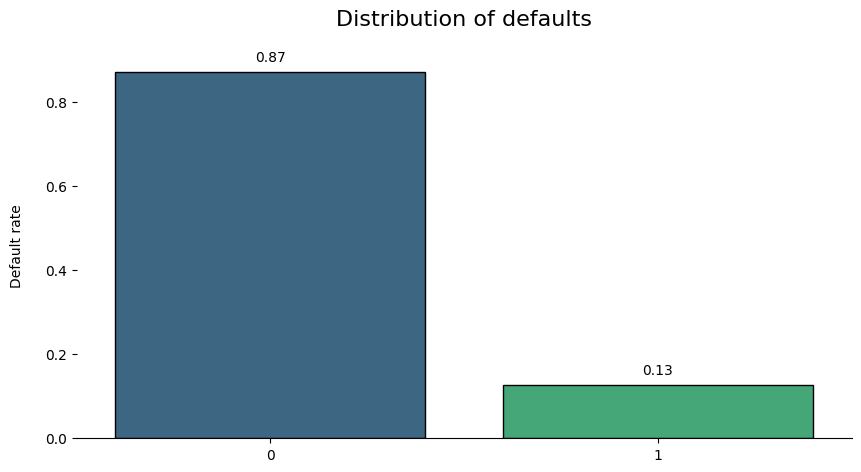

In [13]:
barplot(
    y, 
    'Distribution of defaults',
    'Default rate'
)

# Count columns completely consisting of nulls 

In [14]:
df.null_count()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,…,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
2260668,2260668,0,0,0,0,0,0,0,0,166931,0,0,4,0,0,0,2260668,2134600,0,23322,1,0,1711,29,29,30,1158502,1901512,29,29,0,1802,29,0,0,0,…,50030,50030,70276,2152648,2152647,2152647,2152647,2152647,2154484,2152647,2152647,2152647,2152647,2224726,0,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2252242,2250055,2250055,0,0,2227612,2227612,2227612,2227612,2227612,2227612


In [15]:
null_counter = df.null_count() == df.shape[0]
nul_val = null_counter.select([
    pl.col(col)
    for col in df.columns
    if null_counter[col][0]
])

# Removing columns completely from null 

In [16]:
df = df.drop(nul_val.columns)
nul_val.columns

['id', 'member_id', 'url']

# settlement features 

We will remove the attributes related to settlement, because in our model, even overdue is considered as default, so this attribute is directly related to the target variable, here we will also add ```hardship_flag```

In [17]:
cols_to_drop = [
    'settlement_amount',
    'settlement_date',
    'settlement_percentage',
    'settlement_status',
    'settlement_term',
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    "hardship_flag",
]

df = df.drop(cols_to_drop)

# ```loan_amnt```

Note that this feature is ideologically very similar to ```fundedAmnt```. ```loan_amnt``` is the requested amount of credit, and ```fundedAmnt``` is the amount granted. For us, ```fundedAmnt``` is strongly more important, as it is directly the amount we are risking.

Also, using fature engineering based on the matching of these two features would be inappropriate. Since there is a tendency that a person who is approved for a loan amount less than he requested is more prone to default. So our model will actually use the company's prediction.

Let's preliminarily assess how numerically similar it is to ```funded_amnt```

In [18]:
print(
    f'Share of observations where funded_amnt and loan_amnt match: {((df["funded_amnt"] == df["loan_amnt"]).sum() / df.shape[0]):.4f}'
)

Share of observations where funded_amnt and loan_amnt match: 0.9991


Thus we can exclude this variable because it logically coincides with ```funded_amnt``` and is practically equal to it.

In [19]:
df = df.drop("loan_amnt")

# ```funded_amnt``` and ```funded_amnt_inv```

First, let's check the equality of these columns. Since ```funded_amnt_inv``` is not in the documentation 

In [20]:
df[["funded_amnt", "funded_amnt_inv"]].filter(df["funded_amnt"] != df["funded_amnt_inv"])

funded_amnt,funded_amnt_inv
i64,f64
15000,14975.0
6000,5975.0
7500,7475.0
7000,6975.0
9000,8975.0
…,…
12225,12175.0
16000,15950.0
30000,29725.0


We may assume that ```funded_amnt_inv``` is a float64 version of ```funded_amnt```, for accuracy it is desirable to use ```funded_amnt_inv``` exactly. However, one strange thing can be noticed: 

In [21]:
print(
    f'Number of zero elements in funded_amnt_inv {(df["funded_amnt_inv"] == 0).sum()}'
     )

print(
    f'Number of zero elements in funded_amnt {(df["funded_amnt"] == 0).sum()}'
     )

Number of zero elements in funded_amnt_inv 233
Number of zero elements in funded_amnt 0


In [22]:
df.filter(df["funded_amnt_inv"] == 0)[["funded_amnt_inv", "funded_amnt"]]

funded_amnt_inv,funded_amnt
f64,i64
0.0,1775
0.0,7500
0.0,4000
0.0,2100
0.0,7500
…,…
0.0,3000
0.0,6500
0.0,1000


Part of the observations in ```funded_amnt_inv``` is zeroed, which defies logic, since we could not give a zero amount. Thus, it is better to use the well-documented ```funded_amnt``` feature instead of ```funded_amnt_inv``` and eliminate the second one

In [23]:
df = df.drop("funded_amnt_inv")

Let's calculate null and NaN 

In [24]:
check_null_nan(df["funded_amnt"])

Number of nulls: 0


Now let's take a look at the distribution of this feature

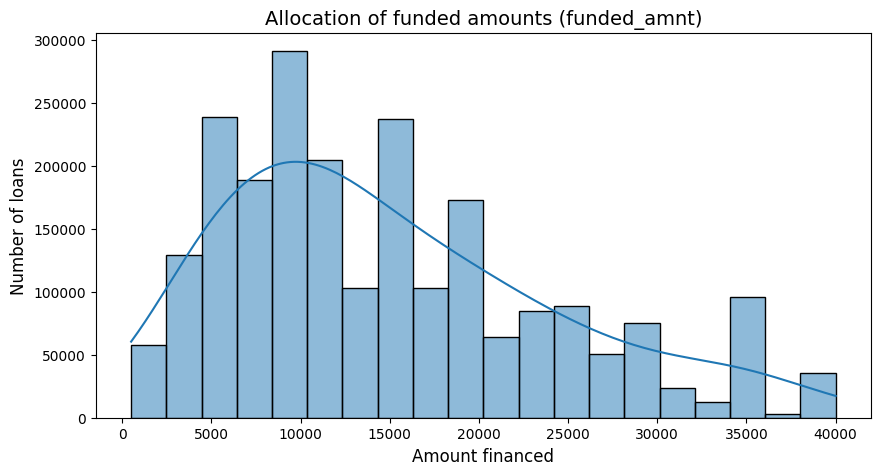

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='funded_amnt', bins=20, kde=True, edgecolor='black', kde_kws={"bw_adjust": 7})
plt.title('Allocation of funded amounts (funded_amnt)', fontsize=14)
plt.xlabel('Amount financed', fontsize=12)
plt.ylabel('Number of loans', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')  

# ```term```

In [26]:
check_null_nan(df["term"])

Number of nulls: 0


In [27]:
df["term"].value_counts()

term,count
str,u32
""" 36 months""",1609754
""" 60 months""",650914


As we can see there are only two values, but the best solution is to convert this variable into a continuous one. This may open up the possibility of later using the model on other time intervals, all other things being equal. But since we use binning we cannot do this, as we will have only two bins

In [28]:
df = df.with_columns(
    pl.col("term")
    .str.split(" ")
    .cast(pl.Array(pl.Utf8, shape=3))
    .arr.get(1)
    .cast(pl.Int64)
    .alias("term_months")
).drop("term")

# ```int_rate```

In [29]:
check_null_nan(df["int_rate"])

Amount of NaN: 0
Number of nulls: 0


Now let's look at the distribution of its values 

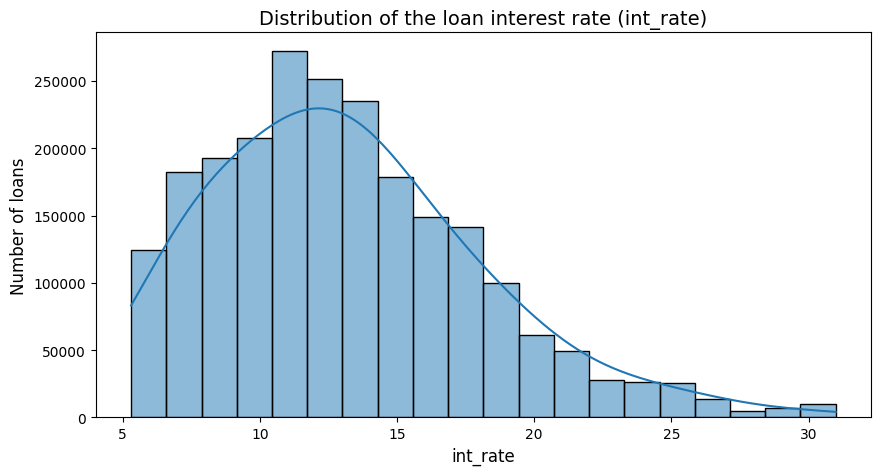

In [30]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='int_rate', bins=20, kde=True, edgecolor='black', kde_kws={"bw_adjust": 8})
plt.title('Distribution of the loan interest rate (int_rate)', fontsize=14)
plt.xlabel('int_rate', fontsize=12)
plt.ylabel('Number of loans', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')  

Let's try to apply log transformation to this variable

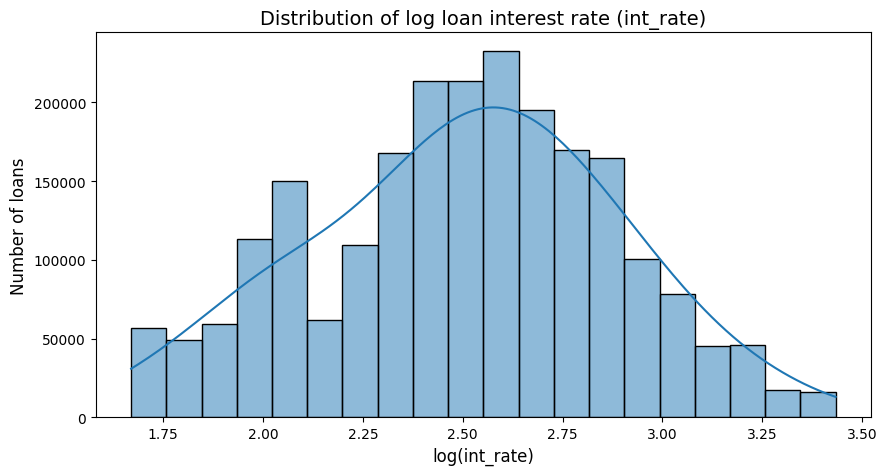

In [31]:
plt.figure(figsize=(10, 5))
sns.histplot(x=df['int_rate'].log(), bins=20, kde=True, edgecolor='black', kde_kws={"bw_adjust": 8.5})
plt.title('Distribution of log loan interest rate (int_rate)', fontsize=14)
plt.xlabel('log(int_rate)', fontsize=12)
plt.ylabel('Number of loans', fontsize=12)
plt.ticklabel_format(style='plain', axis='x') 

We see that the log transform adds symmetry to the data. Let's check whether this distribution can be considered normal. Let's standardize for clarity

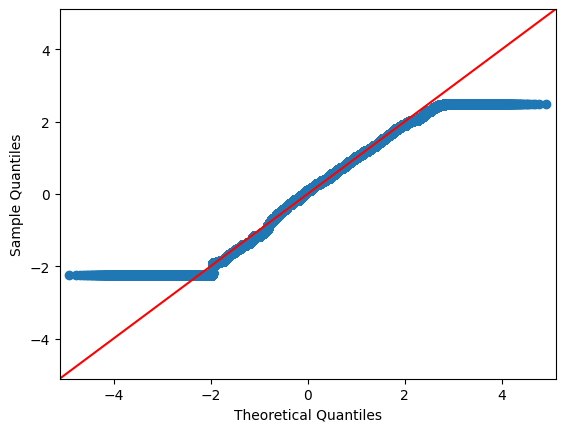

In [32]:
log_int_rate = df['int_rate'].log()
scaled_log_int_rate = (log_int_rate - log_int_rate.mean()) / log_int_rate.std()
qqplot(scaled_log_int_rate, line='45', fit=True);

We can notice that our distribution has lighter tails than the normal distribution. Although logarithmization does not bring the feature to a normal distribution, it adds symmetry, which is good for our problem

# ```installment```

In [33]:
check_null_nan(df["installment"])

Amount of NaN: 0
Number of nulls: 0


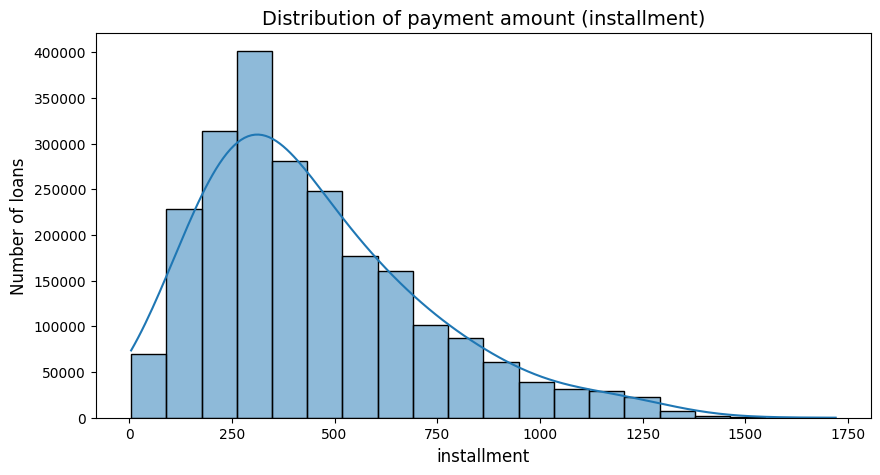

In [34]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='installment', bins=20, kde=True, edgecolor='black', kde_kws={"bw_adjust": 8})
plt.title('Distribution of payment amount (installment)', fontsize=14)
plt.xlabel('installment', fontsize=12)
plt.ylabel('Number of loans', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')  

# ```grade``` and ```sub_grade```

You can see that ```sub_grade``` and ```grade``` use a similar scale, namely ```sub_grade``` extends the scale of ```grade```. For better accuracy, it is preferable to use exactly ```sub_grade```. Therefore, we will remove ```grade```

In [35]:
df = df.drop("grade")

In [36]:
check_null_nan(df["sub_grade"])

Number of nulls: 0


Let's look at the distribution of values 

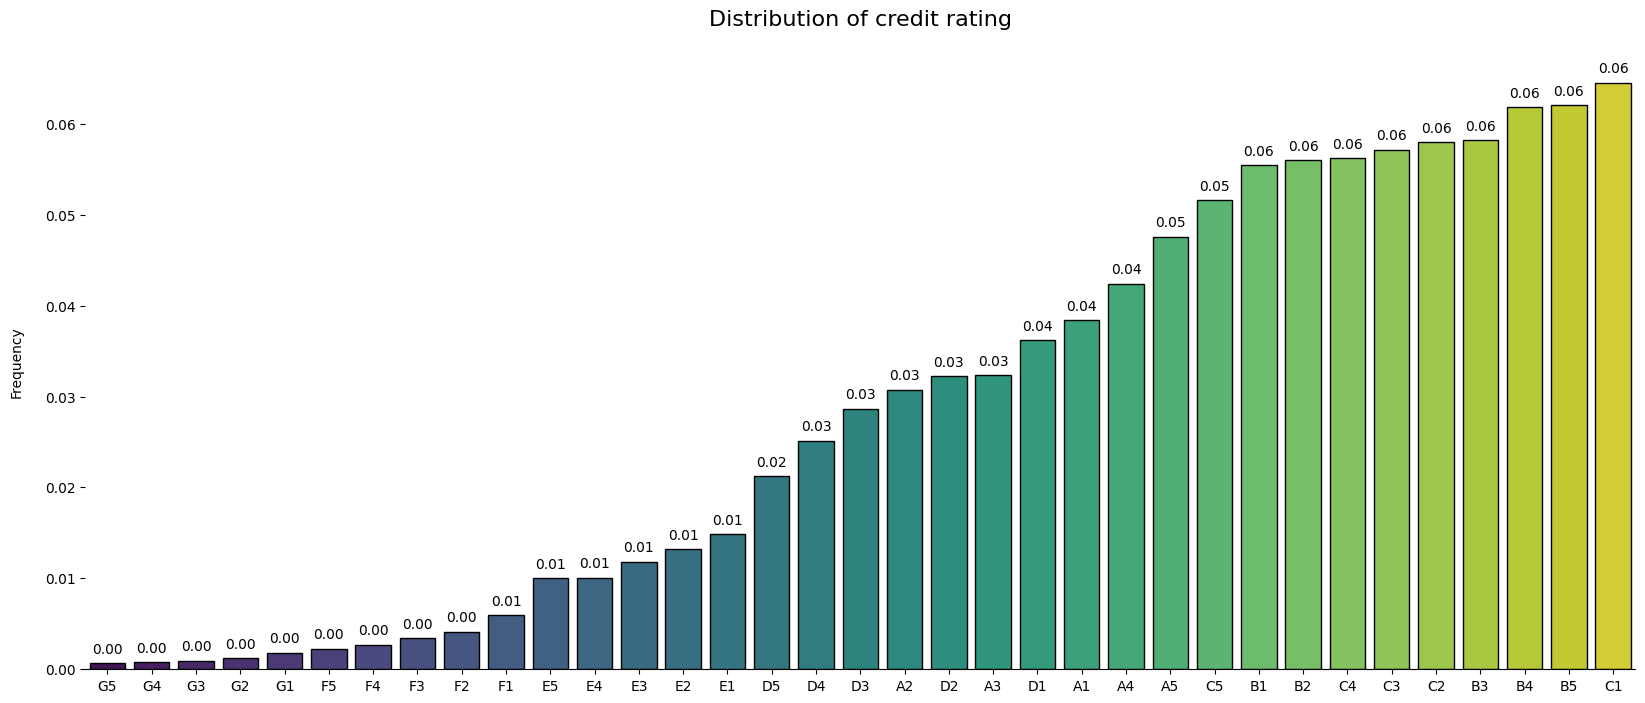

In [37]:
barplot(
    df["sub_grade"], 
    'Distribution of credit rating',
    'Frequency',
    (20, 8)
)

# ```emp_title```

This column contains data entered by the users themselves, so it is very diverse (e.g. senior can be labeled both as a word and as sr.). Therefore, the data needs to be seriously processed

First of all, let's remove unnecessary smivols to the right and left of the string and lowercase all strings

In [38]:
check_null_nan(df["emp_title"])

Number of nulls: 166931


Let's put the work with professions in a separate notebook for convenience

In [39]:
np.save("job_name.npy", df["emp_title"].to_numpy())

# ```emp_length```

In [40]:
check_null_nan(df["emp_length"])

Number of nulls: 0


In [41]:
df["emp_length"].value_counts()["emp_length"].to_list()

['n/a',
 '5 years',
 '3 years',
 '2 years',
 '10+ years',
 '6 years',
 '9 years',
 '1 year',
 '8 years',
 '7 years',
 '< 1 year',
 '4 years']

We will assume that the missing values here are MNAR. That is, we assume that if a person did not specify the duration of work, he/she did not work, i.e. n/a can be equated to 0. In order to handle all cases properly, the preferred option is to treat this variable as a categorical variable with the following categories (if we change the format of the collected data, we can either use the same categories by converting continuous variables to them, or change the format of the fiche to continuous). We can leave the column format unchanged and process all categories later (i.e. we have already done the binning for us).

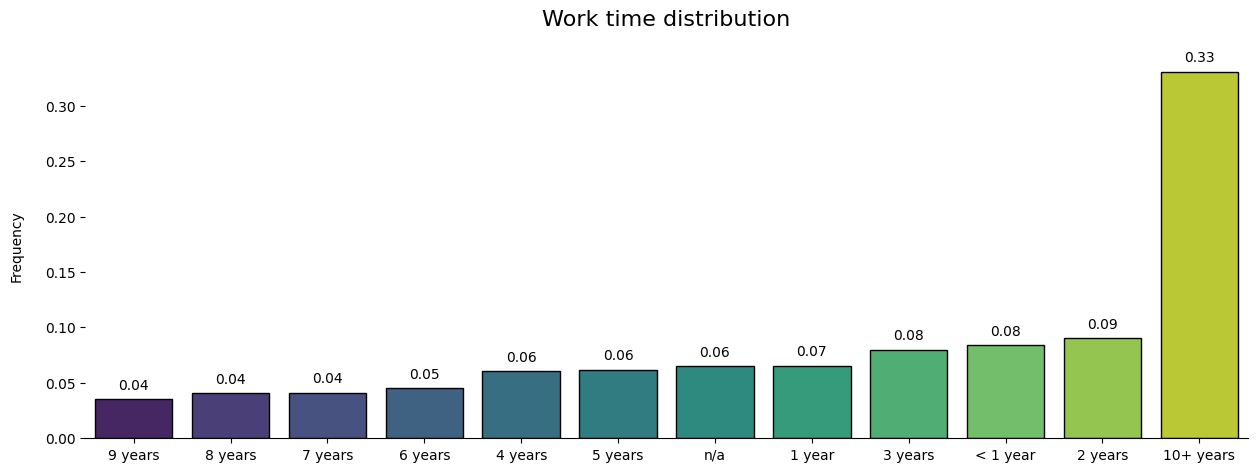

In [42]:
barplot(
    df["emp_length"], 
    'Work time distribution',
    'Frequency',
    (15, 5)
)

# ```home_ownership```

In [43]:
check_null_nan(df["home_ownership"])

Number of nulls: 0


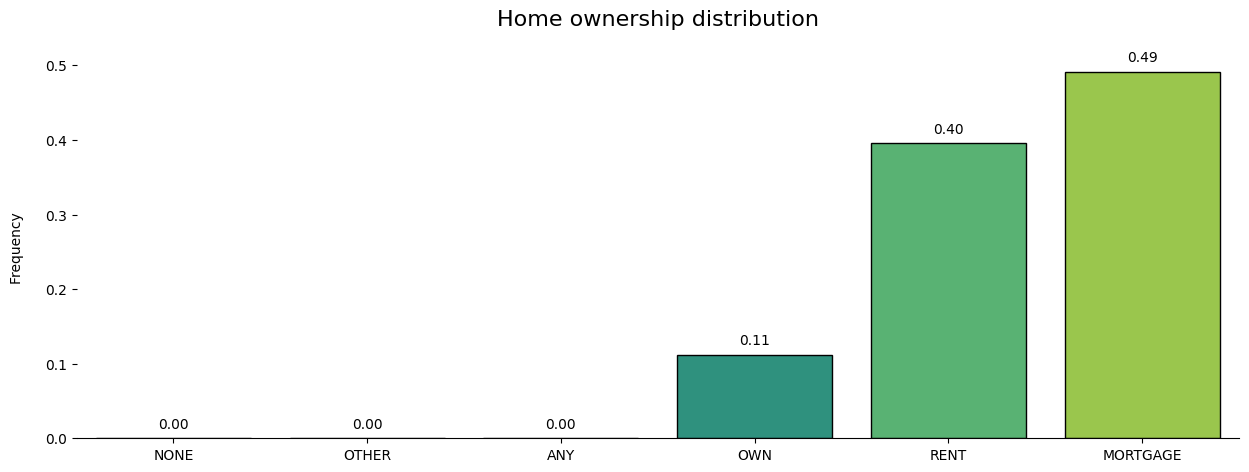

In [44]:
barplot(
    df["home_ownership"], 
    'Home ownership distribution',
    'Frequency ',
    (15, 5)
)

As we can see there is nothing wrong with the feature, however we see a very small presence of a couple of classes. Therefore, the first three categories should be merged 

In [45]:
df["home_ownership"].value_counts()

home_ownership,count
str,u32
"""OTHER""",182
"""MORTGAGE""",1111450
"""OWN""",253057
"""ANY""",996
"""NONE""",54
"""RENT""",894929


In [46]:
df = df.with_columns(
    pl.col("home_ownership").replace(
        {
            "ANY": "OTHER",
            "NONE": "OTHER"
        }
    ).alias("home_ownership")
)

# ```annual_inc```

This variable is responsible for the borrower's income level

In [47]:
check_null_nan(df["annual_inc"])

Amount of NaN: 0
Number of nulls: 4


We will assume that we are dealing with MNAR in this case, since we can assume that if income n is not specified, it is missing. However, we have very few missing data, so we can remove them without losing information and without reducing the quality of the model, leaving the treatment of missing values for inference

In [48]:
mask = ~df["annual_inc"].is_null()


df = df.filter(mask)
y = y.filter(mask)

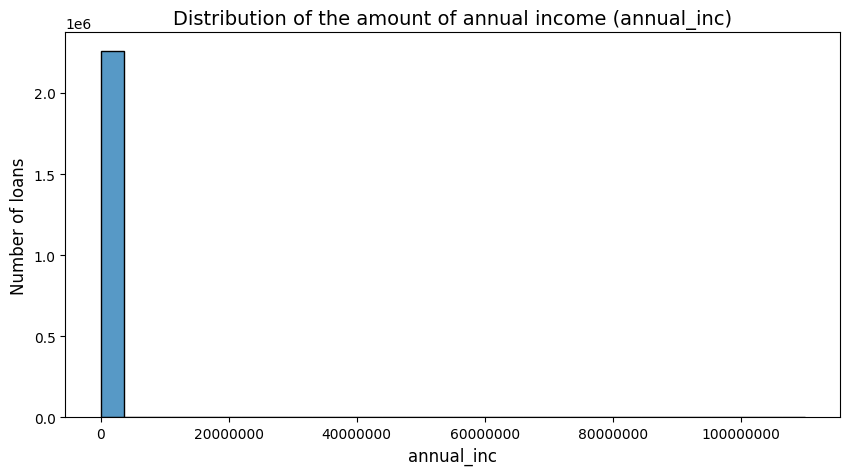

In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='annual_inc', bins=30, kde=False, edgecolor='black', kde_kws={"bw_adjust": 8})
plt.title('Distribution of the amount of annual income (annual_inc)', fontsize=14)
plt.xlabel('annual_inc', fontsize=12)
plt.ylabel('Number of loans', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')  

This pattern indicates the presence of strong outliers in the data. Note that we are dealing with a positive variable, so we will consider only the right-hand side interval 

In [50]:
annual_income = df["annual_inc"].to_numpy()
std = np.std(annual_income)
mean = np.mean(annual_income)

( annual_income <= (mean + 3 * std) ).sum() / annual_income.shape[0]

0.997207457631917

Let's look at the distribution of annual income in the intravalley $[0 ; \mu + 3 \cdot \sigma)$

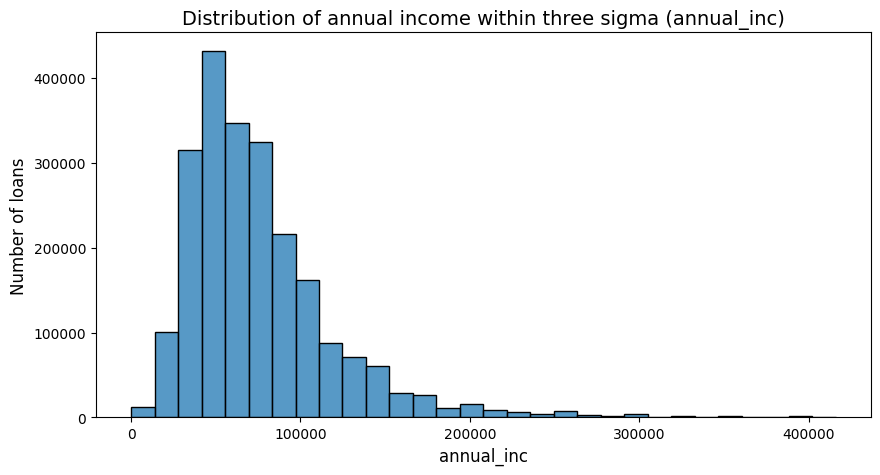

In [51]:
plt.figure(figsize=(10, 5))
sns.histplot(x=annual_income[annual_income <= (mean + 3 * std)], bins=30, kde=False, edgecolor='black', kde_kws={"bw_adjust": 8})
plt.title('Distribution of annual income within three sigma (annual_inc)', fontsize=14)
plt.xlabel('annual_inc', fontsize=12)
plt.ylabel('Number of loans', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')  

Since we plan to use binning, the emissions will fall into the upper category, but the fact that there are strong emissions must be considered 

# ```verification_status```

In [52]:
check_null_nan(df["verification_status"])

Number of nulls: 0


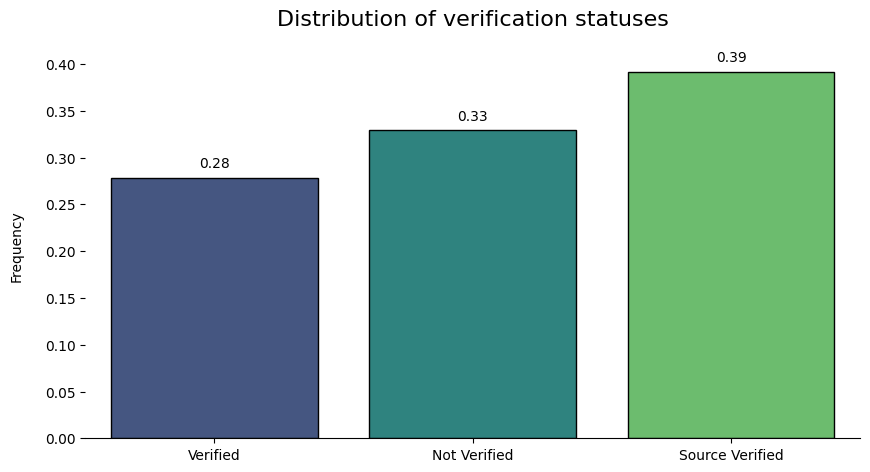

In [53]:
barplot(
    df["verification_status"], 
    "Distribution of verification statuses",
    "Frequency"
)

# ```issue_d```

In [54]:
check_null_nan(df["issue_d"])

Number of nulls: 0


Let's decompose by month and year

In [55]:
df = df.with_columns(
    [pl.col("issue_d")
    .str.split("-")
    .cast(pl.Array(pl.Utf8, shape=2))
    .arr.get(i)
    .cast(typ)
    .alias("issue_d" + "_" + name) 
     for i, name, typ in ((0, "month", pl.Utf8), (1, "year", int))
    ]
).drop("issue_d")

In [56]:
df["issue_d_month"].unique().to_list()

['Apr',
 'Dec',
 'Sep',
 'Jul',
 'Feb',
 'Oct',
 'Mar',
 'Jan',
 'Aug',
 'Nov',
 'Jun',
 'May']

In [57]:
df["issue_d_year"].unique().to_list()

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

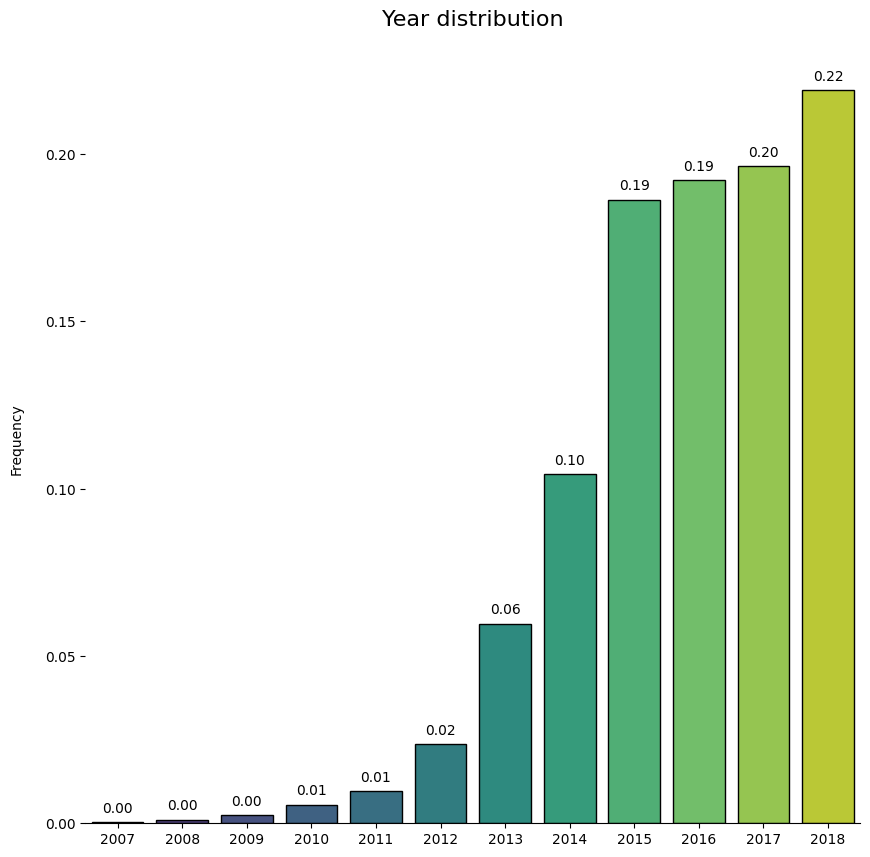

In [58]:
barplot(
    df["issue_d_year"], 
    "Year distribution",
    "Frequency",
    (10, 10)
)

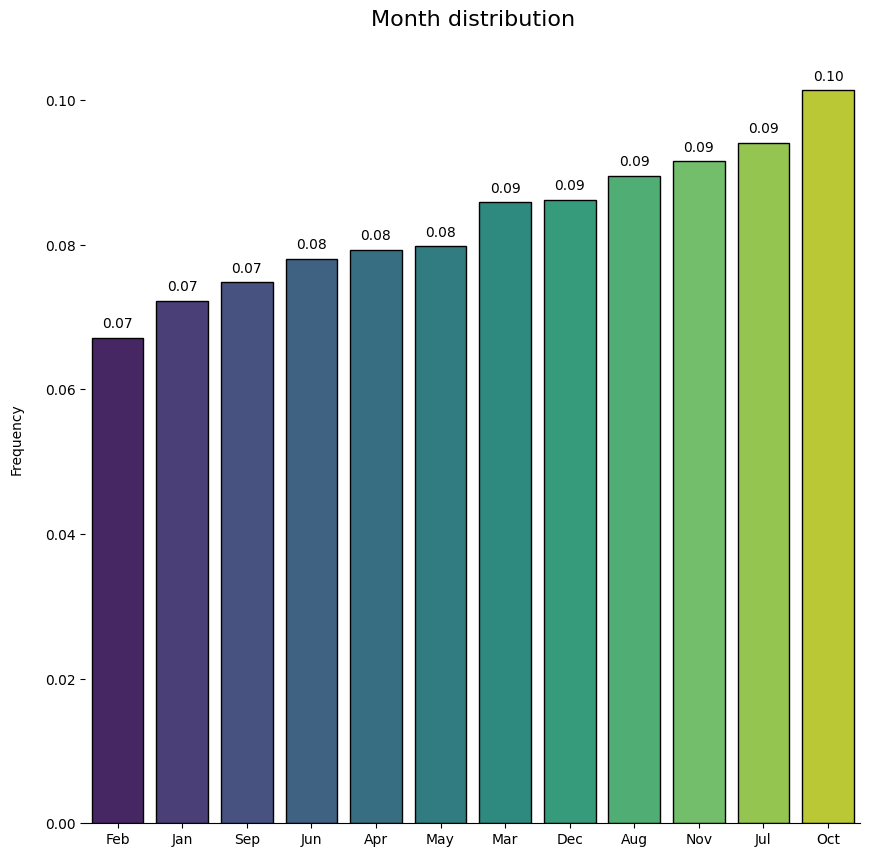

In [59]:
barplot(
    df["issue_d_month"], 
    "Month distribution",
    "Frequency",
    (10, 10)
)

We leave the ```year``` feature, but do not include this feature in the model. We use it to separate the data and check the generalizability of the model

# ```pymnt_plan```

This variable is missing in the documentation, let's check its elements 

In [60]:
df["pymnt_plan"].value_counts()

pymnt_plan,count
str,u32
"""y""",682
"""n""",2259982


We can consider this variable as insignificant, so let's delete it

In [61]:
df = df.drop("pymnt_plan")

# ```desc```

This variable represents the loan description provided by the borrower. First of all, let's check the number of nulls in it 

In [62]:
check_null_nan(df["desc"])

Number of nulls: 2134600


In [63]:
df["desc"].null_count() / df.shape[0]

0.9442358528290803

After analyzing this data manually, I noticed that very often the information provided there coincides with ```purpose``` and ```title```. Also taking into account that only about 5% of requests have a description, I came to the conclusion that this feature should be removed 

In [64]:
df = df.drop("desc")

# ```purpose``` and ```title```   

In [65]:
df["purpose"].unique()

purpose
str
"""small_business"""
"""medical"""
"""debt_consolidation"""
"""credit_card"""
"""educational"""
…
"""other"""
"""vacation"""
"""house"""


In [66]:
df["title"].unique()

title
str
"""New Year Payoff"""
"""Combine cards"""
"""Paid my credit card"""
"""Outdoor living area"""
"""Discover Card Debt"""
…
"""Debt Evaporator """
"""Consol 1 """
"""KRISSY'S LOAN"""


You can see that ```purpose``` is a generalized version of ```title```. Therefore, it makes sense to use ```purpose``` in our model and remove ```title```.

In [67]:
df = df.drop("title")
check_null_nan(df["purpose"])

Number of nulls: 0


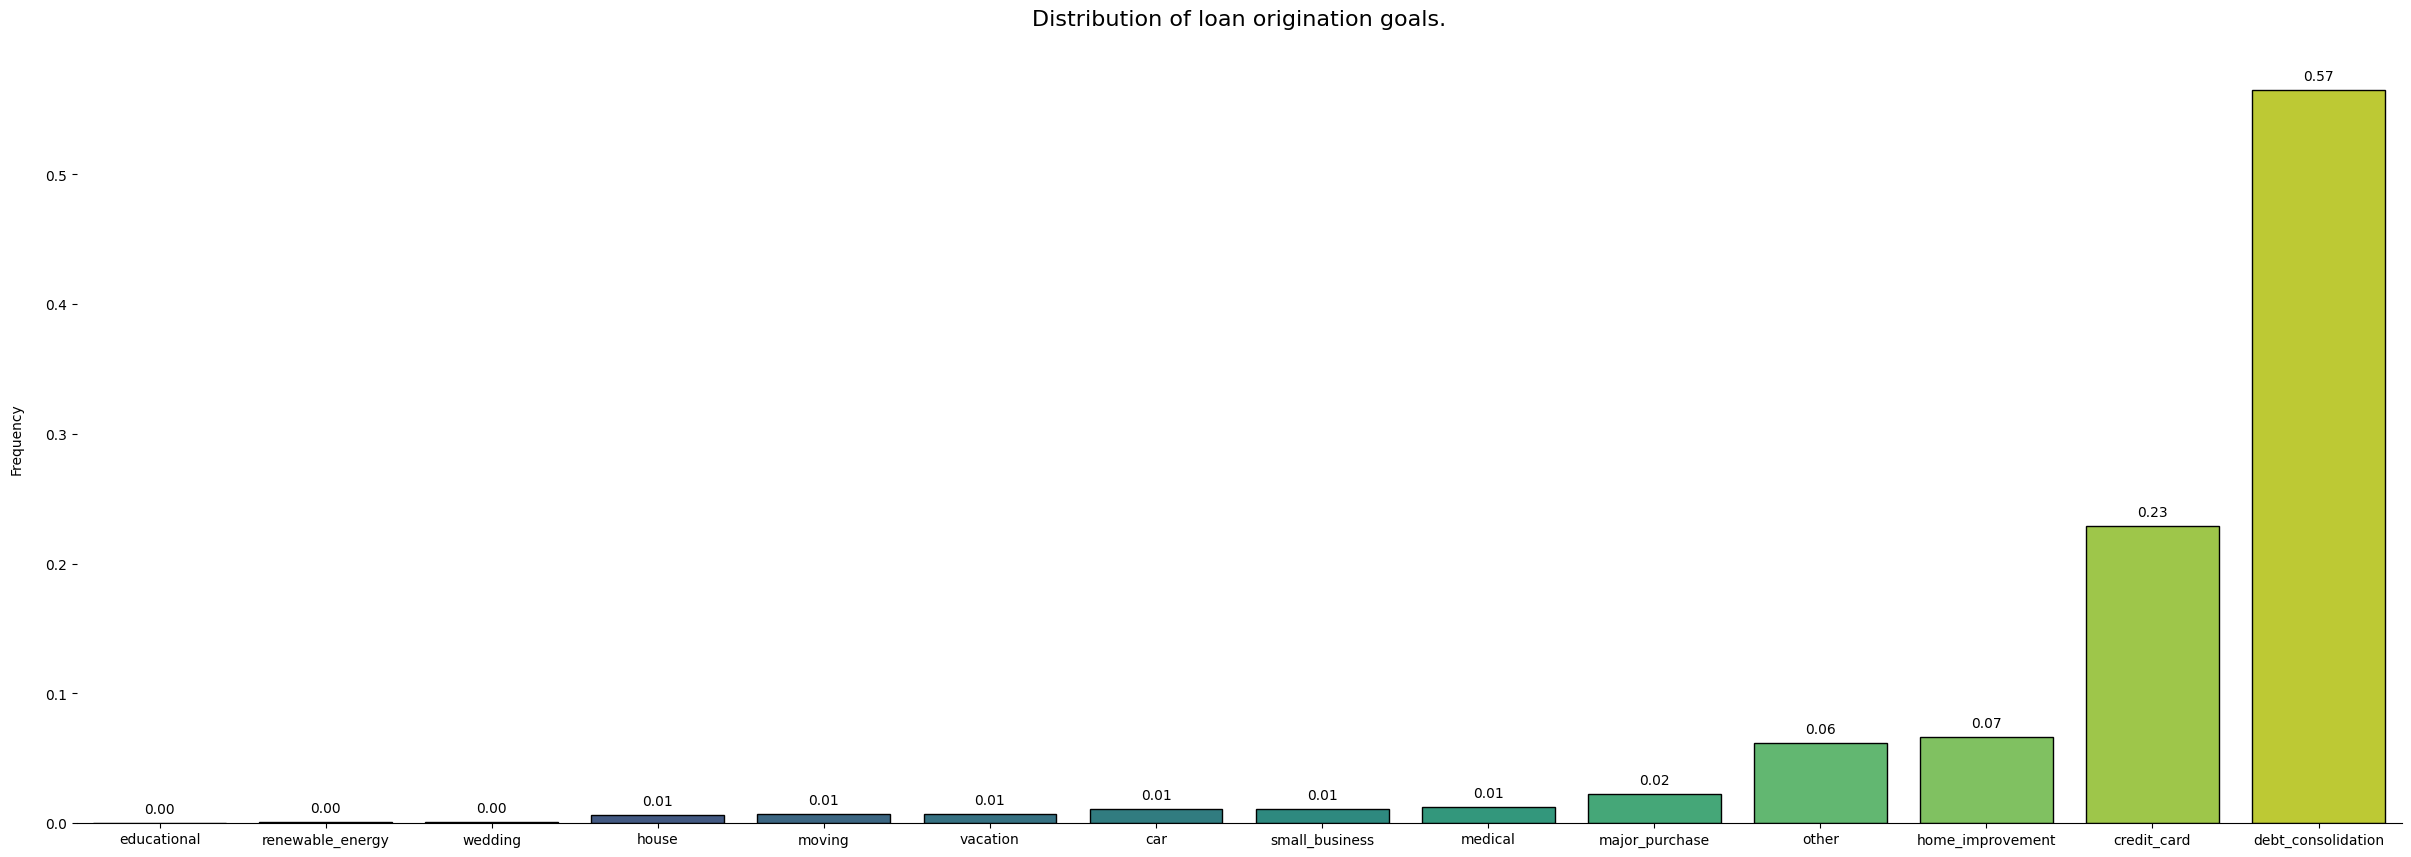

In [68]:
barplot(
    df["purpose"], 
    "Distribution of loan origination goals.",
    "Frequency",
    (30, 10)
)

Some categories are very small so some of them will need to be merged, this can be achieved by specifying a minimum bin size in optbinning 

# zip_code

These are the first three digits of the zip code specified by the borrower. We will just check this variable for null and then we will think how we can use this feature

In [69]:
check_null_nan(df["zip_code"])

Number of nulls: 1


Let us try to consider this variable as a categorical variable

In [70]:
df["zip_code"].unique()

zip_code
str
"""347xx"""
"""040xx"""
"""587xx"""
"""180xx"""
"""661xx"""
…
"""124xx"""
"""172xx"""
"""671xx"""


As we can see there are too many categories. Let's try to interpret these codes according to the information from the Internet: 

1. **First digit**:
   - Indicates a **wide geographic region** of the country. The US is divided into 10 such regions, ranging from “0” in the Northeast (e.g. Massachusetts, Connecticut) to “9” in the West (e.g. California, Alaska).

2. **Second and third digits**:
   - Clarify a **more specific area** within that region. For example, they may indicate a major city or a group of states. For example:
     - In region “0” (northeast), the digits “02” may indicate part of New Jersey.
     - In region “9” (west), the digits “02” may indicate part of California.

We'll do this: first we'll drop nulls, and afterwards we'll extract the first digit and use it as a feature

In [71]:
mask = ~df["zip_code"].is_null()

df = df.filter(mask).with_columns(
    pl.col("zip_code")
    .str
    .head(1)
    .cast(pl.Int8)
    .alias("region_code")
).drop("zip_code")

y = y.filter(mask)

# ```addr_state```

In [72]:
check_null_nan(df["addr_state"])

Number of nulls: 0


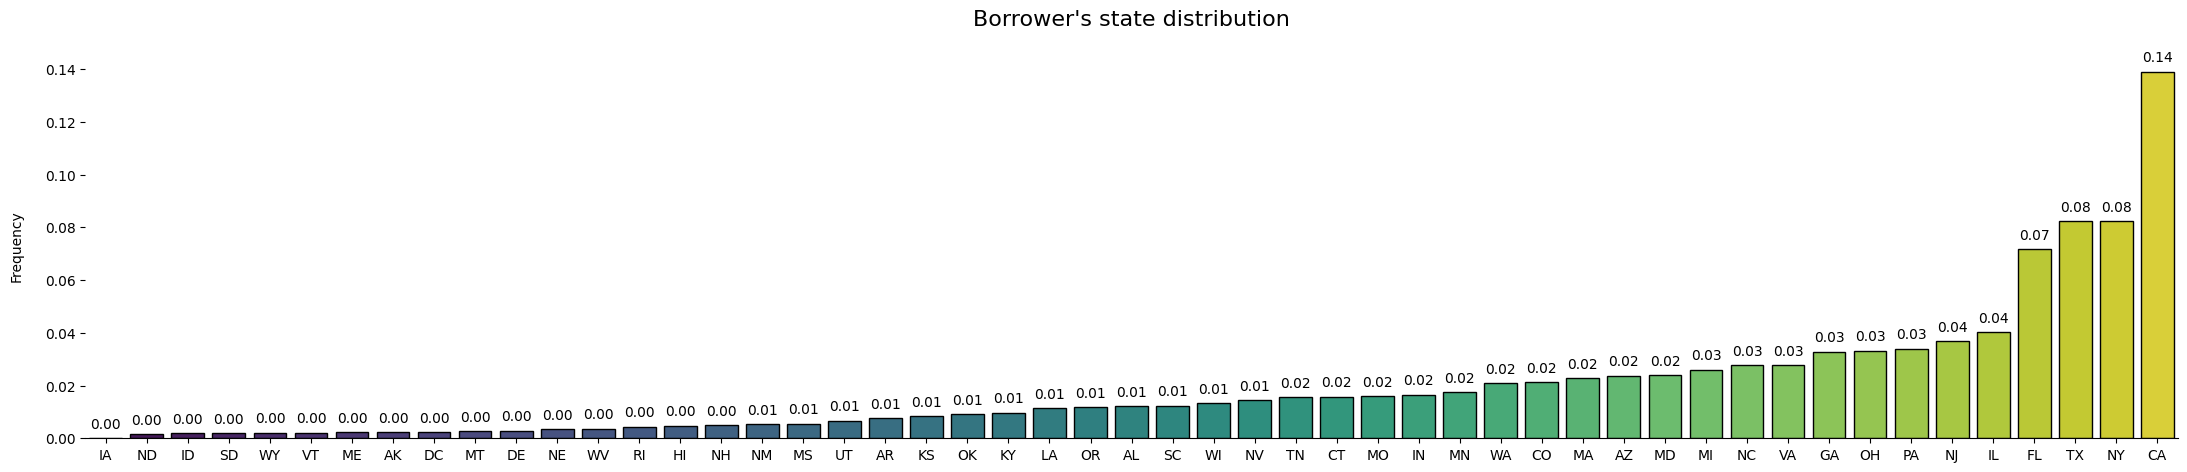

In [73]:
barplot(
    df["addr_state"],
    "Borrower's state distribution",
    "Frequency",
    (27, 5)
)

By analogy with ```purpose```, we are going to try to merge some categories

# ```dti```

This is the ratio of the borrower's monthly debt obligations (excluding mortgage and requested loan) to their monthly income.

In [74]:
check_null_nan(df["dti"])

Amount of NaN: 0
Number of nulls: 1711


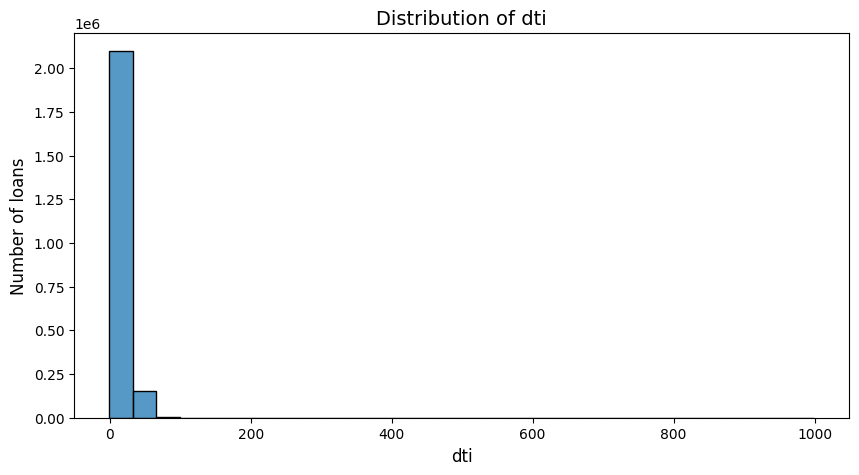

In [75]:
plt.figure(figsize=(10, 5))
sns.histplot(x=df["dti"], bins=30, kde=False, edgecolor='black', kde_kws={"bw_adjust": 8})
plt.title('Distribution of dti', fontsize=14)
plt.xlabel('dti', fontsize=12)
plt.ylabel('Number of loans', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')  

There are also outliers here, so let's display all values in the interval $[0, \mu + 3 \cdot \sigma]$

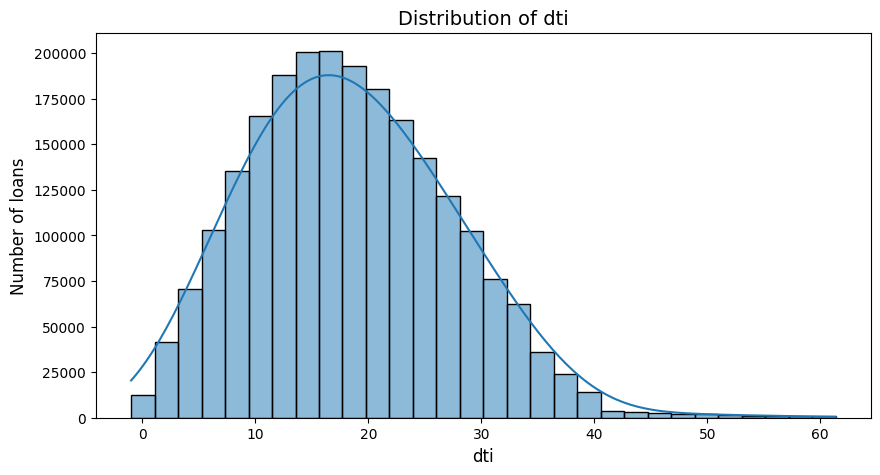

In [76]:
dti = df["dti"]

plt.figure(figsize=(10, 5))
sns.histplot(
    x=dti.filter(dti <= (dti.mean() + 3 * dti.std())),
    bins=30, 
    kde=True, 
    edgecolor='black', 
    kde_kws={"bw_adjust": 8}
)
plt.title('Distribution of dti', fontsize=14)
plt.xlabel('dti', fontsize=12)
plt.ylabel('Number of loans', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')  

This variable is a ratio of debt and income, so we can assume that null values arise because of cases where income is zero. Then we need to replace null with very large values, which will then be included in the largest bin. Let's check this statement 

In [77]:
inc_where_dti_null = df["annual_inc"].filter(df["dti"].is_null())

(inc_where_dti_null == 0).mean()

0.9696084161309176

In [78]:
inc_where_dti_null.filter(inc_where_dti_null != 0).to_list()

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 8.0,
 10.0,
 1.0,
 10.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 10.0,
 1.0,
 1.0,
 6.0,
 10.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 10.0,
 0.36,
 1.0,
 1.0,
 1.0]

As we see in most cases where dti is missing the income is zero, and in the remaining 3% of cases --- very small values, so replacing dti with some large value is logical

In [79]:
df = df.with_columns(
    pl.col("dti").fill_null(10 ** 4)
)

# ```delinq_2yrs``` and ```delinq_amnt```

This variable is responsible for the number of instances of late payments of more than 30 days in the last 2 years

In [80]:
check_null_nan(df["delinq_amnt"])

Number of nulls: 25


In [81]:
check_null_nan(df["delinq_2yrs"])

Number of nulls: 25


There are also very few missing values in ```delinq_2yrs``` here that can be neglected. It can also be assumed that these missing values in these two traits overlap

In [82]:
(df["delinq_2yrs"].is_null() & df["delinq_amnt"].is_null()).sum()

25

In [83]:
mask = ~df["delinq_2yrs"].is_null()

df = df.filter(mask)
y = y.filter(mask)

Let's see if these features are similar.

In [84]:
(df["delinq_2yrs"] == df["delinq_amnt"]).mean()

0.8135380366073648

In 80% of cases these features are similar, we will leave the one with the larger IV 

In [85]:
check_iv(df["delinq_2yrs"], y)

IV: 0.00445


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",1839107,0.813534,1610951,228156,0.124058,0.030694,0.000758,0.000095
1,"[0.50, 1.50)",281353,0.124457,242680,38673,0.137454,-0.087254,0.000979,0.000122
2,"[1.50, inf)",140178,0.062008,118929,21249,0.151586,-0.201639,0.002716,0.000339
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2260638,1.000000,1972560,288078,0.127432,,0.004452,0.000556


In [86]:
check_iv(df["delinq_amnt"], y)

IV: 0.00000


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",2260638,1.0,1972560,288078,0.127432,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,2260638,1.0,1972560,288078,0.127432,,0.0,0.0


Let's delete ```delinq_amnt```

In [87]:
df = df.drop("delinq_amnt")

# ```earliest_cr_line```	

This variable is responsible for the date of the borrower's earliest credit line, so one should be prepared for missing values, as the client did not necessarily have a credit line prior to the application

In [88]:
check_null_nan(df["earliest_cr_line"])

Number of nulls: 0


The substitution of null here is not logically valid. A good practice is to put the user with null in a separate category, however we will get a very small group which WoE for which will be very unstable, so the logical solution is to delete nulls, as their quantity is very small. Also we need to decompile this feature for year and month 

In [89]:
mask = ~df["earliest_cr_line"].is_null()

df = df.filter(mask)
y = y.filter(mask)

In [90]:
df = df.with_columns(
    [pl.col("earliest_cr_line")
    .str.split("-")
    .cast(pl.Array(pl.Utf8, shape=2))
    .arr.get(i)
    .cast(typ)
    .alias("earliest_cr_line" + "_" + name) 
     for i, name, typ in ((0, "month", pl.Utf8), (1, "year", int))
    ]
).drop("earliest_cr_line")

# ```inq_last_6mths``` and ```inq_last_12m```

These variables is responsible for the number of credit applications for the last 6 and 12 months respectively 

In [91]:
check_null_nan(df["inq_last_6mths"])

Number of nulls: 1


In [92]:
check_null_nan(df["inq_last_12m"])

Number of nulls: 866101


Let's check the similarity of these columns 

In [93]:
mask = ~df["inq_last_12m"].is_null() & ~df["inq_last_6mths"].is_null()

(df["inq_last_12m"].filter(mask) == df["inq_last_6mths"].filter(mask)).mean()

0.3986513086422232

As we can see, there are many more nulls in ```inq_last_12m```, but this column is representative because only 40% of the non-null data matches ```inq_last_6mths```. So let's fill in the nulls with data from ```inq_last_6mths```. If we have null in both cases, we will assume that the person did not apply for a loan 

In [94]:
df = df.with_columns(
    pl.when(pl.col("inq_last_12m").is_null() & ~pl.col("inq_last_6mths").is_null())
    .then(pl.col("inq_last_6mths"))
    .otherwise(pl.col("inq_last_12m")) 
    .alias("inq_last_12m")  
)

mask = ~df["inq_last_12m"].is_null()

df = df.filter(mask)
y = y.filter(mask)

# ```mths_since_last_delinq``` and ```mths_since_recent_revol_delinq``` and ```mths_since_recent_bc_dlq```

These features are responsible for: 

- The number of months since the borrower's last delinquency.
- Months since most recent revolving delinquency
- Months since most recent bankcard delinquency

As we can see, these features are very logically similar

In [95]:
data_to_check = df[
    [
        "mths_since_last_delinq", 
        "mths_since_recent_revol_delinq" , 
        "mths_since_recent_bc_dlq"
    ]
]

print(f'{data_to_check["mths_since_last_delinq"].is_null().mean():.4f}')
print(f'{data_to_check["mths_since_recent_revol_delinq"].is_null().mean():.4f}')
print(f'{data_to_check["mths_since_recent_bc_dlq"].is_null().mean():.4f}')

0.5125
0.6725
0.7701


We can assume that since these features are logically related, for example we can observe that ```mths_since_recent_revol_delinq``` and ```mths_since_recent_bc_dlq``` are subsets of ```mths_since_last_delinq```

In [96]:
null_mean = (
    data_to_check
    .select(pl.all().is_null())  
    .transpose()
    .select(pl.col("*").all())
    .transpose()
    .mean()
)
round(null_mean["column_0"][0], 4)

0.5119

In [97]:
mask = (
    (~data_to_check["mths_since_last_delinq"].is_null()) & 
    (~data_to_check["mths_since_recent_revol_delinq"].is_null()) &
    (~data_to_check["mths_since_recent_bc_dlq"].is_null())
)

In [98]:
mask.mean()

0.2294432940803853

In [99]:
filtered_data = data_to_check.filter(mask)
mask1 = filtered_data["mths_since_last_delinq"] == filtered_data["mths_since_recent_revol_delinq"]
mask2 = filtered_data["mths_since_last_delinq"] == filtered_data["mths_since_recent_bc_dlq"]

(
    mask1 &
    mask2
).mean()

0.6251195323585662

In [100]:
print(f"{mask1.mean():.4f}")
print(f"{mask2.mean():.4f}")

0.7672
0.6256


In [101]:
(mask1 | mask2).mean()

0.7677736905422913

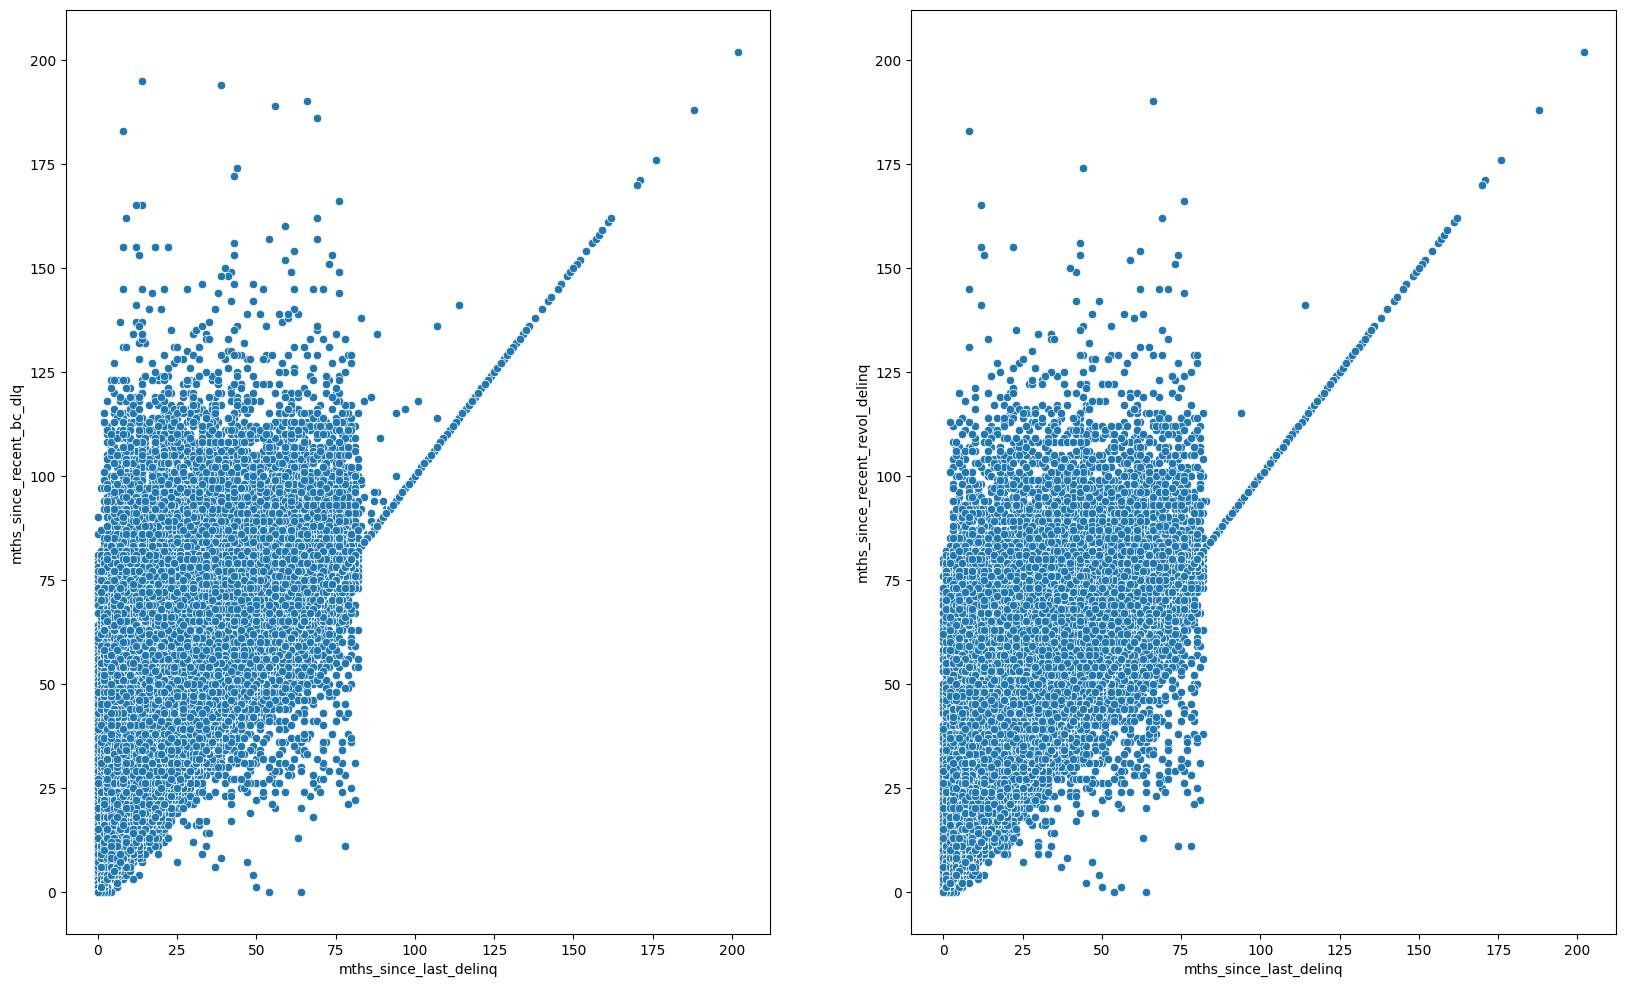

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

sns.scatterplot(
    x=filtered_data["mths_since_last_delinq"], 
    y=filtered_data["mths_since_recent_bc_dlq"],
    ax=ax[0]
)
sns.scatterplot(
    x=filtered_data["mths_since_last_delinq"], 
    y=filtered_data["mths_since_recent_revol_delinq"],
    ax=ax[1]
)

plt.show()

As we see in 22% of the cases all three features are not equal to null and of these, in about 60% of the cases all three features are equal. And also in about 75% of the cases at least one of the feature values of the subset matches the feature of the superset 

As we can see, despite the fairly strong relationship between these attributes, it is impossible to remove some of them because there are significant deviations between them that can affect the target variable. 

It should also be noted that the missing values in this case are MNAR - so we can assume that the missing values are due to the fact that the client has not had delinquencies in the past. So we will leave them untouched and process them in the binning process

# ```mths_since_last_record```

In [103]:
check_null_nan(df["mths_since_last_record"])

Number of nulls: 1901482


In [104]:
df["mths_since_last_record"].is_null().mean()

0.8411266381997641

In [105]:
df["mths_since_last_record"].unique()

mths_since_last_record
i64
null
0
1
2
3
…
124
125
126


This feature is rather poorly documented, also a significant part of it represents missing values, which is more difficult to deal with without a clear interpretation, therefore it was decided to remove the feature

In [106]:
df = df.drop("mths_since_last_record")

# ```open_acc``` and ```total_acc```

In [107]:
check_null_nan(df["open_acc"])

Number of nulls: 0


In [108]:
check_null_nan(df["total_acc"])

Number of nulls: 0


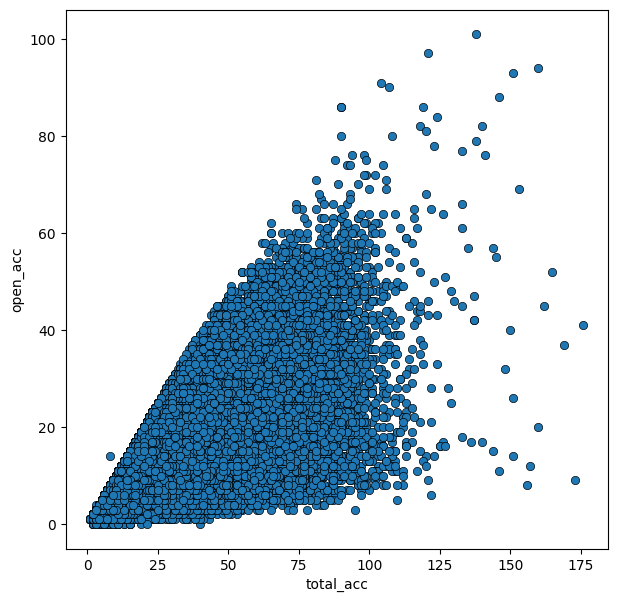

In [109]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=df["total_acc"], y=df["open_acc"], edgecolor='Black')
plt.show();

In [110]:
(df["total_acc"] == df["open_acc"]).mean()

0.017636179537006604

# ```pub_rec``` and ```pub_rec_bankruptcies```

In [111]:
check_null_nan(df["pub_rec"])

Number of nulls: 0


In [112]:
check_null_nan(df["pub_rec_bankruptcies"])

Number of nulls: 1336


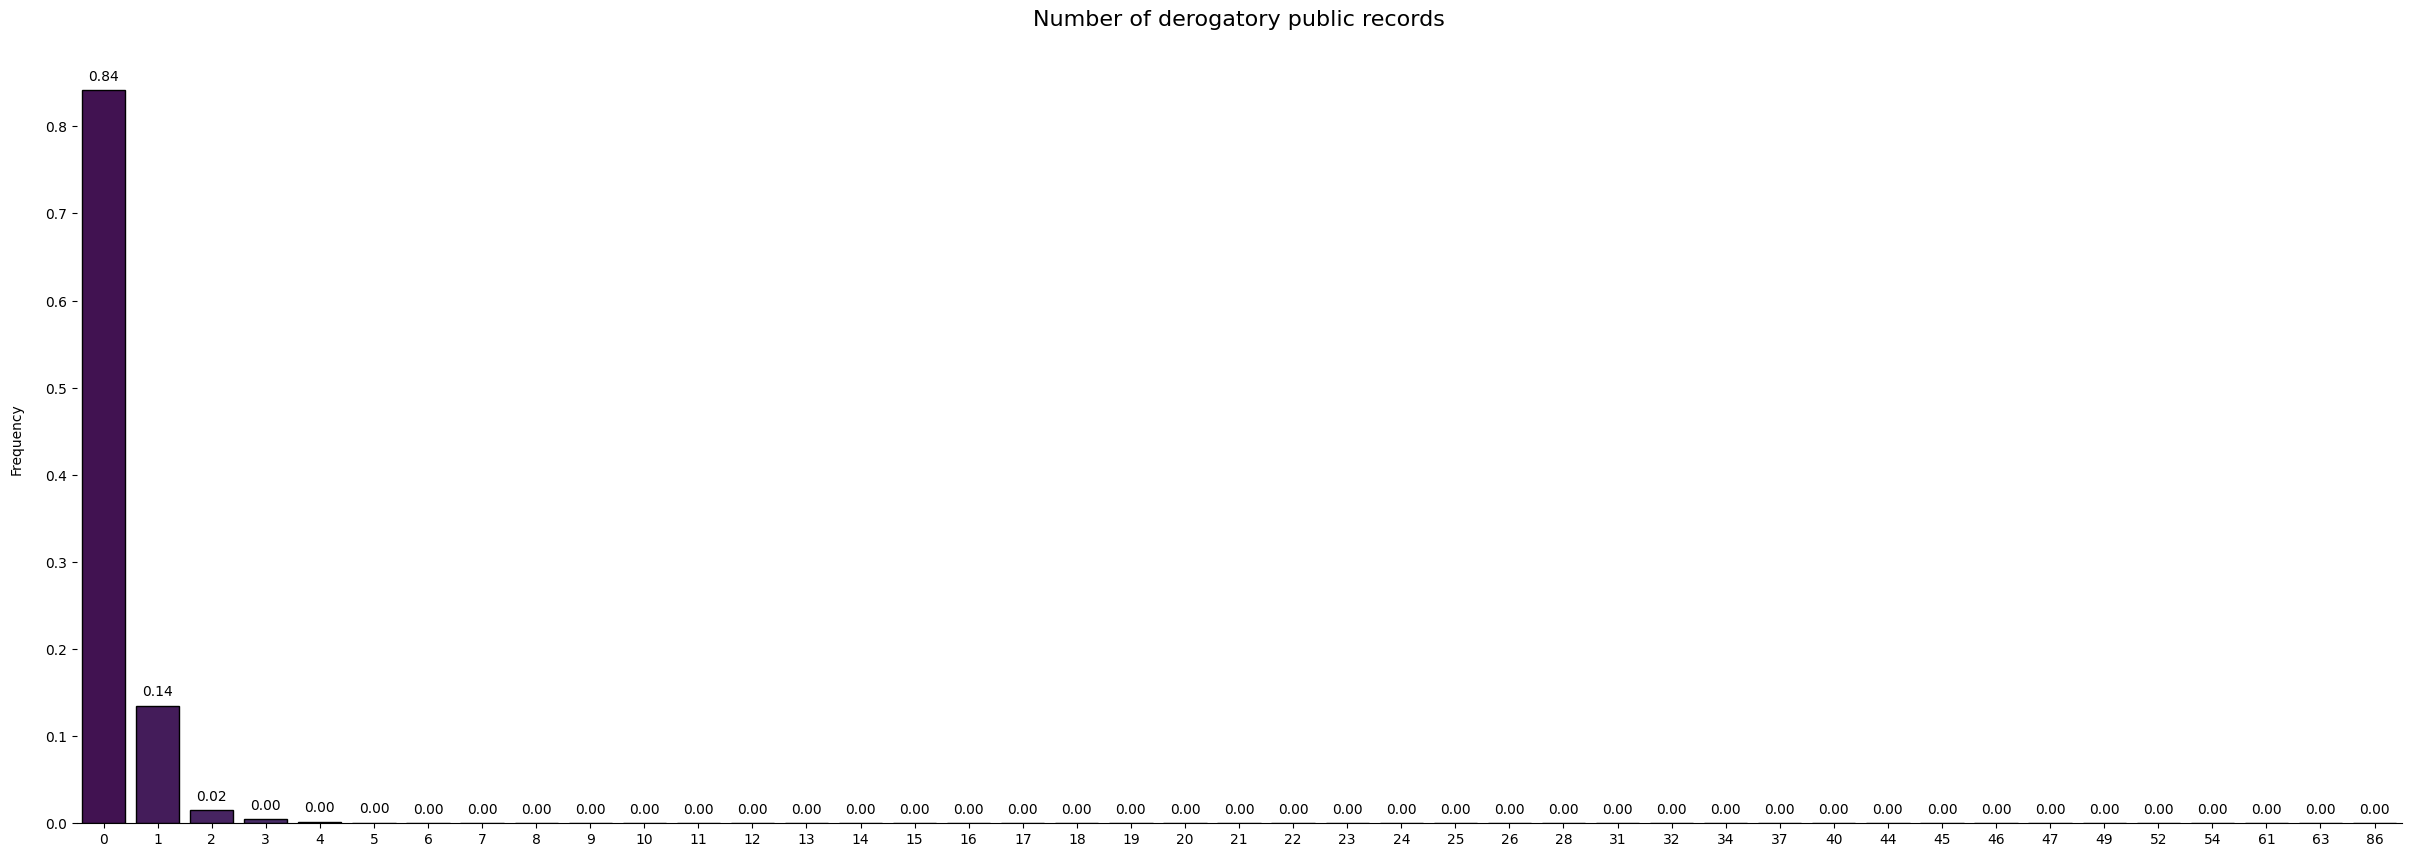

In [113]:
barplot(
    df["pub_rec"], 
    "Number of derogatory public records",
    "Frequency",
    (30, 10)
)

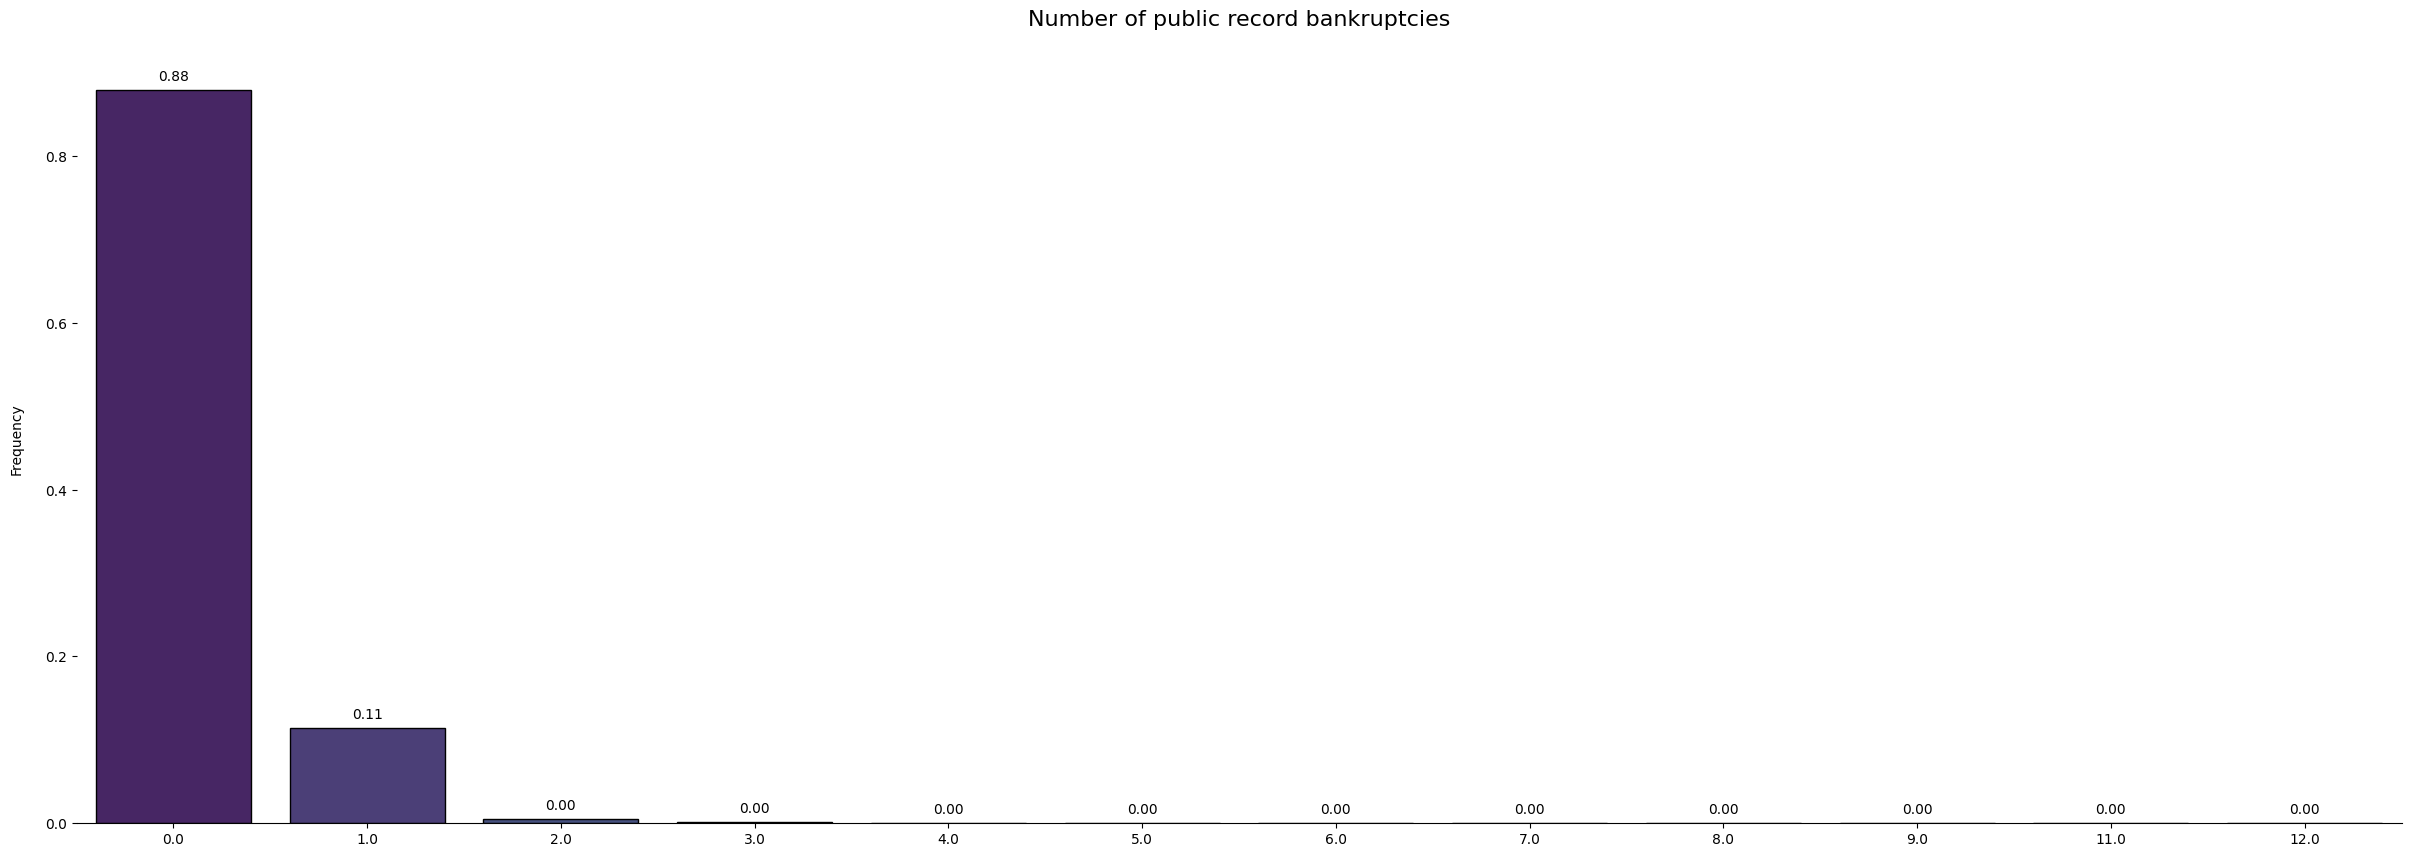

In [114]:
barplot(
    df["pub_rec_bankruptcies"], 
    "Number of public record bankruptcies",
    "Frequency",
    (30, 10)
)

Logically, we can assume that ```pub_rec``` $\approx$ ```pub_rec_bankruptcies```. Let's check this hypotesis

In [115]:
round(
    (df["pub_rec"].filter(mask) == df["pub_rec_bankruptcies"].filter(mask)).mean(), 
    3
)

0.937

It can be seen that the hypothesis is fulfilled. As we can see the values of these two features almost completely coincide, so we can delete ``pub_rec_bankruptcies``, since there are more missing values in this feature 

In [116]:
df = df.drop("pub_rec_bankruptcies")

As we can see we have a lot of categories with small presence, so when binning we will need to set a minimum bin size so that some of the categories will be merged together

# ```revol_bal``` and ```revol_util```

These features are responsible for 

- Total credit revolving balance
- Revolving line utilization rate, or the amount of credit the borrower is using

respectively

In [117]:
check_null_nan(df["revol_bal"])

Number of nulls: 0


In [118]:
check_null_nan(df["revol_util"])

Amount of NaN: 0
Number of nulls: 1773


In [119]:
(df["revol_bal"].filter(df["revol_util"].is_null()) == 0).mean()

0.8217710095882684

In [120]:
(df["revol_util"].filter(df["revol_bal"] == 0) == 0).mean()

0.9925063199711087

As we can see in the two cells above, we can select a subset of observations where ```revol_bal``` is equal to zero and ```revol_util``` is null and fill in the gaps in revol_util with zeros and delete the rest of the gaps 

In [121]:
mask = ((df["revol_bal"] == 0) & (df["revol_util"].is_null()))

print(df["revol_util"].is_null().sum() - mask.sum())

df = df.with_columns(
    pl.when(mask)
    .then(0)
    .otherwise(pl.col("revol_util"))
    .alias("revol_util")
)

316


In [122]:
mask = ~df["revol_util"].is_null()

df = df.filter(mask)
y = y.filter(mask)

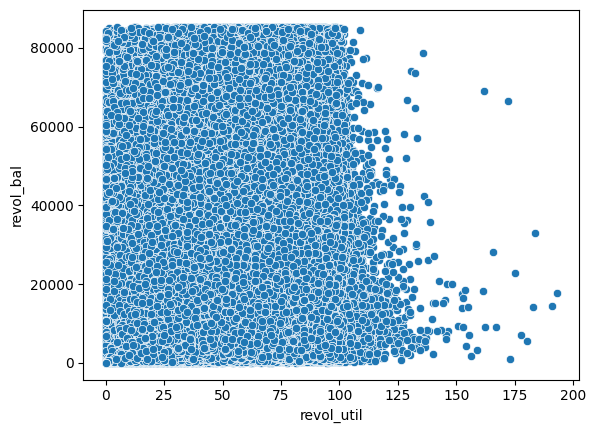

In [123]:
temp_mask = (
    (
        df["revol_bal"] <= (df["revol_bal"].mean() + 3 * df["revol_bal"].std())
    ) & (df["revol_util"] <= 200)
)
sns.scatterplot(x=df["revol_util"].filter(temp_mask), y=df["revol_bal"].filter(temp_mask));

# ```initial_list_status```

In [124]:
check_null_nan(df["initial_list_status"])

Number of nulls: 0


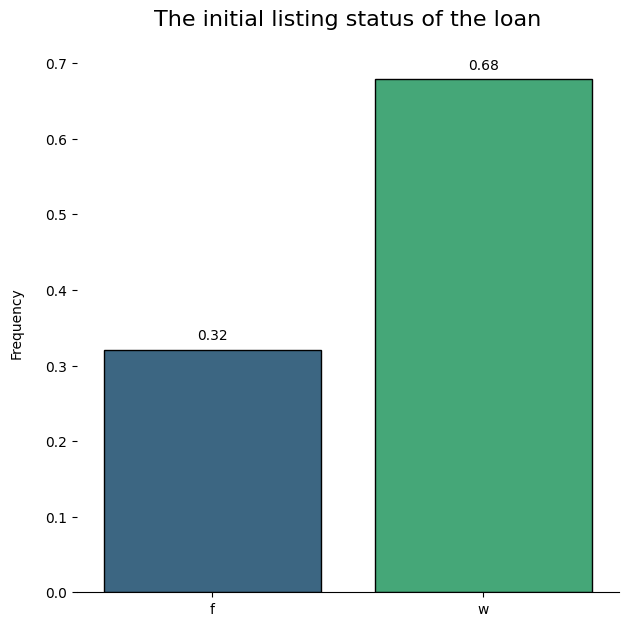

In [125]:
barplot(
    df["initial_list_status"],
    "The initial listing status of the loan",
    "Frequency",
    (7, 7)
)

# ```out_prncp``` and ```out_prncp_inv```

Here we are in the same situation as with ```funded_amnt``` 

In [126]:
df[["out_prncp", "out_prncp_inv"]].filter(df["out_prncp"] != df["out_prncp_inv"])

out_prncp,out_prncp_inv
f64,f64
14654.57,14630.15
5848.5,5824.13
7148.98,7125.15
4838.45,4821.17
8544.32,8520.58
…,…
31272.03,31250.32
6174.88,6144.01
12417.79,12386.74


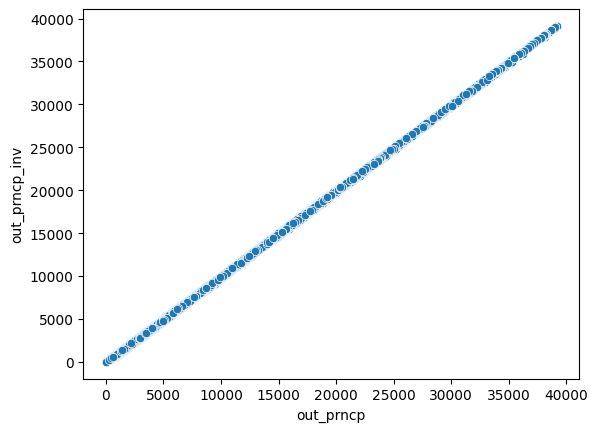

In [127]:
mask = df["out_prncp"] != df["out_prncp_inv"]

sns.scatterplot(x=df["out_prncp"].filter(mask), y=df["out_prncp_inv"].filter(mask));

In [128]:
check_null_nan(df["out_prncp"])

Amount of NaN: 0
Number of nulls: 0


In [129]:
check_null_nan(df["out_prncp_inv"])

Amount of NaN: 0
Number of nulls: 0


As we can see we can exclude ```out_prncp_inv``` from the dataset

In [130]:
df = df.drop("out_prncp_inv")

# ```total_pymnt```	and ```total_pymnt_inv```

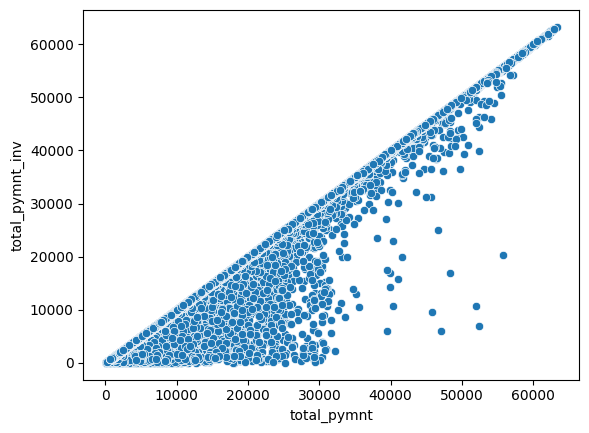

In [131]:
mask = df["total_pymnt"] != df["total_pymnt_inv"]

sns.scatterplot(x=df["total_pymnt"].filter(mask), y=df["total_pymnt_inv"].filter(mask));

In [132]:
mask.mean()

0.42541833659909367

In [133]:
check_null_nan(df["total_pymnt"])

Amount of NaN: 0
Number of nulls: 0


In [134]:
check_null_nan(df["total_pymnt_inv"])

Amount of NaN: 0
Number of nulls: 0


In this case we cannot simply remove one of the attributes , but according to the documentation these attributes are the same, so let's leave only ```total_pymnt```

In [135]:
df = df.drop("total_pymnt_inv")

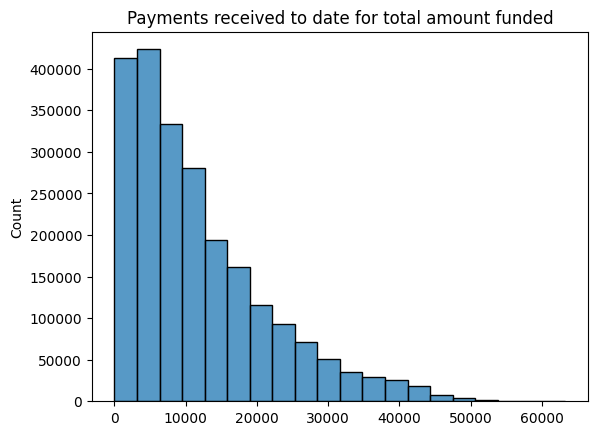

In [136]:
plt.title("Payments received to date for total amount funded")
sns.histplot(df["total_pymnt"], bins=20);

# ```total_rec_prncp```, ```total_rec_int``` and ```total_rec_late_fee```

As we can see these attributes are a decomposition of ```total_pymnt```

In [137]:
check_null_nan(df["total_rec_prncp"])

Amount of NaN: 0
Number of nulls: 0


In [138]:
check_null_nan(df["total_rec_int"])

Amount of NaN: 0
Number of nulls: 0


In [139]:
check_null_nan(df["total_rec_late_fee"])

Amount of NaN: 0
Number of nulls: 0


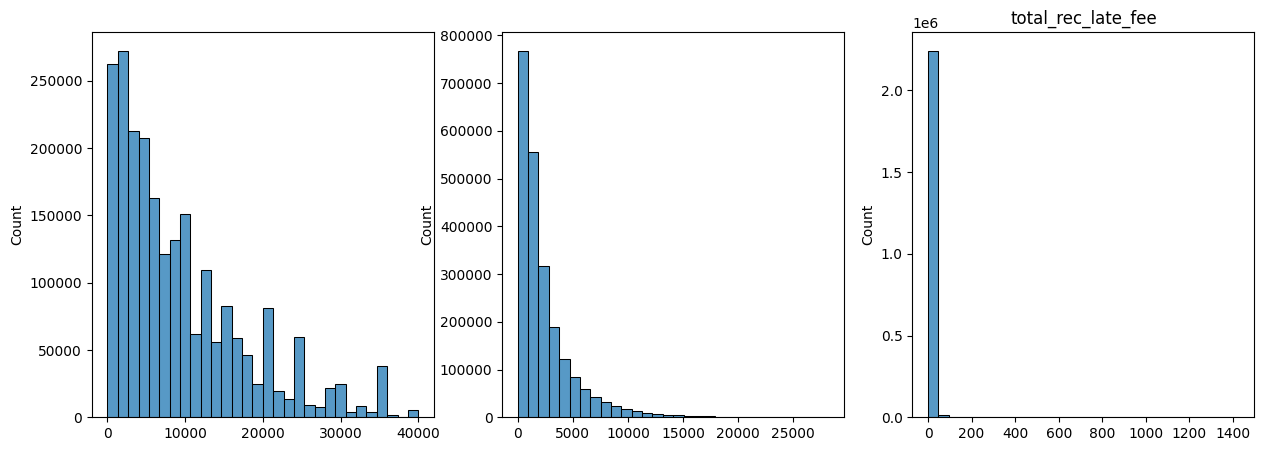

In [140]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, el in enumerate(["total_rec_prncp", "total_rec_int", "total_rec_late_fee"]):
    plt.title(el)
    sns.histplot(df[el], ax=ax[i], bins=30)

In [141]:
(df["total_rec_late_fee"] == 0).mean()

0.9626000023890412

We can remove the ```total_rec_late_fee``` since it consists almost entirely of zeros. 
So let's check the IV

In [142]:
binner = OptimalBinning(min_prebin_size=0.02)

binner.fit(df["total_rec_late_fee"], y)

binner.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.01)",2175893,0.962648,1928698,247195,0.113606,0.1306,0.015636,0.001953
1,"[0.01, inf)",84428,0.037352,43577,40851,0.483856,-1.859225,0.222598,0.024403
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2260321,1.000000,1972275,288046,0.127436,,0.238234,0.026356


In [143]:
print(binner.binning_table.iv)

0.23823437367556385


Let's leave that feature

# ```recoveries``` and ```collection_recovery_fee```

In [144]:
(df["recoveries"] == 0).mean()

0.921481063972772

In [145]:
check_iv(df["recoveries"], 
         y, 
         dict(min_prebin_size=0.01)
        )

IV: 0.00000


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",2260321,1.0,1972275,288046,0.127436,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,2260321,1.0,1972275,288046,0.127436,,0.0,0.0


In [146]:
(df["collection_recovery_fee"] == 0).mean()

0.9252061985886075

In [147]:
check_iv(df["collection_recovery_fee"], 
         y, 
         dict(min_prebin_size=0.01)
        )

IV: 0.00000


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",2260321,1.0,1972275,288046,0.127436,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,2260321,1.0,1972275,288046,0.127436,,0.0,0.0


We can remove these features since they consist almost entirely of zeros and have very small IV

In [148]:
df = df.drop(["collection_recovery_fee", "recoveries"])

# ```last_pymnt_d```, ```last_pymnt_amnt```, ```next_pymnt_d``` and ```last_credit_pull_d```

These features are not stationary and do not have much informative value for prediction, so let's remove them  

In [149]:
df = df.drop(["last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d"])

# ```collections_12_mths_ex_med```

In [150]:
(df["collections_12_mths_ex_med"] == 0).mean()

0.9834360157596325

Let's check for missing values and then we are goinh to find IV

In [151]:
check_null_nan(df["collections_12_mths_ex_med"])

Number of nulls: 116


In [152]:
mask = ~df["collections_12_mths_ex_med"].is_null()

check_iv(df["collections_12_mths_ex_med"].filter(mask), 
         y.filter(mask), 
         dict(min_prebin_size=0.001)
        )

IV: 0.00095


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",2222767,0.983436,1940545,282222,0.126969,0.004167,0.000017,0.000002
1,"[0.50, 1.50)",34684,0.015346,29334,5350,0.154250,-0.222213,0.000822,0.000103
2,"[1.50, inf)",2754,0.001218,2305,449,0.163036,-0.28805,0.000112,0.000014
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2260205,1.000000,1972184,288021,0.127431,,0.000952,0.000119


We will remove this feature since it consists almost entirely of zeros and has a very low IV 

In [153]:
df = df.drop("collections_12_mths_ex_med")

# ```mths_since_last_major_derog```

In [154]:
df["mths_since_last_major_derog"].is_null().mean()

0.7430926846231133

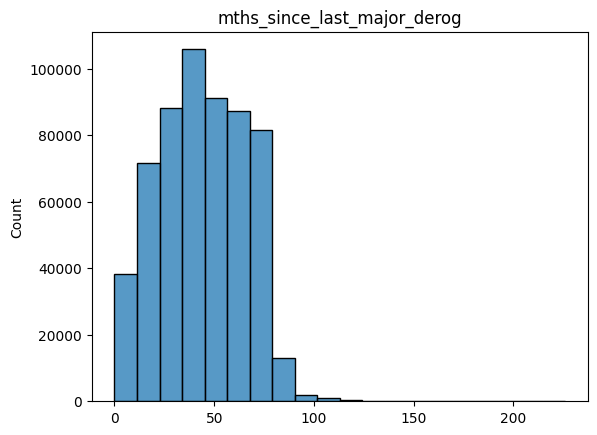

In [155]:
plt.title("mths_since_last_major_derog")
sns.histplot(df["mths_since_last_major_derog"], bins=20);

There are a lot of null in this feature, let's try to separate them into a separate group and check the IVs

In [156]:
check_iv(df["mths_since_last_major_derog"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.00760


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 23.50)",116980,0.051754,99214,17766,0.151872,-0.20383,0.002318,0.000289
1,"[23.50, 37.50)",114876,0.050823,98033,16843,0.146619,-0.162454,0.001424,0.000178
2,"[37.50, 64.50)",226640,0.100269,194749,31891,0.140712,-0.114435,0.001370,0.000171
3,"[64.50, inf)",122197,0.054062,105237,16960,0.138792,-0.098465,0.000544,0.000068
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,1679628,0.743093,1475042,204586,0.121804,0.051631,0.001943,0.000243
Totals,,2260321,1.000000,1972275,288046,0.127436,,0.007599,0.000949


We can easily remove this feature

In [157]:
df = df.drop("mths_since_last_major_derog")

# ```policy_code```

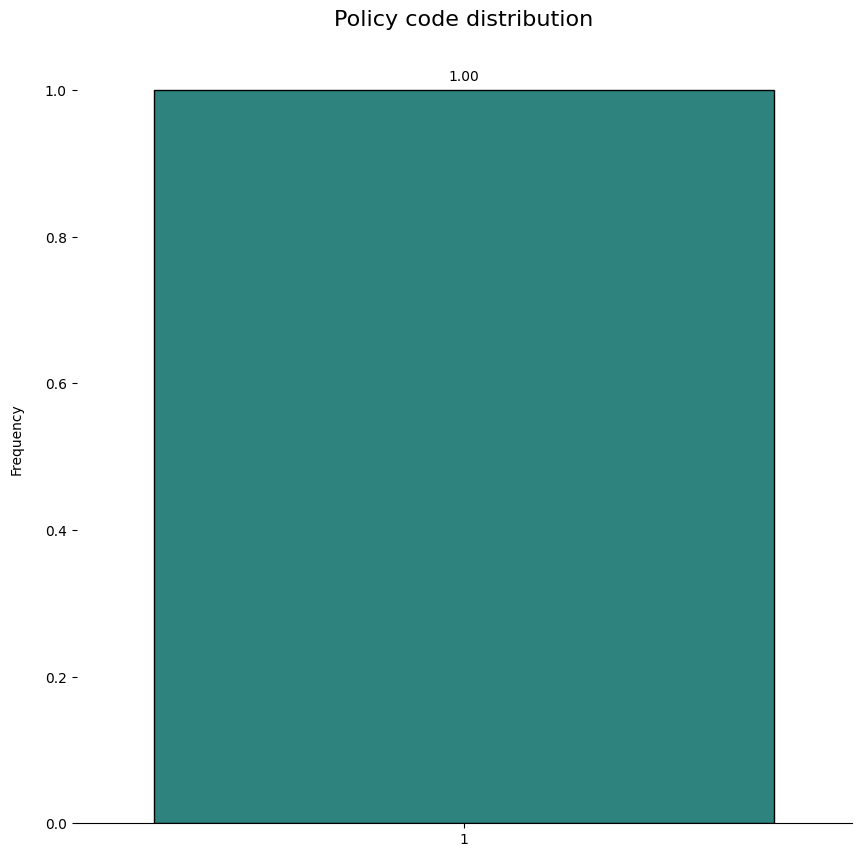

In [158]:
barplot(
    df["policy_code"], 
    "Policy code distribution",
    "Frequency",
    (10, 10)
)

In [159]:
df["policy_code"].is_null().mean()

0.0

In [160]:
df["policy_code"].unique()

policy_code
i64
1


As we can see this feature consists entirely of a single value, so we need to remove it

In [161]:
df = df.drop("policy_code")

# ```application_type```

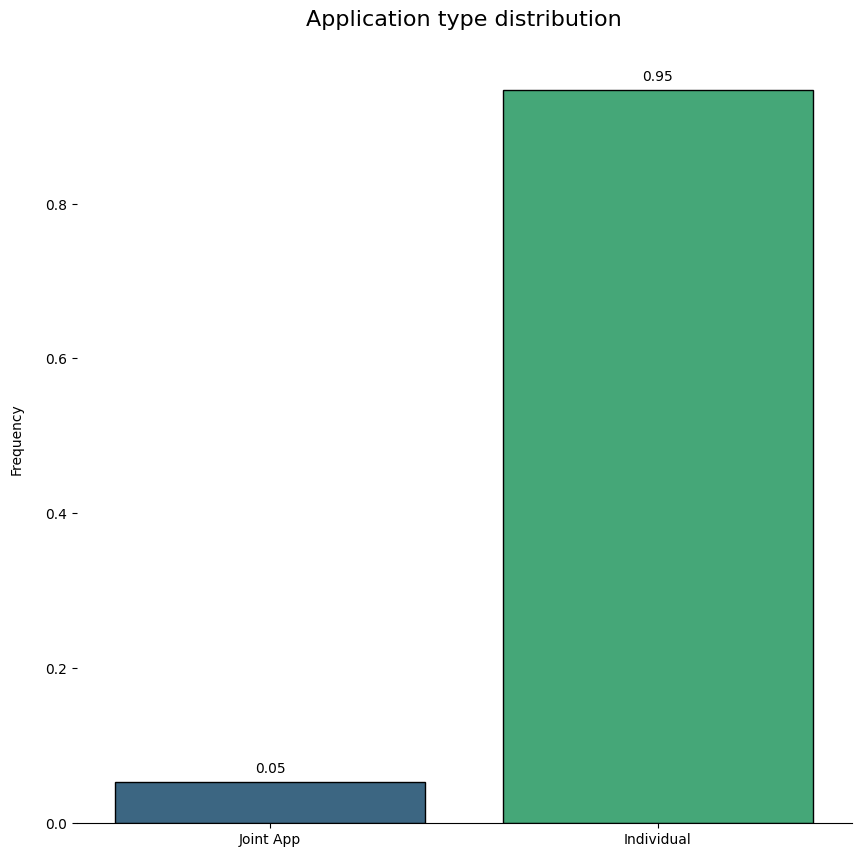

In [162]:
barplot(
    df["application_type"], 
    "Application type distribution",
    "Frequency",
    (10, 10)
)

In [163]:
df["application_type"].is_null().sum()

0

We can notice that we have two types of applications. Let's leave only individual applications

In [164]:
mask = df["application_type"] == "Joint App"

df = df.drop("application_type")

df = df.filter(~mask)
y = y.filter(~mask)

In [165]:
for el in df.columns:
    if "_joint" in el:
        print(f"Feature: {el} | Nuls share: {df[el].is_null().mean()}")

Feature: annual_inc_joint | Nuls share: 1.0
Feature: dti_joint | Nuls share: 1.0
Feature: verification_status_joint | Nuls share: 1.0
Feature: revol_bal_joint | Nuls share: 1.0


As we see for individual applications, part of the indications associated with group applications consist entirely of null. Let's delete them

In [166]:
df = df.drop(["annual_inc_joint", 
                      "dti_joint", 
                      "verification_status_joint", 
                      "revol_bal_joint" 
                     ]
                    )

In [167]:
counter = (df.null_count() / df.shape[0]) >= 0.985

null_columns = counter.select([
    pl.col(col)
    for col in counter.columns
    if counter[col][0]
]).columns
null_columns

['sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount']

If we look in the documentation we will see that the attributes with the note sec refer to the data of the second person submitting the application, which is applicable only for group applications, so let's remove these attributes

In [168]:
df = df.drop(null_columns)

# ```acc_now_delinq```

In [169]:
(df["acc_now_delinq"] == 0).mean()

0.9959834420975836

Without even checking the IV, let's remove this feature since it consists almost entirely of zeros 

In [170]:
df = df.drop("acc_now_delinq")

# ```tot_coll_amt```

In [171]:
check_null_nan(df["tot_coll_amt"])

Number of nulls: 70241


In [172]:
df["tot_coll_amt"].unique()

tot_coll_amt
i64
null
0
2
3
4
…
496651
932461
5252395


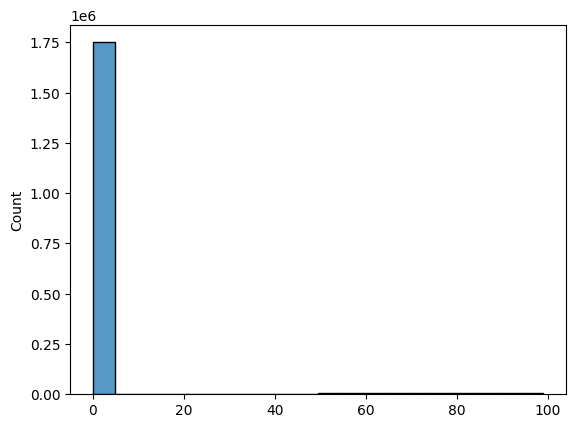

In [173]:
sns.histplot(df["tot_coll_amt"].filter(df["tot_coll_amt"] <  100), bins=20);

As you can see, there is a very large skew to zero in the data and also many missing values, let's check the IV and if it is small, we remove the feature

In [174]:
check_iv(df["tot_coll_amt"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.00393


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 7.50)",1750585,0.818167,1527323,223262,0.127536,0.028408,0.000653,0.000082
1,"[7.50, 275.50)",129915,0.060718,111008,18907,0.145534,-0.124448,0.000984,0.000123
2,"[275.50, inf)",188902,0.088287,162431,26471,0.140131,-0.080314,0.000587,0.000073
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,70241,0.032828,59165,11076,0.157686,-0.218968,0.001705,0.000213
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.003929,0.000491


In [175]:
df = df.drop("tot_coll_amt")

# ```tot_cur_bal```

In [176]:
check_null_nan(df["tot_cur_bal"])

Number of nulls: 70241


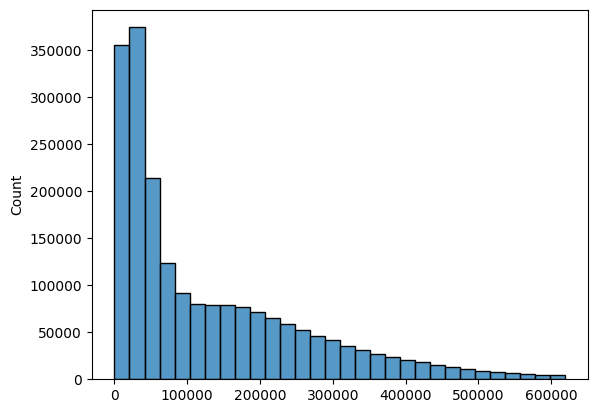

In [177]:
sns.histplot(
    df["tot_cur_bal"].filter(
        df["tot_cur_bal"] < (df["tot_cur_bal"].mean() + 3 * df["tot_cur_bal"].std())
    ), 
    bins=30
);

There are enough missing values in this feature to make it a separate group, check IV 

In [178]:
check_iv(df["tot_cur_bal"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.03372


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 9024.50)",118620,0.055439,104254,14366,0.121109,0.087448,0.000410,5.128845e-05
1,"[9024.50, 14628.50)",110394,0.051595,95445,14949,0.135415,-0.040612,0.000086,1.079677e-05
2,"[14628.50, 19778.50)",107387,0.050189,92337,15050,0.140147,-0.080451,0.000335,4.181384e-05
3,"[19778.50, 27862.50)",165877,0.077526,141495,24382,0.146988,-0.136098,0.001510,1.885451e-04
4,"[27862.50, 41590.50)",230537,0.107746,195876,34661,0.150349,-0.162651,0.003025,3.777709e-04
5,"[41590.50, 54185.50)",144914,0.067728,122418,22496,0.155237,-0.200414,0.002927,3.652873e-04
6,"[54185.50, 73114.50)",138726,0.064836,117848,20878,0.150498,-0.163818,0.001848,2.306921e-04
7,"[73114.50, 95294.50)",108702,0.050804,93204,15498,0.142573,-0.100438,0.000532,6.644391e-05
8,"[95294.50, 130961.50)",139175,0.065046,120815,18360,0.131920,-0.010432,0.000007,8.881908e-07
9,"[130961.50, 159788.50)",109900,0.051364,95984,13916,0.126624,0.036625,0.000068,8.495801e-06


IV is too small, so we remove this feature 

In [179]:
df = df.drop("tot_cur_bal")

# ```open_acc_6m``` and ```acc_open_past_24mths```

In [180]:
check_null_nan(df["open_acc_6m"])

Number of nulls: 865656


In [181]:
check_null_nan(df["acc_open_past_24mths"])

Number of nulls: 49997


There are many missing values in this feature, so instead of removing them, we should treat the missing values as a separate group 

In [182]:
mask = (~df["acc_open_past_24mths"].is_null() & ~df["open_acc_6m"].is_null())

(
    df["acc_open_past_24mths"].filter(mask) == df["open_acc_6m"].filter(mask)
).mean()

0.0735611901848292

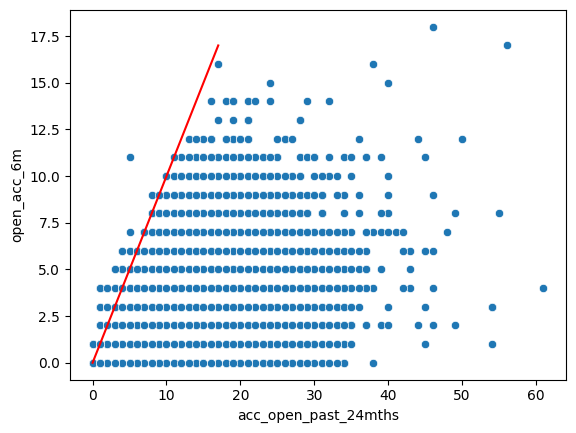

In [183]:
sns.scatterplot(x=df["acc_open_past_24mths"].filter(mask), y=df["open_acc_6m"].filter(mask))
x_y = range(df["open_acc_6m"].max())
plt.plot(x_y, x_y, color="red");

As we can see there is almost no relationship between these two variables, so we will check their IV and if it is within the normal range, we will leave both of them 

In [184]:
check_iv(df["open_acc_6m"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.12176


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",569993,0.266396,522341,47652,0.083601,0.499878,0.055227,0.006832
1,"[0.50, 1.50)",396841,0.185471,356169,40672,0.102489,0.275348,0.012691,0.001581
2,"[1.50, 2.50)",187919,0.087827,164940,22979,0.122281,0.076483,0.000499,0.000062
3,"[2.50, inf)",119234,0.055726,101472,17762,0.148968,-0.151796,0.001358,0.000170
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,865656,0.404580,715005,150651,0.174031,-0.337194,0.051982,0.006467
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.121757,0.015113


IV is not very large, but not small enough to remove this feature, so we leave it

In [185]:
check_iv(df["acc_open_past_24mths"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.08209


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",301095,0.140722,275295,25800,0.085687,0.472951,0.026380,0.003267
1,"[1.50, 2.50)",287100,0.134181,258679,28421,0.098993,0.313942,0.011765,0.001465
2,"[2.50, 3.50)",312577,0.146088,277150,35427,0.113338,0.162567,0.003635,0.000454
3,"[3.50, 4.50)",291060,0.136032,254075,36985,0.127070,0.032599,0.000143,0.000018
4,"[4.50, 5.50)",244901,0.114459,210955,33946,0.138611,-0.067644,0.000537,0.000067
5,"[5.50, 6.50)",191876,0.089677,162795,29081,0.151561,-0.172111,0.002829,0.000353
6,"[6.50, 7.50)",142138,0.066431,119016,23122,0.162673,-0.256044,0.004781,0.000596
7,"[7.50, 9.50)",171447,0.080129,141339,30108,0.175611,-0.348147,0.011017,0.001370
8,"[9.50, inf)",147452,0.068914,118270,29182,0.197908,-0.4951,0.020170,0.002496
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


We can remove this feature 

In [186]:
df = df.drop("acc_open_past_24mths")

# ```open_act_il```

In [187]:
check_null_nan(df["open_act_il"])

Number of nulls: 865656


In [188]:
check_iv(df["open_act_il"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.09819


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",150867,0.070510,136875,13992,0.092744,0.386065,0.009099,0.001130
1,"[0.50, 1.50)",328063,0.153326,296194,31869,0.097143,0.334863,0.015175,0.001888
2,"[1.50, 2.50)",306025,0.143026,274473,31552,0.103103,0.268698,0.009343,0.001164
3,"[2.50, 3.50)",190569,0.089066,169982,20587,0.108029,0.216515,0.003852,0.000481
4,"[3.50, 5.50)",157716,0.073711,140632,17084,0.108321,0.213486,0.003103,0.000387
5,"[5.50, inf)",140747,0.065781,126766,13981,0.099334,0.310126,0.005636,0.000702
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,865656,0.404580,715005,150651,0.174031,-0.337194,0.051982,0.006467
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.098190,0.012219


In [189]:
df = df.drop("open_act_il")

# ```open_il_12m``` and ```open_il_24m```

In [190]:
check_null_nan(df["open_il_12m"])

Number of nulls: 865656


In [191]:
check_null_nan(df["open_il_24m"])

Number of nulls: 865656


In [192]:
df.filter(
    df["open_il_24m"].is_null()
)["open_il_12m"].is_null().mean()

1.0

In [193]:
mask = (
    (~df["open_il_24m"].is_null()) & (~df["open_il_12m"].is_null())
)
(df["open_il_12m"].filter(mask) == df["open_il_24m"].filter(mask)).mean()

0.44698258302478755

As we can see these signs are quite different, so it is worth considering them separately 

In [194]:
check_iv(df["open_il_24m"], 
         y, 
         dict(min_prebin_size=0.025)
        )

IV: 0.11652


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",341990,0.159835,313487,28503,0.083345,0.503231,0.033539,4.148746e-03
1,"[0.50, 1.50)",402685,0.188202,365140,37545,0.093237,0.380223,0.023610,2.933550e-03
2,"[1.50, 2.50)",260764,0.121873,232872,27892,0.106963,0.227631,0.005802,7.237139e-04
3,"[2.50, 3.50)",135753,0.063447,119476,16277,0.119902,0.098845,0.000598,7.466860e-05
4,"[3.50, 4.50)",66502,0.031081,57707,8795,0.132252,-0.013323,0.000006,6.929697e-07
5,"[4.50, inf)",66293,0.030983,56240,10053,0.151645,-0.172761,0.000985,1.229882e-04
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
7,Missing,865656,0.404580,715005,150651,0.174031,-0.337194,0.051982,6.467087e-03
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.116521,1.447145e-02


In [195]:
check_iv(df["open_il_12m"], 
         y, 
         dict(min_prebin_size=0.025)
        )

IV: 0.11690


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",693446,0.324094,633018,60428,0.087142,0.454529,5.650345e-02,7.002754e-03
1,"[0.50, 1.50)",382402,0.178722,340933,41469,0.108443,0.212222,7.438504e-03,9.280720e-04
2,"[1.50, 2.50)",139450,0.065174,121254,18196,0.130484,0.002168,3.060930e-07,3.826162e-08
3,"[2.50, inf)",58689,0.027429,49717,8972,0.152874,-0.182279,9.742418e-04,1.216119e-04
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
5,Missing,865656,0.404580,715005,150651,0.174031,-0.337194,5.198157e-02,6.467087e-03
Totals,,2139643,1.000000,1859927,279716,0.130730,,1.168981e-01,1.451956e-02


Let's keep both features

# ```mths_since_rcnt_il```

In [196]:
check_null_nan(df["mths_since_rcnt_il"])

Number of nulls: 905256


There are a lot of missing values in this feature, so let's find its IV and remove it if possible

In [197]:
check_iv(df["mths_since_rcnt_il"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.11078


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3.50)",125424,0.058619,108724,16700,0.133148,-0.021114,0.000026,0.000003
1,"[3.50, 5.50)",107823,0.050393,94542,13281,0.123174,0.068192,0.000228,0.000029
2,"[5.50, 8.50)",162615,0.076001,143532,19083,0.117351,0.123242,0.001103,0.000138
3,"[8.50, 11.50)",141414,0.066092,126076,15338,0.108462,0.212034,0.002746,0.000343
4,"[11.50, 14.50)",135075,0.063130,121921,13154,0.097383,0.33213,0.006153,0.000766
5,"[14.50, 18.50)",129367,0.060462,117329,12038,0.093053,0.382396,0.007666,0.000952
6,"[18.50, 23.50)",113681,0.053131,103936,9745,0.085722,0.472503,0.009943,0.001231
7,"[23.50, inf)",318988,0.149085,293328,25660,0.080442,0.54184,0.035747,0.004415
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,905256,0.423087,750539,154717,0.170910,-0.315324,0.047169,0.005872


# ```total_bal_il```

In [198]:
check_null_nan(df["total_bal_il"])

Number of nulls: 865656


In [199]:
check_iv(df["total_bal_il"], 
         y, 
         dict(min_prebin_size=0.025)
        )

IV: 0.09932


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",144261,0.067423,131046,13215,0.091605,0.399678,0.009278,0.001152
1,"[0.50, 4164.50)",72902,0.034072,66717,6185,0.084840,0.483815,0.006657,0.000824
2,"[4164.50, 7684.50)",80799,0.037763,73167,7632,0.094457,0.365877,0.004410,0.000548
3,"[7684.50, 13582.50)",139336,0.065121,125528,13808,0.099099,0.312763,0.005669,0.000706
4,"[13582.50, 17887.50)",98458,0.046016,88500,9958,0.101140,0.290109,0.003476,0.000433
5,"[17887.50, 28043.50)",198345,0.092700,177592,20753,0.104631,0.25228,0.005371,0.000670
6,"[28043.50, inf)",539886,0.252325,482372,57514,0.106530,0.232169,0.012475,0.001556
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,865656,0.404580,715005,150651,0.174031,-0.337194,0.051982,0.006467
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.099318,0.012356


Let's delete this feature 

In [200]:
df = df.drop("total_bal_il")

# ```il_util```

In [201]:
check_null_nan(df["il_util"])

Number of nulls: 1048066


In [202]:
check_iv(df["il_util"], 
         y, 
         dict(min_prebin_size=0.025)
        )

IV: 0.08328


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 40.50)",132582,0.061965,122850,9732,0.073404,0.641027,0.020038,0.002463
1,"[40.50, 47.50)",58215,0.027208,53737,4478,0.076922,0.590408,0.007606,0.000937
2,"[47.50, 57.50)",114016,0.053287,104583,9433,0.082734,0.511249,0.011506,0.001423
3,"[57.50, 62.50)",73274,0.034246,66672,6602,0.090100,0.417895,0.005117,0.000635
4,"[62.50, 66.50)",66070,0.030879,59765,6305,0.095429,0.35456,0.003401,0.000423
5,"[66.50, 69.50)",55122,0.025762,49822,5300,0.096150,0.346232,0.002714,0.000338
6,"[69.50, 72.50)",57734,0.026983,51748,5986,0.103682,0.262445,0.001686,0.000210
7,"[72.50, 75.50)",59731,0.027916,53373,6358,0.106444,0.233073,0.001391,0.000173
8,"[75.50, 79.50)",80007,0.037393,71073,8934,0.111665,0.179326,0.001125,0.000140
9,"[79.50, 85.50)",119007,0.055620,104493,14514,0.121959,0.079489,0.000341,0.000043


In [203]:
df = df.drop("il_util")

# ```open_rv_12m``` and ```open_rv_24m```

In [204]:
check_null_nan(df["open_rv_12m"])

Number of nulls: 865656


In [205]:
check_null_nan(df["open_rv_24m"])

Number of nulls: 865656


In [206]:
(df["open_rv_12m"].is_null() & ~df["open_rv_24m"].is_null()).mean()

0.0

In [207]:
(~df["open_rv_12m"].is_null() & df["open_rv_24m"].is_null()).mean()

0.0

As we can see, we cannot use information from one feature to fill in the gaps in another feature 

In [208]:
check_iv(df["open_rv_12m"], 
         y, 
         dict(min_prebin_size=0.025)
        )

IV: 0.12180


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",461424,0.215655,423992,37432,0.081123,0.532671,0.050146,6.195148e-03
1,"[0.50, 1.50)",378066,0.176696,341108,36958,0.097755,0.327899,0.016812,2.092131e-03
2,"[1.50, 2.50)",219976,0.102810,194700,25276,0.114903,0.147087,0.002106,2.630199e-04
3,"[2.50, 3.50)",110985,0.051871,96616,14369,0.129468,0.011154,0.000006,8.032787e-07
4,"[3.50, inf)",103536,0.048389,88506,15030,0.145167,-0.121496,0.000747,9.330185e-05
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
6,Missing,865656,0.404580,715005,150651,0.174031,-0.337194,0.051982,6.467087e-03
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.121799,1.511149e-02


In [209]:
check_iv(df["open_rv_24m"], 
         y, 
         dict(min_prebin_size=0.025)
        )

IV: 0.13691


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",198989,0.093001,185203,13786,0.069280,0.703281,0.035368,0.004332
1,"[0.50, 1.50)",268547,0.125510,246763,21784,0.081118,0.532735,0.029191,0.003606
2,"[1.50, 2.50)",243479,0.113794,220741,22738,0.093388,0.378435,0.014151,0.001758
3,"[2.50, 3.50)",184822,0.086380,164774,20048,0.108472,0.211928,0.003586,0.000447
4,"[3.50, 4.50)",128844,0.060218,113344,15500,0.120301,0.09507,0.000525,0.000066
5,"[4.50, 5.50)",86564,0.040457,75497,11067,0.127848,0.025607,0.000026,0.000003
6,"[5.50, 7.50)",93034,0.043481,79908,13126,0.141088,-0.088237,0.000350,0.000044
7,"[7.50, inf)",69708,0.032579,58692,11016,0.158031,-0.221563,0.001734,0.000216
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,865656,0.404580,715005,150651,0.174031,-0.337194,0.051982,0.006467


We will leave this features, because we can treat nulls as a separate caegory

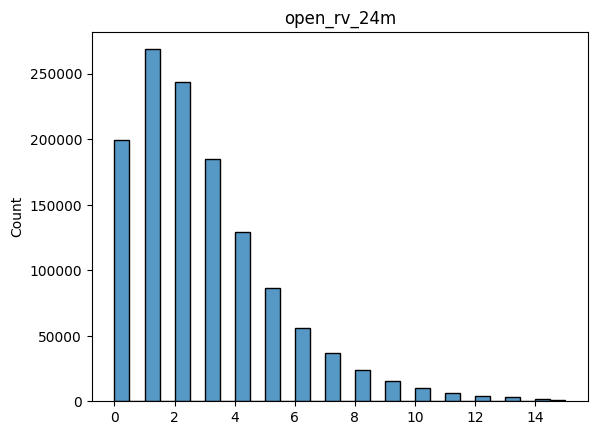

In [210]:
plt.title("open_rv_24m")
sns.histplot(df["open_rv_24m"].filter(df["open_rv_24m"] <= (df["open_rv_24m"].mean() + 5 * df["open_rv_24m"].std())), bins=30);

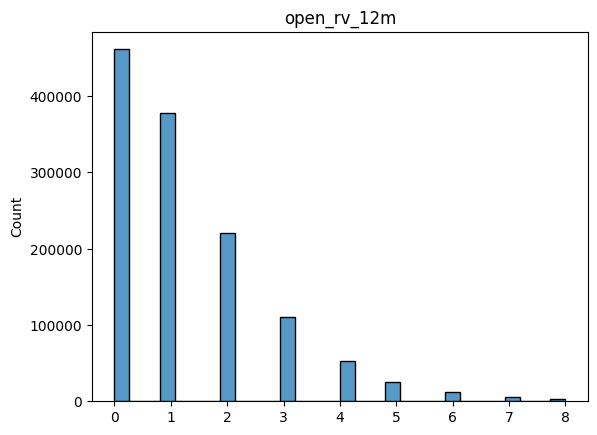

In [211]:
plt.title("open_rv_12m")
sns.histplot(df["open_rv_12m"].filter(df["open_rv_12m"] <= (df["open_rv_12m"].mean() + 5 * df["open_rv_12m"].std())), bins=30);

# ```max_bal_bc```

In [212]:
check_null_nan(df["max_bal_bc"])

Number of nulls: 865656


In [213]:
check_iv(df["max_bal_bc"], 
         y, 
         dict(min_prebin_size=0.025)
        )

IV: 0.10826


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2533.50)",357157,0.166924,316409,40748,0.114090,0.155111,0.003791,0.000473
1,"[2533.50, 3055.50)",85365,0.039897,75889,9476,0.111006,0.185992,0.001288,0.000161
2,"[3055.50, 3992.50)",139774,0.065326,124671,15103,0.108053,0.216267,0.002819,0.000352
3,"[3992.50, 5110.50)",154861,0.072377,138453,16408,0.105953,0.238244,0.003760,0.000469
4,"[5110.50, 6103.50)",103730,0.048480,93370,10360,0.099875,0.3041,0.004003,0.000498
5,"[6103.50, 7054.50)",79361,0.037091,71821,7540,0.095009,0.359437,0.004191,0.000521
6,"[7054.50, 7884.50)",56082,0.026211,50846,5236,0.093363,0.378726,0.003264,0.000406
7,"[7884.50, 10352.50)",121422,0.056749,110712,10710,0.088205,0.441237,0.009370,0.001162
8,"[10352.50, 12580.50)",56022,0.026183,51444,4578,0.081718,0.524714,0.005925,0.000732
9,"[12580.50, 15974.50)",53551,0.025028,49313,4238,0.079140,0.559579,0.006358,0.000785


We'll leave this attribute

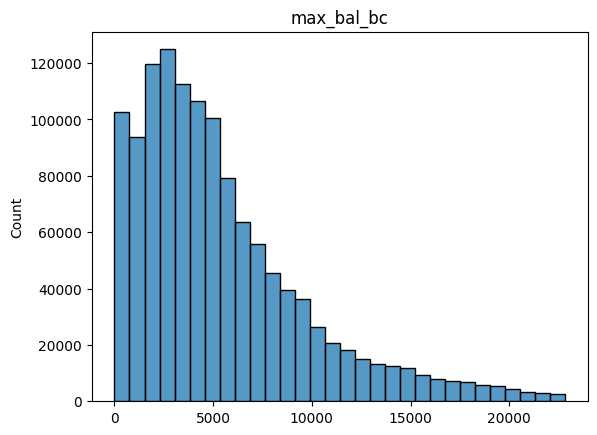

In [214]:
plt.title("max_bal_bc")
sns.histplot(df["max_bal_bc"].filter(df["max_bal_bc"] <= (df["max_bal_bc"].mean() + 3 * df["max_bal_bc"].std())), bins=30);

# ```all_util```

In [215]:
check_null_nan(df["all_util"])

Number of nulls: 865775


In [216]:
check_iv(df["all_util"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.13126


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 32.50)",162269,0.075839,151396,10873,0.067006,0.739099,0.031432,0.003842
1,"[32.50, 42.50)",146824,0.068621,135851,10973,0.074736,0.621603,0.021018,0.002586
2,"[42.50, 49.50)",136446,0.063770,124868,11578,0.084854,0.483633,0.012451,0.001541
3,"[49.50, 54.50)",110727,0.051750,100364,10363,0.093591,0.376044,0.006360,0.000790
4,"[54.50, 59.50)",118515,0.055390,106541,11974,0.101034,0.291275,0.004216,0.000525
5,"[59.50, 65.50)",143665,0.067144,128190,15475,0.107716,0.21977,0.002988,0.000373
6,"[65.50, 75.50)",211559,0.098876,186049,25510,0.120581,0.092422,0.000816,0.000102
7,"[75.50, inf)",243863,0.113974,211549,32314,0.132509,-0.015562,0.000028,0.000003
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,865775,0.404635,715119,150656,0.174013,-0.337068,0.051947,0.006463


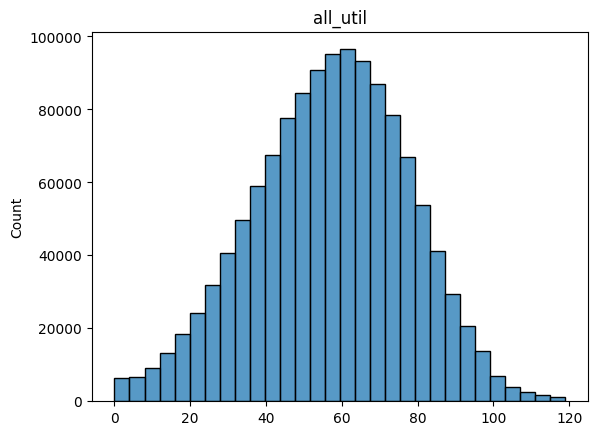

In [217]:
plt.title("all_util")
sns.histplot(df["all_util"].filter(df["all_util"] <= (df["all_util"].mean() + 3 * df["all_util"].std())), bins=30);

# ```total_rev_hi_lim```

In [218]:
check_null_nan(df["total_rev_hi_lim"])

Number of nulls: 70241


In [219]:
check_iv(df["total_rev_hi_lim"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.05022


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8150.50)",189056,0.088359,159512,29544,0.156271,-0.208279,0.004136,5.160923e-04
1,"[8150.50, 13697.00)",275892,0.128943,233767,42125,0.152687,-0.180834,0.004505,5.623757e-04
2,"[13697.00, 16477.00)",148842,0.069564,126617,22225,0.149319,-0.154569,0.001759,2.196412e-04
3,"[16477.00, 18692.50)",114302,0.053421,97631,16671,0.145850,-0.126993,0.000903,1.127561e-04
4,"[18692.50, 20894.50)",107938,0.050447,92330,15608,0.144602,-0.116932,0.000720,8.995324e-05
5,"[20894.50, 25874.50)",219108,0.102404,188377,30731,0.140255,-0.081344,0.000698,8.724903e-05
6,"[25874.50, 28971.50)",117615,0.054969,101813,15802,0.134354,-0.031516,0.000055,6.904547e-06
7,"[28971.50, 32471.00)",115640,0.054046,100678,14962,0.129384,0.011896,0.000008,9.518374e-07
8,"[32471.00, 37339.00)",137058,0.064056,119708,17350,0.126589,0.036945,0.000086,1.078031e-05
9,"[37339.00, 43990.50)",145158,0.067842,128206,16952,0.116783,0.128735,0.001072,1.338937e-04


Let's delete this feature

In [220]:
df = df.drop("total_rev_hi_lim")

# ```inq_fi```

In [221]:
check_null_nan(df["inq_fi"])

Number of nulls: 865656


In [222]:
check_iv(df["inq_fi"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.10561


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",638077,0.298217,578414,59663,0.093504,0.37706,0.036835,0.004577
1,"[0.50, 1.50)",322319,0.150641,290511,31808,0.098685,0.317406,0.013483,0.001678
2,"[1.50, 2.50)",157467,0.073595,140515,16952,0.107654,0.220411,0.003294,0.000411
3,"[2.50, inf)",156124,0.072967,135482,20642,0.132215,-0.013007,0.000012,0.000002
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,865656,0.404580,715005,150651,0.174031,-0.337194,0.051982,0.006467
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.105606,0.013135


We will leave yhis feature

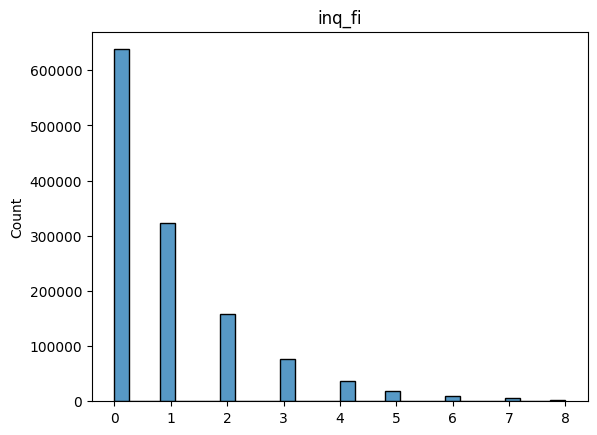

In [223]:
plt.title("inq_fi")
sns.histplot(df["inq_fi"].filter(df["inq_fi"] <= (df["inq_fi"].mean() + 5 * df["inq_fi"].std())), bins=30);

# ```total_cu_tl```

In [224]:
check_null_nan(df["total_cu_tl"])

Number of nulls: 865656


In [225]:
check_iv(df["total_cu_tl"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.09668


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",695877,0.325230,626185,69692,0.100150,0.301043,0.026347,0.003281
1,"[0.50, 1.50)",214372,0.100191,192761,21611,0.100811,0.293731,0.007748,0.000965
2,"[1.50, 3.50)",191193,0.089357,171758,19435,0.101651,0.284493,0.006505,0.000810
3,"[3.50, inf)",172545,0.080642,154218,18327,0.106216,0.235474,0.004096,0.000511
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,865656,0.404580,715005,150651,0.174031,-0.337194,0.051982,0.006467
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.096678,0.012034


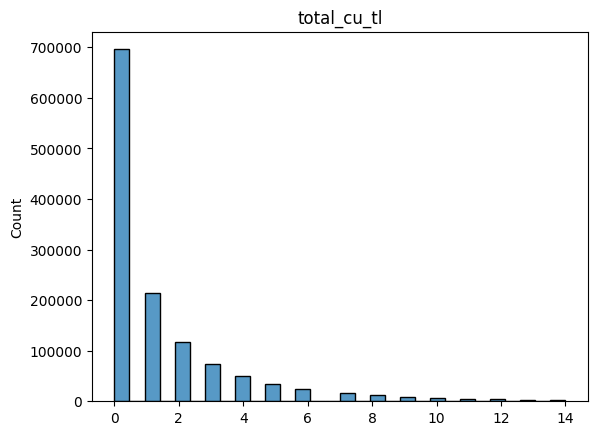

In [226]:
plt.title("total_cu_tl")
sns.histplot(df["total_cu_tl"].filter(df["total_cu_tl"] <= (df["total_cu_tl"].mean() + 5 * df["total_cu_tl"].std())), bins=30);

As we can see the IV of this feature is not large enough to be retained

In [227]:
df = df.drop("total_cu_tl")

# ```inq_last_12m```

In [228]:
check_null_nan(df["inq_last_12m"])

Number of nulls: 0


In [229]:
check_iv(df["inq_last_12m"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.00816


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",846951,0.395838,745992,100959,0.119203,0.105483,0.004235,0.000529
1,"[0.50, 1.50)",547053,0.255675,474252,72801,0.133079,-0.020509,0.000108,0.000014
2,"[1.50, 2.50)",308946,0.144391,266351,42595,0.137872,-0.06144,0.000558,0.000070
3,"[2.50, 4.50)",277043,0.129481,237511,39532,0.142693,-0.101414,0.001382,0.000173
4,"[4.50, inf)",159650,0.074615,135821,23829,0.149258,-0.154083,0.001874,0.000234
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.008158,0.001019


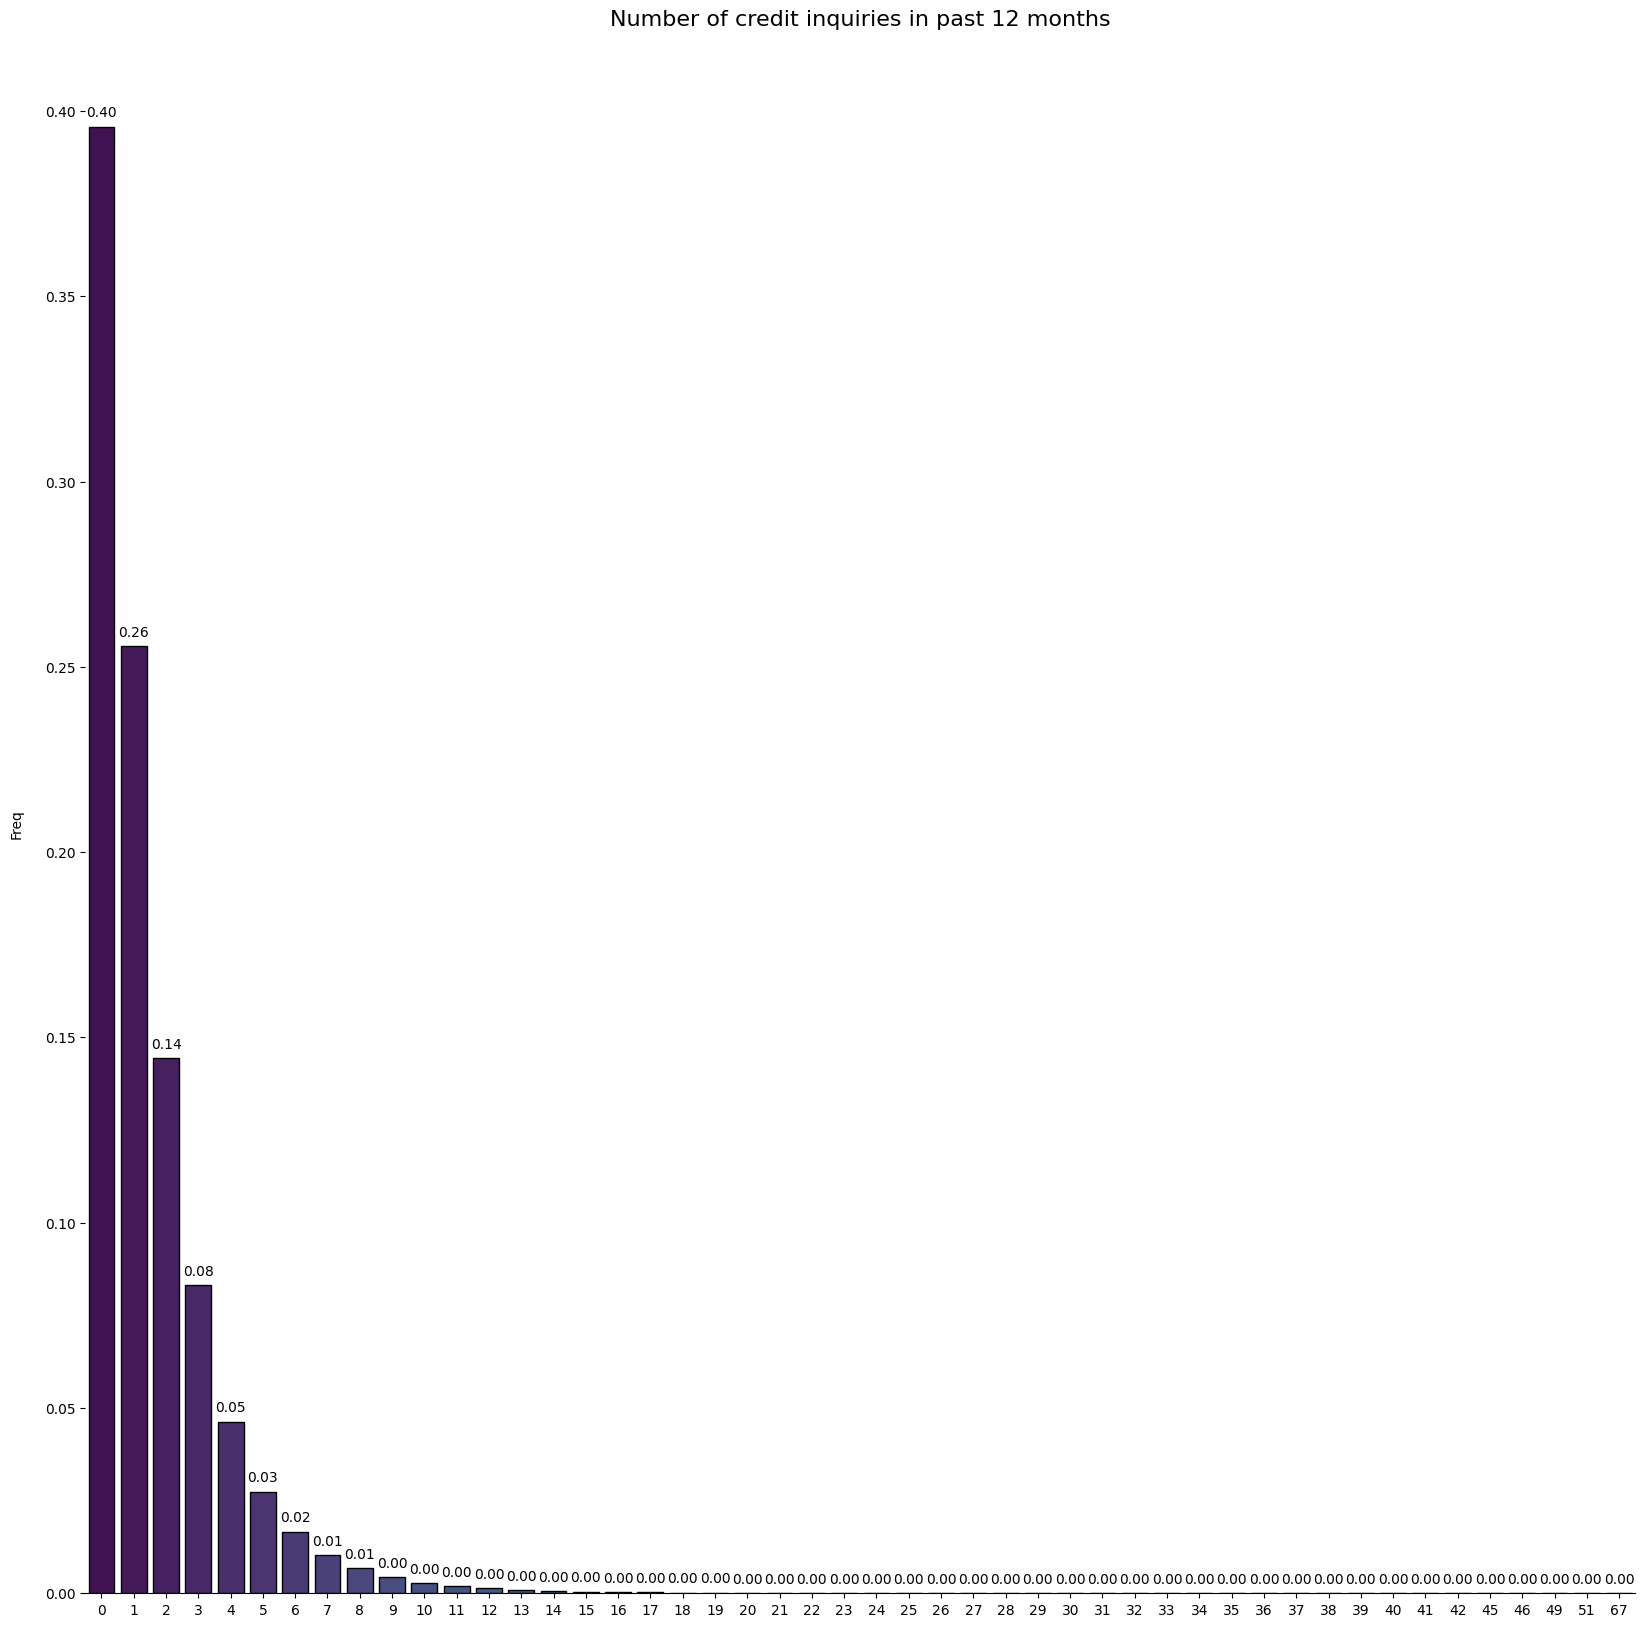

In [230]:
barplot(
    df["inq_last_12m"],
    "Number of credit inquiries in past 12 months",
    "Freq",
    (20, 20)
)

# ```avg_cur_bal```

In [231]:
check_null_nan(df["avg_cur_bal"])

Number of nulls: 70301


In [232]:
check_iv(df["avg_cur_bal"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.03826


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1115.50)",112049,0.052368,97223,14826,0.132317,-0.013893,0.000010,0.000001
1,"[1115.50, 1771.50)",131379,0.061402,112285,19094,0.145335,-0.122852,0.000969,0.000121
2,"[1771.50, 3247.50)",318081,0.148661,270674,47407,0.149041,-0.152372,0.003650,0.000456
3,"[3247.50, 3828.50)",107819,0.050391,91482,16337,0.151522,-0.171808,0.001584,0.000198
4,"[3828.50, 5314.50)",206739,0.096623,176113,30626,0.148138,-0.145241,0.002150,0.000268
5,"[5314.50, 6536.50)",115742,0.054094,99070,16672,0.144045,-0.112422,0.000713,0.000089
6,"[6536.50, 8343.50)",123452,0.057697,105952,17500,0.141756,-0.093732,0.000525,0.000066
7,"[8343.50, 10669.50)",122504,0.057254,106009,16495,0.134649,-0.034051,0.000067,0.000008
8,"[10669.50, 14047.50)",151479,0.070796,132186,19293,0.127364,0.02995,0.000063,0.000008
9,"[14047.50, 18469.50)",166915,0.078011,147054,19861,0.118989,0.107524,0.000867,0.000108


Let's remove this feature

In [233]:
df = df.drop("avg_cur_bal")

# ```bc_open_to_buy```

In [234]:
check_null_nan(df["bc_open_to_buy"])

Number of nulls: 71929


In [235]:
check_iv(df["bc_open_to_buy"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.09538


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 171.50)",107827,0.050395,87711,20116,0.186558,-0.421986,0.010447,0.001296
1,"[171.50, 514.50)",125905,0.058844,104914,20991,0.166721,-0.285471,0.005320,0.000663
2,"[514.50, 906.50)",107602,0.050290,89994,17608,0.163640,-0.263128,0.003832,0.000478
3,"[906.50, 1575.50)",148313,0.069317,124617,23696,0.159770,-0.234579,0.004155,0.000518
4,"[1575.50, 2250.50)",125814,0.058801,106020,19794,0.157327,-0.216269,0.002976,0.000371
5,"[2250.50, 2988.50)",119127,0.055676,100941,18186,0.152661,-0.180634,0.001941,0.000242
6,"[2988.50, 3960.50)",135676,0.063411,115546,20130,0.148368,-0.14706,0.001447,0.000181
7,"[3960.50, 5184.50)",141793,0.066269,121505,20288,0.143082,-0.104592,0.000753,0.000094
8,"[5184.50, 6927.50)",158383,0.074023,137332,21051,0.132912,-0.019064,0.000027,0.000003
9,"[6927.50, 8645.50)",122281,0.057150,106950,15331,0.125375,0.047967,0.000129,0.000016


Let's delete this feature too

In [236]:
df = df.drop("bc_open_to_buy")

# ```bc_util```

In [237]:
check_null_nan(df["bc_util"])

Amount of NaN: 0
Number of nulls: 72805


In [238]:
check_iv(df["bc_util"], 
         y, 
         dict(min_prebin_size=0.05)
        )

IV: 0.04806


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 17.85)",218237,0.101997,197706,20531,0.094077,0.370327,1.218313e-02,1.514249e-03
1,"[17.85, 25.95)",122510,0.057257,110904,11606,0.094735,0.362625,6.576590e-03,8.175990e-04
2,"[25.95, 32.95)",123202,0.057581,110791,12411,0.100737,0.294545,4.476309e-03,5.575247e-04
3,"[32.95, 38.65)",109356,0.051109,97332,12024,0.109953,0.196705,1.838139e-03,2.293977e-04
4,"[38.65, 43.95)",107335,0.050165,95112,12223,0.113877,0.157218,1.169639e-03,1.460544e-04
5,"[43.95, 53.95)",210501,0.098381,184906,25595,0.121591,0.082933,6.561817e-04,8.199922e-05
6,"[53.95, 58.95)",108540,0.050728,94393,14147,0.130339,0.003447,6.018401e-07,7.522997e-08
7,"[58.95, 63.95)",110147,0.051479,95622,14525,0.131869,-0.009986,5.152571e-06,6.440687e-07
8,"[63.95, 71.95)",179187,0.083746,154621,24566,0.137097,-0.054904,2.576080e-04,3.219696e-05
9,"[71.95, 78.95)",159718,0.074647,136915,22803,0.142770,-0.10205,8.070962e-04,1.008433e-04


Let's remove this feature

In [239]:
df = df.drop("bc_util")

# ```chargeoff_within_12_mths```

In [240]:
check_null_nan(df["chargeoff_within_12_mths"])

Number of nulls: 116


<Axes: ylabel='Count'>

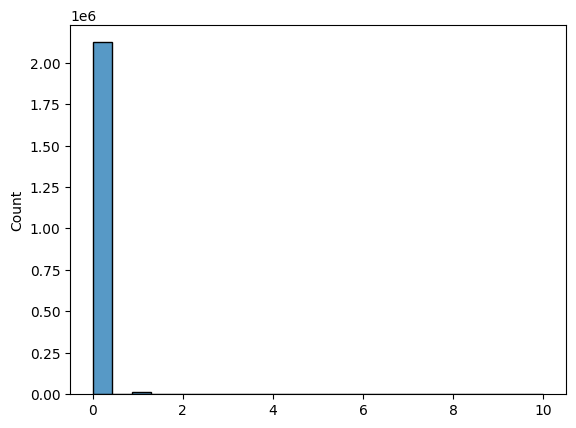

In [241]:
sns.histplot(df["chargeoff_within_12_mths"].filter(df["chargeoff_within_12_mths"] <= 15))

In [242]:
(df["chargeoff_within_12_mths"] == 0).mean()

0.9922314605050555

Since this sign consists almost entirely of zeros, let's remove it 

In [243]:
df = df.drop("chargeoff_within_12_mths")

# ```disbursement_method```

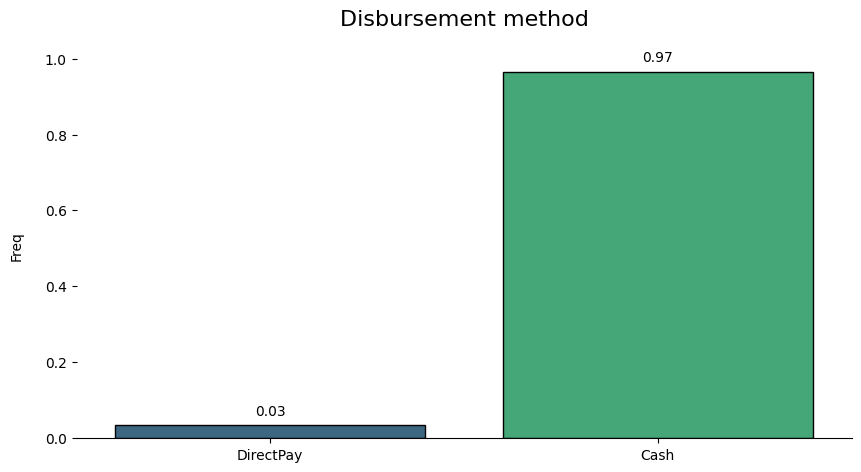

In [244]:
barplot(
    df["disbursement_method"],
    "Disbursement method",
    "Freq"
)

In [245]:
check_iv(df["disbursement_method"], 
         y, 
         dict(dtype="categorical", 
              min_prebin_size=0.01
             )
        )

IV: 0.05959


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[DirectPay],73133,0.03418,71393,1740,0.023792,1.819797,0.058532,0.006449
1,[Cash],2066510,0.96582,1788534,277976,0.134515,-0.032901,0.001058,0.000132
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2139643,1.00000,1859927,279716,0.130730,,0.059591,0.006582


# ```mo_sin_old_il_acct```

In [246]:
check_null_nan(df["mo_sin_old_il_acct"])

Number of nulls: 134834


In [247]:
check_iv(df["mo_sin_old_il_acct"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00724


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 33.50)",110552,0.051668,93600,16952,0.153340,-0.185873,0.001911,0.000238
1,"[33.50, 120.50)",677560,0.316670,585257,92303,0.136229,-0.047543,0.000728,0.000091
2,"[120.50, 126.50)",138836,0.064887,120025,18811,0.135491,-0.041259,0.000112,0.000014
3,"[126.50, 131.50)",117309,0.054826,101689,15620,0.133153,-0.021151,0.000025,0.000003
4,"[131.50, 136.50)",115251,0.053865,100743,14508,0.125882,0.043355,0.000100,0.000012
5,"[136.50, 144.50)",173668,0.081167,152144,21524,0.123938,0.061141,0.000297,0.000037
6,"[144.50, inf)",671633,0.313900,591237,80396,0.119702,0.100735,0.003069,0.000383
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,134834,0.063017,115232,19602,0.145379,-0.123202,0.001001,0.000125
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.007242,0.000905


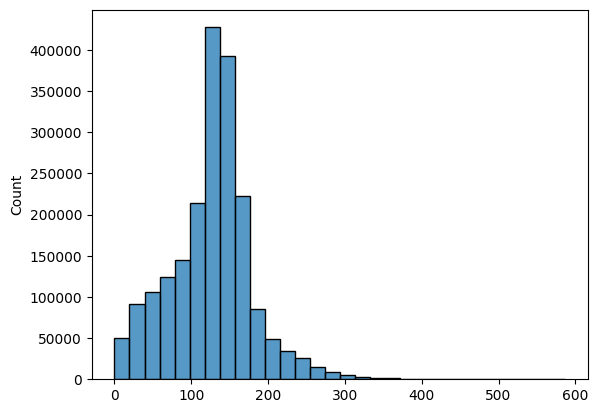

In [248]:
sns.histplot(df["mo_sin_old_il_acct"].filter(df["mo_sin_old_il_acct"] <= 600), bins=30);

Let's remove this feature

In [249]:
df = df.drop("mo_sin_old_il_acct")

# ```mo_sin_old_rev_tl_op``` and ```mo_sin_rcnt_rev_tl_op``` and ```mo_sin_rcnt_tl```

In [250]:
check_null_nan(df["mo_sin_old_rev_tl_op"])

Number of nulls: 70242


In [251]:
check_null_nan(df["mo_sin_rcnt_rev_tl_op"])

Number of nulls: 70242


In [252]:
check_null_nan(df["mo_sin_rcnt_tl"])

Number of nulls: 70241


In [253]:
mask = (
    df["mo_sin_old_rev_tl_op"].is_null() &
    df["mo_sin_rcnt_rev_tl_op"].is_null() &
    df["mo_sin_rcnt_tl"].is_null()
)

mask.sum()

70241

In [254]:
(df["mo_sin_rcnt_tl"] == df["mo_sin_rcnt_rev_tl_op"]).mean()

0.640662201284333

In [255]:
check_iv(df["mo_sin_old_rev_tl_op"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.01775


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 50.50)",110425,0.051609,93300,17125,0.155083,-0.199237,0.002203,2.749793e-04
1,"[50.50, 123.50)",484971,0.226660,413423,71548,0.147530,-0.140415,0.004705,5.876606e-04
2,"[123.50, 133.50)",114483,0.053506,98519,15964,0.139444,-0.074604,0.000306,3.825288e-05
3,"[133.50, 144.50)",125532,0.058670,108965,16567,0.131974,-0.010904,0.000007,8.754286e-07
4,"[144.50, 154.50)",107390,0.050191,93649,13741,0.127954,0.024652,0.000030,3.778048e-06
5,"[154.50, 190.50)",333651,0.155938,290988,42663,0.127867,0.025432,0.000100,1.248927e-05
6,"[190.50, 210.50)",148144,0.069238,130062,18082,0.122057,0.078577,0.000415,5.189053e-05
7,"[210.50, 262.50)",275931,0.128961,243277,32654,0.118341,0.113716,0.001599,1.997389e-04
8,"[262.50, 330.50)",197716,0.092406,175916,21800,0.110259,0.193579,0.003222,4.021620e-04
9,"[330.50, inf)",171158,0.079994,152663,18495,0.108058,0.216215,0.003451,4.304958e-04


In [256]:
check_iv(df["mo_sin_rcnt_rev_tl_op"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.04171


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",163208,0.076278,136103,27105,0.166076,-0.280824,0.006663,0.000830
1,"[1.50, 2.50)",159974,0.074767,135495,24479,0.153019,-0.183399,0.002689,0.000336
2,"[2.50, 3.50)",153822,0.071891,130936,22886,0.148782,-0.150334,0.001717,0.000214
3,"[3.50, 4.50)",140538,0.065683,120423,20115,0.143129,-0.104973,0.000752,0.000094
4,"[4.50, 5.50)",126435,0.059092,108815,17620,0.139360,-0.073903,0.000332,0.000041
5,"[5.50, 7.50)",214677,0.100333,184973,29704,0.138366,-0.06559,0.000442,0.000055
6,"[7.50, 9.50)",173060,0.080883,149834,23226,0.134208,-0.030262,0.000075,0.000009
7,"[9.50, 11.50)",142631,0.066661,124168,18463,0.129446,0.011349,0.000009,0.000001
8,"[11.50, 13.50)",122147,0.057088,106596,15551,0.127314,0.030403,0.000052,0.000007
9,"[13.50, 16.50)",138956,0.064944,121736,17220,0.123924,0.061266,0.000238,0.000030


In [257]:
check_iv(df["mo_sin_rcnt_tl"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.04728


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",204562,0.095606,170833,33729,0.164884,-0.272189,7.821009e-03,9.746193e-04
1,"[1.50, 2.50)",223536,0.104474,189187,34349,0.153662,-0.188355,3.970916e-03,4.956321e-04
2,"[2.50, 3.50)",216508,0.101189,184236,32272,0.149057,-0.1525,2.488599e-03,3.107738e-04
3,"[3.50, 4.50)",192487,0.089962,165533,26954,0.140030,-0.079479,5.851468e-04,7.312410e-05
4,"[4.50, 5.50)",166180,0.077667,143668,22512,0.135468,-0.041061,1.329453e-04,1.661699e-05
5,"[5.50, 6.50)",143913,0.067260,124945,18968,0.131802,-0.009397,5.960502e-06,7.450601e-07
6,"[6.50, 7.50)",128341,0.059982,111617,16724,0.130309,0.003711,8.248463e-07,1.031057e-07
7,"[7.50, 8.50)",108837,0.050867,95217,13620,0.125141,0.050101,1.253389e-04,1.566572e-05
8,"[8.50, 11.50)",237085,0.110806,209371,27714,0.116895,0.127652,1.722082e-03,2.151143e-04
9,"[11.50, 14.50)",156639,0.073208,140139,16500,0.105338,0.244757,4.003755e-03,4.992239e-04


As we can see all these features do not have much predictive value 

In [258]:
df = df.drop(["mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl"])

# ```mort_acc```

In [259]:
check_null_nan(df["mort_acc"])

Number of nulls: 49997


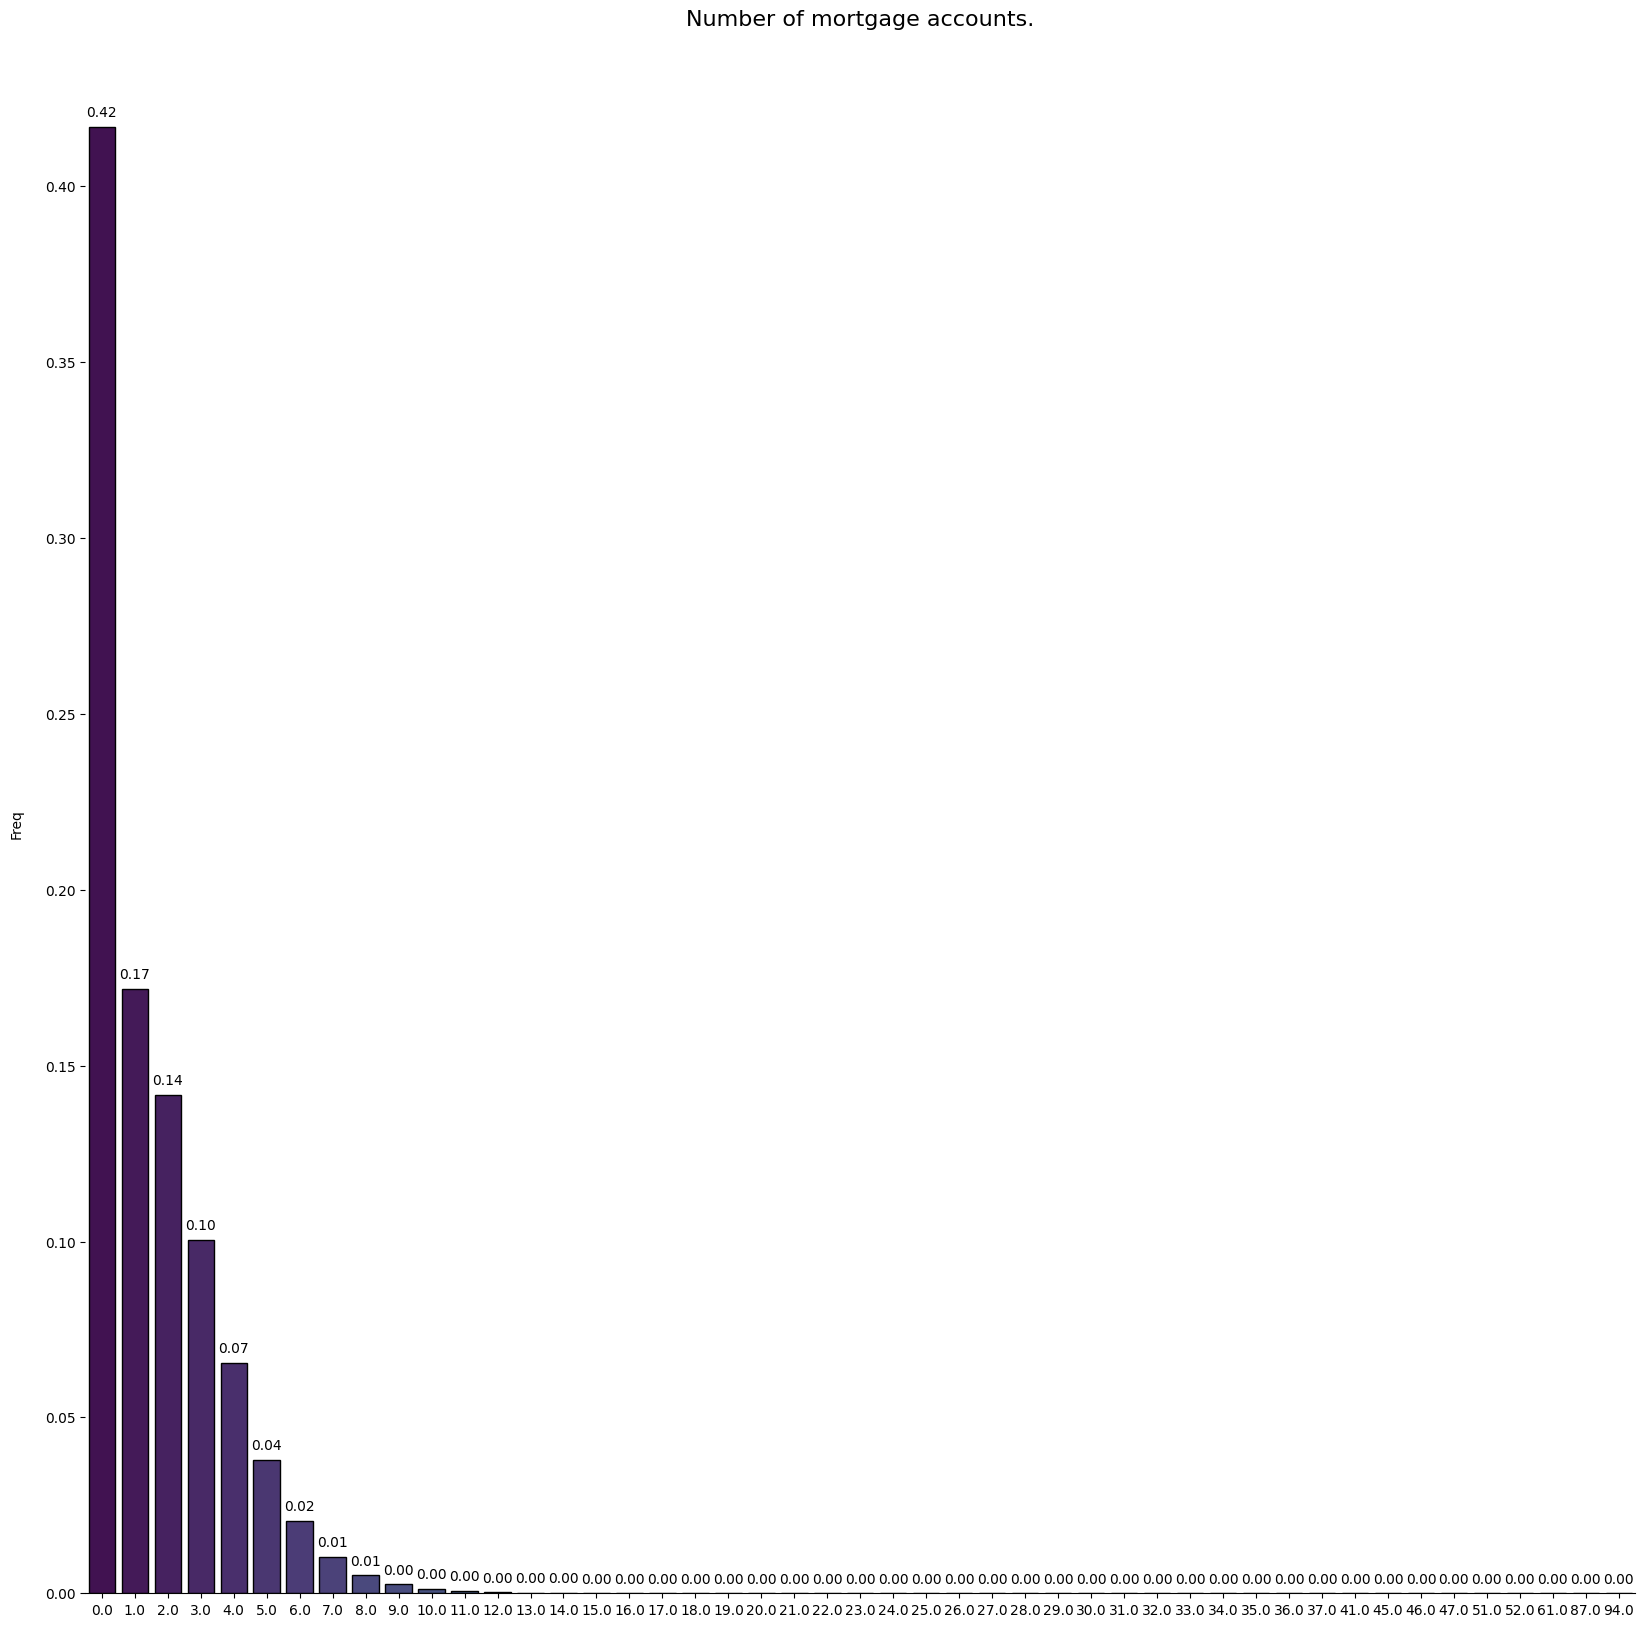

In [260]:
barplot(
    df["mort_acc"],
    "Number of mortgage accounts.",
    "Freq",
    (20, 20)
)

In [261]:
check_iv(df["mort_acc"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.01640


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",892205,0.416988,762587,129618,0.145278,-0.122393,0.006534,0.000816
1,"[0.50, 1.50)",367802,0.171899,320075,47727,0.129763,0.00854,0.000012,0.000002
2,"[1.50, 2.50)",303357,0.141779,267627,35730,0.117782,0.119086,0.001924,0.000240
3,"[2.50, 3.50)",215203,0.100579,190745,24458,0.113651,0.159462,0.002410,0.000301
4,"[3.50, 4.50)",140257,0.065552,124578,15679,0.111788,0.178092,0.001946,0.000243
5,"[4.50, inf)",170822,0.079837,151962,18860,0.110407,0.192069,0.002742,0.000342
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,49997,0.023367,42353,7644,0.152889,-0.182399,0.000831,0.000104
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.016400,0.002048


In [262]:
df = df.drop("mort_acc")

# ```mths_since_recent_bc```

In [263]:
check_null_nan(df["mths_since_recent_bc"])

Number of nulls: 70554


<Axes: ylabel='Count'>

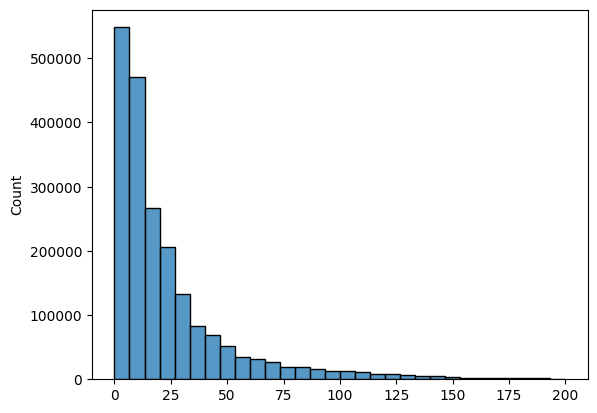

In [264]:
sns.histplot(df["mths_since_recent_bc"].filter(df["mths_since_recent_bc"] <= 200), bins=30)

In [265]:
check_iv(df["mths_since_recent_bc"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.03069


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3.50)",277878,0.129871,233886,43992,0.158314,-0.223692,0.007052,8.796159e-04
1,"[3.50, 5.50)",186380,0.087108,159116,27264,0.146282,-0.130451,0.001555,1.942462e-04
2,"[5.50, 8.50)",238738,0.111578,204420,34318,0.143748,-0.110011,0.001406,1.756704e-04
3,"[8.50, 10.50)",135159,0.063169,116366,18793,0.139044,-0.071262,0.000329,4.115550e-05
4,"[10.50, 14.50)",235370,0.110004,202847,32523,0.138178,-0.064013,0.000462,5.767966e-05
5,"[14.50, 17.50)",137199,0.064122,119098,18101,0.131932,-0.010538,0.000007,8.935961e-07
6,"[17.50, 22.50)",174124,0.081380,152407,21717,0.124721,0.053941,0.000232,2.901027e-05
7,"[22.50, 28.50)",152451,0.071251,134662,17789,0.116687,0.12967,0.001142,1.426200e-04
8,"[28.50, 35.50)",119937,0.056055,106400,13537,0.112868,0.167261,0.001474,1.840035e-04
9,"[35.50, 56.50)",191069,0.089299,170913,20156,0.105491,0.243135,0.004822,6.012972e-04


In [266]:
df = df.drop("mths_since_recent_bc")

# ```mths_since_recent_inq```

In [267]:
check_null_nan(df["mths_since_recent_inq"])

Number of nulls: 279231


In [268]:
check_iv(df["mths_since_recent_inq"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.04644


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",160924,0.075211,133024,27900,0.173374,-0.332615,9.387369e-03,1.168042e-03
1,"[0.50, 1.50)",202585,0.094682,168406,34179,0.168714,-0.299751,9.486347e-03,1.181374e-03
2,"[1.50, 2.50)",164917,0.077077,139788,25129,0.152374,-0.178413,2.619064e-03,3.269495e-04
3,"[2.50, 3.50)",149250,0.069755,127291,21959,0.147129,-0.137219,1.381235e-03,1.725191e-04
4,"[3.50, 4.50)",136312,0.063708,117372,18940,0.138946,-0.070445,3.244599e-04,4.054910e-05
5,"[4.50, 5.50)",120965,0.056535,104774,16191,0.133849,-0.027168,4.214760e-05,5.268288e-06
6,"[5.50, 6.50)",108666,0.050787,94449,14217,0.130832,-0.000896,4.079896e-08,5.099869e-09
7,"[6.50, 8.50)",194468,0.090888,169668,24800,0.127527,0.028482,7.295944e-05,9.119621e-06
8,"[8.50, 10.50)",151620,0.070862,133260,18360,0.121092,0.08761,5.265334e-04,6.579564e-05
9,"[10.50, 12.50)",122316,0.057167,108345,13971,0.114221,0.153819,1.277498e-03,1.595300e-04


In [269]:
df = df.drop("mths_since_recent_inq")

# ```num_accts_ever_120_pd```

In [270]:
check_null_nan(df["num_accts_ever_120_pd"])

Number of nulls: 70241


In [271]:
check_iv(df["num_accts_ever_120_pd"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00572


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",1589532,0.742896,1389594,199938,0.125784,0.044242,0.001430,0.000179
1,"[0.50, inf)",479870,0.224276,411168,68702,0.143168,-0.105294,0.002585,0.000323
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,70241,0.032828,59165,11076,0.157686,-0.218968,0.001705,0.000213
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.005720,0.000714


In [272]:
df = df.drop("num_accts_ever_120_pd")

# ```num_tl_120dpd_2m``` and ```num_tl_30dpd```

In [273]:
check_null_nan(df["num_tl_120dpd_2m"])

Number of nulls: 153621


In [274]:
check_null_nan(df["num_tl_30dpd"])

Number of nulls: 70241


In [275]:
(df["num_tl_30dpd"].is_null() & ~df["num_tl_120dpd_2m"].is_null()).sum()

0

In [276]:
(df["num_tl_30dpd"] == df["num_tl_120dpd_2m"]).mean()

0.9966440452321274

As we can see these features are almost completely identical 

In [277]:
check_iv(df["num_tl_30dpd"], 
         y, 
         dict( 
              min_prebin_size=0.01
             )
        )

IV: 0.00177


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",2069402,0.967172,1800762,268640,0.129815,0.008075,0.000063,0.000008
1,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
2,Missing,70241,0.032828,59165,11076,0.157686,-0.218968,0.001705,0.000213
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.001768,0.000221


In [278]:
check_iv(df["num_tl_120dpd_2m"], 
         y, 
         dict( 
              min_prebin_size=0.01
             )
        )

IV: 0.00764


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",1986022,0.928203,1732155,253867,0.127827,0.025793,0.000612,0.000076
1,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
2,Missing,153621,0.071797,127772,25849,0.168265,-0.296542,0.007032,0.000876
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.007644,0.000952


In [279]:
df = df.drop(["num_tl_120dpd_2m", "num_tl_30dpd"])

# ```num_actv_bc_tl```

In [280]:
check_null_nan(df["num_actv_bc_tl"])

Number of nulls: 70241


In [281]:
check_iv(df["num_actv_bc_tl"], 
         y, 
         dict( 
              min_prebin_size=0.01
             )
        )

IV: 0.00683


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",279841,0.130789,246187,33654,0.120261,0.095442,0.001150,0.000144
1,"[1.50, 2.50)",415406,0.194147,365192,50214,0.120879,0.089612,0.001508,0.000188
2,"[2.50, 3.50)",435028,0.203318,379597,55431,0.127419,0.029453,0.000174,0.000022
3,"[3.50, 4.50)",340596,0.159184,295411,45185,0.132665,-0.016915,0.000046,0.000006
4,"[4.50, 5.50)",230055,0.107520,198303,31752,0.138019,-0.062677,0.000432,0.000054
5,"[5.50, 6.50)",145810,0.068147,125542,20268,0.139003,-0.070921,0.000352,0.000044
6,"[6.50, 7.50)",87912,0.041087,75469,12443,0.141539,-0.091954,0.000359,0.000045
7,"[7.50, inf)",134754,0.062980,115061,19693,0.146140,-0.129319,0.001104,0.000138
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,70241,0.032828,59165,11076,0.157686,-0.218968,0.001705,0.000213


In [282]:
df = df.drop("num_actv_bc_tl")

# ```num_bc_tl``` and ```num_bc_sats```

In [283]:
check_null_nan(df["num_bc_tl"])

Number of nulls: 70241


In [284]:
check_null_nan(df["num_bc_sats"])

Number of nulls: 58557


In [285]:
check_iv(df["num_bc_tl"], 
         y, 
         dict( 
              min_prebin_size=0.01
             )
        )

IV: 0.00316


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",47961,0.022415,41553,6408,0.133609,-0.025095,0.000014,1.780932e-06
1,"[1.50, 2.50)",109799,0.051317,96112,13687,0.124655,0.05455,0.000150,1.870405e-05
2,"[2.50, 3.50)",170054,0.079478,148895,21159,0.124425,0.056658,0.000250,3.122612e-05
3,"[3.50, 4.50)",207598,0.097025,181599,25999,0.125237,0.049225,0.000231,2.885445e-05
4,"[4.50, 5.50)",217120,0.101475,189605,27515,0.126727,0.035694,0.000128,1.594784e-05
5,"[5.50, 6.50)",210262,0.098270,183470,26792,0.127422,0.02943,0.000084,1.052380e-05
6,"[6.50, 7.50)",193283,0.090334,168517,24766,0.128133,0.023047,0.000048,5.946872e-06
7,"[7.50, 8.50)",171664,0.080230,149363,22301,0.129911,0.00723,0.000004,5.228842e-07
8,"[8.50, 9.50)",145485,0.067995,126259,19226,0.132151,-0.012446,0.000011,1.322608e-06
9,"[9.50, 13.50)",364575,0.170391,315468,49107,0.134697,-0.034462,0.000205,2.561741e-05


In [286]:
check_iv(df["num_bc_sats"], 
         y, 
         dict( 
              min_prebin_size=0.01
             )
        )

IV: 0.00150


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",440705,0.205971,384500,56205,0.127534,0.02842,1.646276e-04,2.057775e-05
1,"[2.50, 3.50)",359067,0.167816,313085,45982,0.128060,0.023707,9.349349e-05,1.168641e-05
2,"[3.50, 4.50)",340877,0.159315,296786,44091,0.129346,0.012238,2.375252e-05,2.969047e-06
3,"[4.50, 10.50)",837714,0.391520,726719,110995,0.132497,-0.015463,9.414983e-05,1.176861e-05
4,"[10.50, 11.50)",31477,0.014711,27225,4252,0.135083,-0.037772,2.128278e-05,2.660190e-06
5,"[11.50, 13.50)",35833,0.016747,31126,4707,0.131359,-0.005525,5.122613e-07,6.403258e-08
6,"[13.50, inf)",35413,0.016551,30951,4462,0.125999,0.04229,2.914160e-05,3.642429e-06
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
8,Missing,58557,0.027368,49535,9022,0.154072,-0.191504,1.076518e-03,1.343595e-04
Totals,,2139643,1.000000,1859927,279716,0.130730,,1.503478e-03,1.877280e-04


In [287]:
df = df.drop(["num_bc_sats", "num_bc_tl"])

# ```num_actv_rev_tl``` and ```num_op_rev_tl```

In [288]:
check_null_nan(df["num_actv_rev_tl"])

Number of nulls: 70241


In [289]:
check_null_nan(df["num_op_rev_tl"])

Number of nulls: 70241


In [290]:
check_iv(df["num_actv_rev_tl"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.02593


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",283302,0.132406,254135,29167,0.102954,0.27031,0.008748,0.001090
1,"[2.50, 3.50)",289711,0.135402,256921,32790,0.113182,0.164127,0.003432,0.000428
2,"[3.50, 4.50)",315163,0.147297,276785,38378,0.121772,0.081239,0.000943,0.000118
3,"[4.50, 5.50)",288457,0.134815,251411,37046,0.128428,0.020411,0.000056,0.000007
4,"[5.50, 6.50)",236213,0.110398,204197,32016,0.135539,-0.041668,0.000195,0.000024
5,"[6.50, 7.50)",182589,0.085336,156881,25708,0.140797,-0.085832,0.000649,0.000081
6,"[7.50, 9.50)",232841,0.108822,198230,34611,0.148647,-0.149261,0.002561,0.000320
7,"[9.50, 11.50)",118357,0.055316,99778,18579,0.156974,-0.213602,0.002729,0.000340
8,"[11.50, inf)",122769,0.057378,102424,20345,0.165718,-0.278232,0.004915,0.000612
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [291]:
check_iv(df["num_op_rev_tl"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00877


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3.50)",223599,0.104503,198444,25155,0.112501,0.170933,0.002866,0.000358
1,"[3.50, 4.50)",189428,0.088533,167172,22256,0.117491,0.121894,0.001257,0.000157
2,"[4.50, 5.50)",217671,0.101732,190783,26888,0.123526,0.064939,0.000419,0.000052
3,"[5.50, 6.50)",223883,0.104636,195616,28267,0.126258,0.039941,0.000164,0.000021
4,"[6.50, 7.50)",211117,0.098669,183795,27322,0.129416,0.011611,0.000013,0.000002
5,"[7.50, 8.50)",188469,0.088084,163168,25301,0.134245,-0.030581,0.000083,0.000010
6,"[8.50, 9.50)",161351,0.075410,139473,21878,0.135593,-0.042128,0.000136,0.000017
7,"[9.50, 10.50)",134517,0.062869,116157,18360,0.136488,-0.049749,0.000158,0.000020
8,"[10.50, 12.50)",197247,0.092187,169902,27345,0.138633,-0.06783,0.000435,0.000054
9,"[12.50, 14.50)",124745,0.058302,107074,17671,0.141657,-0.092922,0.000521,0.000065


In [292]:
df = df.drop(["num_actv_rev_tl", "num_op_rev_tl"])

# ```num_il_tl```

In [293]:
check_null_nan(df["num_il_tl"])

Number of nulls: 70241


In [294]:
check_iv(df["num_il_tl"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00304


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3.50)",534496,0.249806,466840,67656,0.126579,0.037033,0.000338,4.223907e-05
1,"[3.50, 4.50)",180356,0.084293,157449,22907,0.127010,0.033141,0.000091,1.143135e-05
2,"[4.50, 5.50)",170430,0.079653,148774,21656,0.127067,0.032628,0.000084,1.047225e-05
3,"[5.50, 7.50)",296047,0.138363,258086,37961,0.128226,0.022216,0.000068,8.466025e-06
4,"[7.50, 10.50)",318046,0.148644,276583,41463,0.130368,0.003192,0.000002,1.890653e-07
5,"[10.50, 16.50)",327844,0.153224,284434,43410,0.132411,-0.014706,0.000033,4.164819e-06
6,"[16.50, 21.50)",118498,0.055382,102630,15868,0.133909,-0.027692,0.000043,5.363004e-06
7,"[21.50, inf)",123685,0.057806,105966,17719,0.143259,-0.106037,0.000676,8.443465e-05
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
9,Missing,70241,0.032828,59165,11076,0.157686,-0.218968,0.001705,2.127111e-04


In [295]:
df = df.drop("num_il_tl")

# ```num_rev_accts```

In [296]:
check_null_nan(df["num_rev_accts"])

Number of nulls: 70242


In [297]:
check_iv(df["num_rev_accts"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00567


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4.50)",123366,0.057657,109073,14293,0.115859,0.13773,1.039232e-03,1.298014e-04
1,"[4.50, 6.50)",187149,0.087467,164794,22355,0.119450,0.103128,8.953671e-04,1.118713e-04
2,"[6.50, 7.50)",114297,0.053419,100268,14029,0.122742,0.072202,2.711340e-04,3.388439e-05
3,"[7.50, 9.50)",245560,0.114767,214644,30916,0.125900,0.043189,2.106833e-04,2.633336e-05
4,"[9.50, 10.50)",124894,0.058371,108966,15928,0.127532,0.02844,4.671774e-05,5.839521e-06
5,"[10.50, 12.50)",238716,0.111568,208142,30574,0.128077,0.023553,6.135448e-05,7.669133e-06
6,"[12.50, 14.50)",212332,0.099237,184596,27736,0.130626,0.000921,8.409887e-08,1.051236e-08
7,"[14.50, 18.50)",328987,0.153758,285041,43946,0.133580,-0.024846,9.579463e-05,1.197402e-05
8,"[18.50, 20.50)",118594,0.055427,102320,16274,0.137224,-0.055981,1.773224e-04,2.216240e-05
9,"[20.50, 23.50)",130010,0.060762,111970,18040,0.138759,-0.068878,2.956736e-04,3.695190e-05


In [298]:
df = df.drop("num_rev_accts")

# ```num_rev_tl_bal_gt_0```

In [299]:
check_null_nan(df["num_rev_tl_bal_gt_0"])

Number of nulls: 70241


In [300]:
check_iv(df["num_rev_tl_bal_gt_0"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.02470


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",283862,0.132668,254554,29308,0.103247,0.267135,0.008571,0.001068
1,"[2.50, 3.50)",291840,0.136397,258644,33196,0.113747,0.158505,0.003231,0.000403
2,"[3.50, 4.50)",317751,0.148507,278867,38884,0.122373,0.075634,0.000826,0.000103
3,"[4.50, 5.50)",290973,0.135991,253553,37420,0.128603,0.01885,0.000048,0.000006
4,"[5.50, 6.50)",237843,0.111160,205472,32371,0.136102,-0.046471,0.000244,0.000031
5,"[6.50, 7.50)",183400,0.085715,157616,25784,0.140589,-0.08411,0.000625,0.000078
6,"[7.50, 8.50)",134960,0.063076,115022,19938,0.147733,-0.142022,0.001340,0.000167
7,"[8.50, 10.50)",165924,0.077548,140754,25170,0.151696,-0.173157,0.002477,0.000309
8,"[10.50, inf)",162849,0.076110,136280,26569,0.163151,-0.259551,0.005636,0.000703
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [301]:
df = df.drop("num_rev_tl_bal_gt_0")

# ```num_sats```

In [302]:
check_null_nan(df["num_sats"])

Number of nulls: 58557


In [303]:
check_iv(df["num_sats"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00645


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.50)",198355,0.092705,176422,21933,0.110574,0.190369,0.003130,3.906796e-04
1,"[5.50, 6.50)",132884,0.062106,116985,15899,0.119646,0.101272,0.000613,7.665322e-05
2,"[6.50, 7.50)",158438,0.074049,138947,19491,0.123020,0.069622,0.000350,4.371580e-05
3,"[7.50, 8.50)",173829,0.081242,151747,22082,0.127033,0.032934,0.000087,1.088117e-05
4,"[8.50, 9.50)",180510,0.084365,157082,23428,0.129788,0.008318,0.000006,7.274605e-07
5,"[9.50, 10.50)",175084,0.081829,151877,23207,0.132548,-0.015901,0.000021,2.601303e-06
6,"[10.50, 15.50)",635574,0.297047,549313,86261,0.135721,-0.043227,0.000564,7.049018e-05
7,"[15.50, 21.50)",304319,0.142229,262851,41468,0.136265,-0.047852,0.000331,4.143075e-05
8,"[21.50, inf)",122093,0.057062,105168,16925,0.138624,-0.06775,0.000269,3.356094e-05
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


In [304]:
df = df.drop("num_sats")

# ```num_tl_90g_dpd_24m```

In [305]:
check_null_nan(df["num_tl_90g_dpd_24m"])

Number of nulls: 70241


In [306]:
check_iv(df["num_tl_90g_dpd_24m"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00418


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",1956483,0.914397,1705251,251232,0.128410,0.020573,0.000384,0.000048
1,"[0.50, inf)",112919,0.052775,95511,17408,0.154164,-0.192206,0.002092,0.000261
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,70241,0.032828,59165,11076,0.157686,-0.218968,0.001705,0.000213
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.004181,0.000522


In [307]:
df = df.drop("num_tl_90g_dpd_24m")

# ```num_tl_op_past_12m```

In [308]:
check_null_nan(df["num_tl_op_past_12m"])

Number of nulls: 70241


In [309]:
check_iv(df["num_tl_op_past_12m"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.06594


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",388465,0.181556,353085,35380,0.091076,0.406044,0.025724,3.193590e-03
1,"[0.50, 1.50)",526317,0.245984,468178,58139,0.110464,0.191494,0.008401,1.048466e-03
2,"[1.50, 2.50)",457670,0.213900,397672,59998,0.131094,-0.003201,0.000002,2.743557e-07
3,"[2.50, 3.50)",318847,0.149019,270190,48657,0.152603,-0.180188,0.005168,6.451531e-04
4,"[3.50, 4.50)",185922,0.086894,154546,31376,0.168759,-0.300069,0.008726,1.086618e-03
5,"[4.50, inf)",192181,0.089819,157091,35090,0.182588,-0.395609,0.016215,2.013777e-03
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
7,Missing,70241,0.032828,59165,11076,0.157686,-0.218968,0.001705,2.127111e-04
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.065941,8.200590e-03


In [310]:
df = df.drop("num_tl_op_past_12m")

# ```pct_tl_nvr_dlq```

In [311]:
check_null_nan(df["pct_tl_nvr_dlq"])

Amount of NaN: 0
Number of nulls: 70396


In [312]:
check_iv(df["pct_tl_nvr_dlq"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00578


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 75.45)",108890,0.050892,95281,13609,0.124979,0.051581,0.000133,0.000017
1,"[75.45, 83.55)",137522,0.064273,118783,18739,0.136262,-0.047826,0.000150,0.000019
2,"[83.55, 91.75)",301274,0.140806,259558,41716,0.138465,-0.066422,0.000637,0.000080
3,"[91.75, 93.75)",122452,0.057230,104664,17788,0.145265,-0.122287,0.000895,0.000112
4,"[93.75, 96.05)",205157,0.095884,177321,27836,0.135681,-0.042886,0.000179,0.000022
5,"[96.05, 98.35)",152157,0.071113,131848,20309,0.133474,-0.023932,0.000041,0.000005
6,"[98.35, inf)",1041795,0.486901,913174,128621,0.123461,0.065539,0.002041,0.000255
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,70396,0.032901,59298,11098,0.157651,-0.218707,0.001705,0.000213
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.005780,0.000722


In [313]:
df = df.drop("pct_tl_nvr_dlq")

# ```percent_bc_gt_75```

In [314]:
check_null_nan(df["percent_bc_gt_75"])

Amount of NaN: 0
Number of nulls: 72373


In [315]:
check_iv(df["percent_bc_gt_75"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.05368


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 11.65)",591321,0.276364,534729,56592,0.095704,0.351375,0.029930,0.003722
1,"[11.65, 26.40)",255761,0.119534,225778,29983,0.117231,0.124404,0.001767,0.000221
2,"[26.40, 35.15)",169881,0.079397,148238,21643,0.127401,0.029619,0.000069,0.000009
3,"[35.15, 52.10)",315185,0.147307,271523,43662,0.138528,-0.066949,0.000677,0.000085
4,"[52.10, 68.30)",206075,0.096313,174852,31223,0.151513,-0.171733,0.003025,0.000378
5,"[68.30, inf)",529047,0.247259,443153,85894,0.162356,-0.253717,0.017459,0.002177
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,72373,0.033825,61654,10719,0.148108,-0.144997,0.000750,0.000094
Totals,,2139643,1.000000,1859927,279716,0.130730,,0.053676,0.006684


In [316]:
df = df.drop("percent_bc_gt_75")

# ```tax_liens```

In [317]:
check_null_nan(df["tax_liens"])

Number of nulls: 76


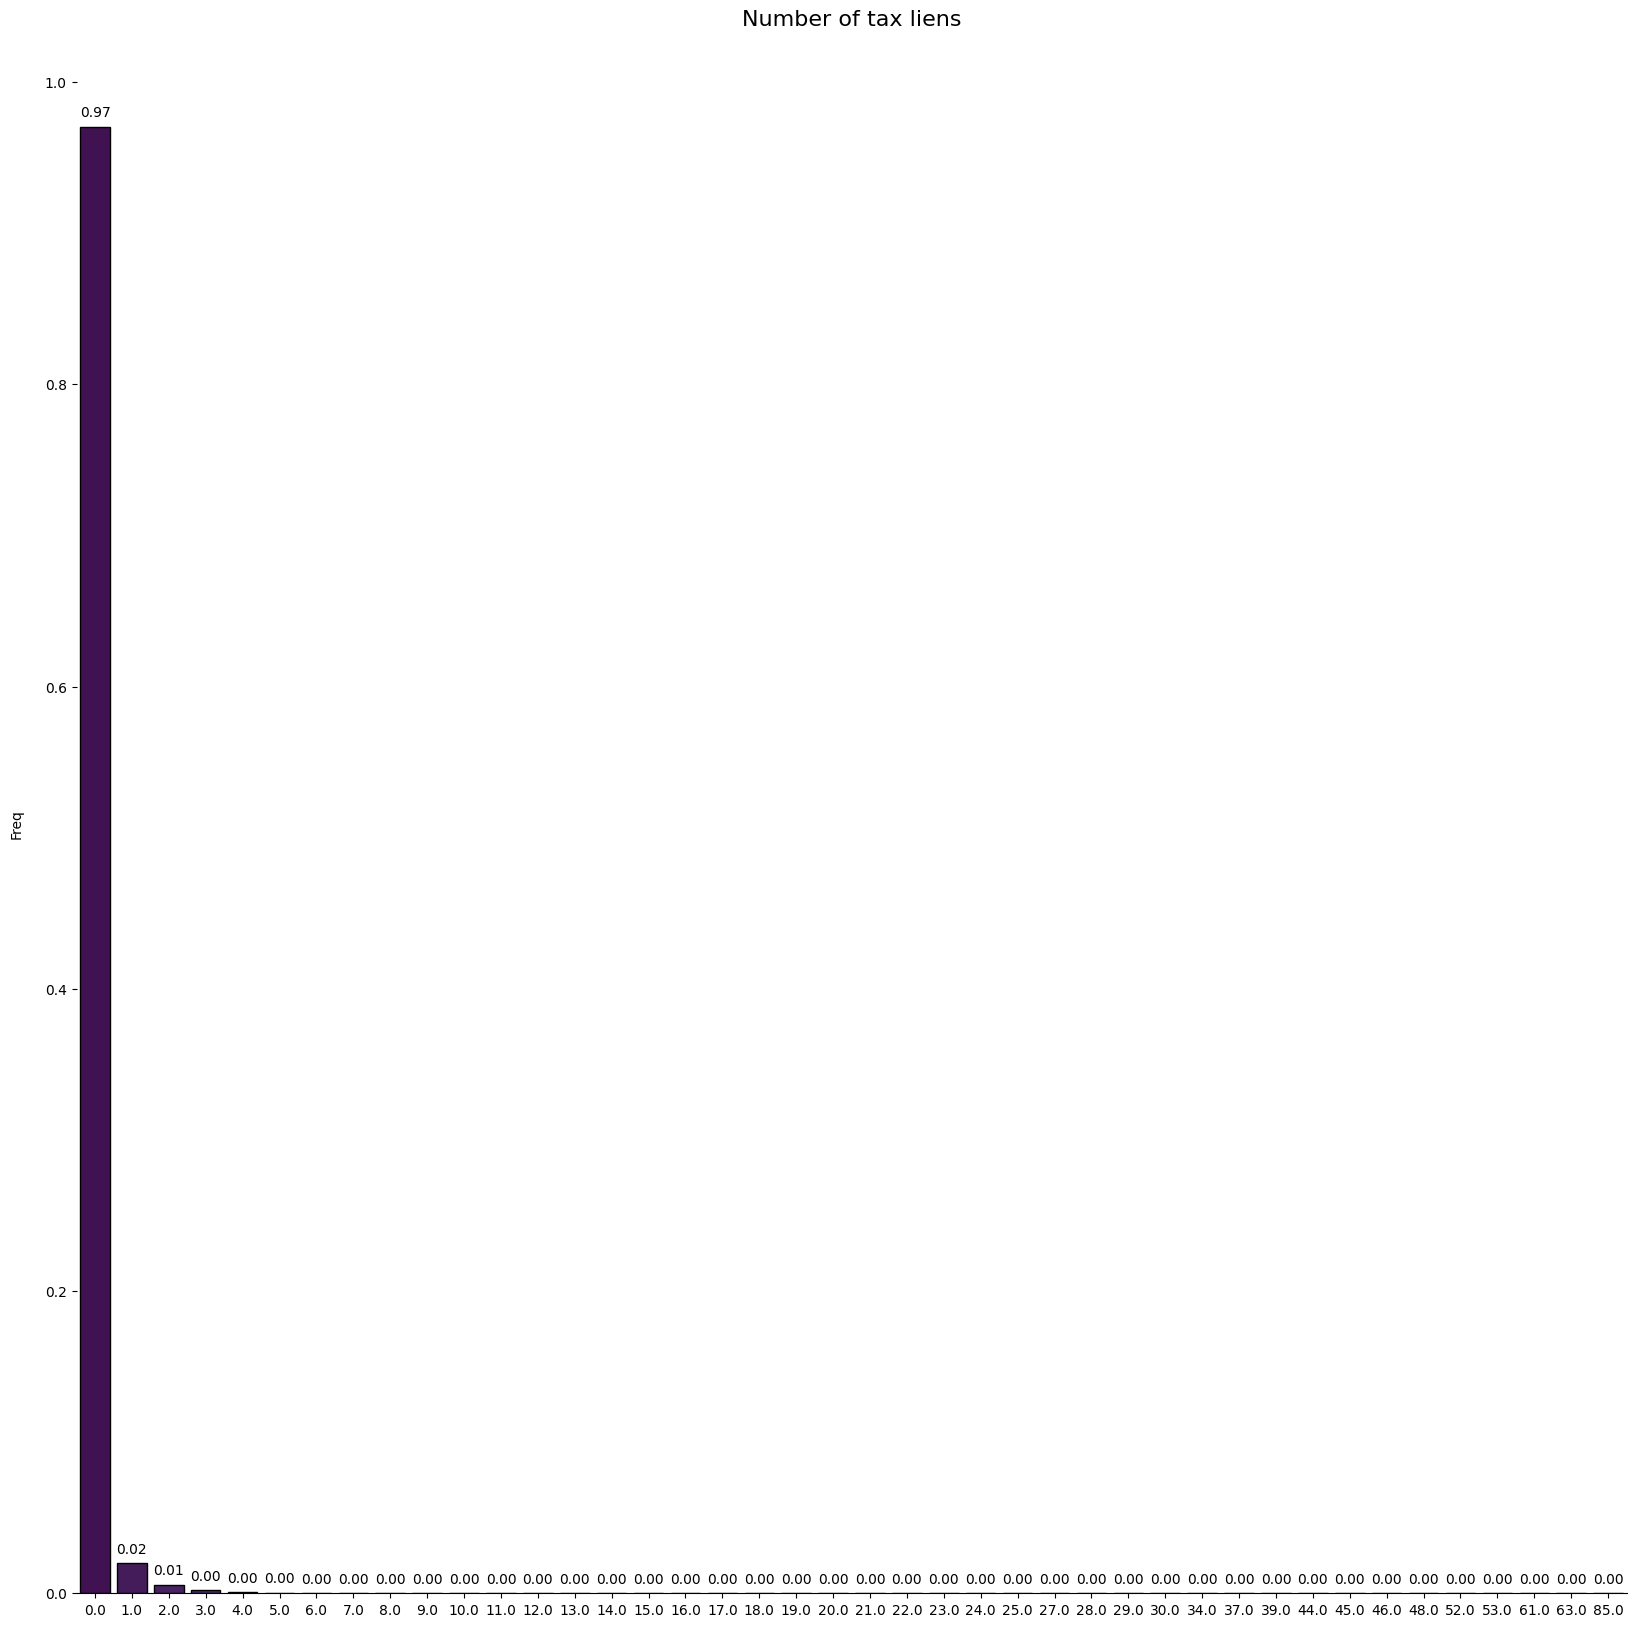

In [318]:
barplot(
    df["tax_liens"],
    "Number of tax liens",
    "Freq",
    (20, 20)
)

In [319]:
df = df.drop("tax_liens")

# ```tot_hi_cred_lim```

In [320]:
check_null_nan(df["tot_hi_cred_lim"])

Number of nulls: 70241


In [321]:
check_iv(df["tot_hi_cred_lim"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.04194


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 52398.50)",549521,0.256828,466363,83158,0.151328,-0.170296,7.927571e-03,9.897507e-04
1,"[52398.50, 67982.50)",180877,0.084536,153877,27000,0.149273,-0.154201,2.126996e-03,2.656114e-04
2,"[67982.50, 79839.50)",107865,0.050413,92211,15654,0.145126,-0.121165,7.737768e-04,9.666298e-05
3,"[79839.50, 94951.50)",107744,0.050356,92302,15442,0.143321,-0.106543,5.944369e-04,7.426949e-05
4,"[94951.50, 115973.50)",112932,0.052781,97446,15486,0.137127,-0.055156,1.638632e-04,2.048030e-05
5,"[115973.50, 156246.50)",162877,0.076123,141530,21347,0.131062,-0.002917,6.485226e-07,8.106530e-08
6,"[156246.50, 185697.50)",107021,0.050018,93252,13769,0.128657,0.018368,1.676132e-05,2.095136e-06
7,"[185697.50, 216516.50)",107007,0.050012,94085,12922,0.120758,0.09075,3.982513e-04,4.976433e-05
8,"[216516.50, 254631.50)",119768,0.055976,105759,14009,0.116968,0.126945,8.605576e-04,1.074975e-04
9,"[254631.50, 298610.50)",117338,0.054840,104449,12889,0.109845,0.197807,1.993637e-03,2.487992e-04


In [322]:
df = df.drop("tot_hi_cred_lim")

# ```total_bal_ex_mort```

In [323]:
check_null_nan(df["total_bal_ex_mort"])

Number of nulls: 49997


In [324]:
check_iv(df["total_bal_ex_mort"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00579


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8740.50)",156567,0.073174,138862,17705,0.113083,0.165116,1.876306e-03,2.342722e-04
1,"[8740.50, 12962.50)",118483,0.055375,103698,14785,0.124786,0.053352,1.545402e-04,1.931524e-05
2,"[12962.50, 17688.50)",146511,0.068475,127796,18715,0.127738,0.026592,4.794770e-05,5.993286e-06
3,"[17688.50, 21809.50)",133904,0.062582,116201,17703,0.132207,-0.01293,1.051351e-05,1.314179e-06
4,"[21809.50, 27862.50)",198080,0.092576,171503,26577,0.134173,-0.029963,8.403748e-05,1.050429e-05
5,"[27862.50, 41882.50)",404627,0.189110,349649,54978,0.135873,-0.044521,3.810397e-04,4.762603e-05
6,"[41882.50, 46607.50)",110452,0.051622,95010,15442,0.139807,-0.077627,3.200814e-04,4.000013e-05
7,"[46607.50, 55740.50)",177020,0.082733,152770,24250,0.136990,-0.054001,2.461057e-04,3.075947e-05
8,"[55740.50, 71448.50)",213165,0.099626,184482,28683,0.134558,-0.03327,1.116399e-04,1.395435e-05
9,"[71448.50, 83525.50)",108766,0.050834,94541,14225,0.130785,-0.000485,1.196409e-08,1.495512e-09


In [325]:
df = df.drop("total_bal_ex_mort")

# ```total_bc_limit```

In [326]:
check_null_nan(df["total_bc_limit"])

Number of nulls: 49997


In [327]:
check_iv(df["total_bc_limit"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.06703


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4479.00)",230771,0.107855,192586,38185,0.165467,-0.276418,0.009113,0.001136
1,"[4479.00, 5937.00)",109829,0.051331,92045,17784,0.161924,-0.250539,0.003530,0.000440
2,"[5937.00, 8487.50)",191884,0.089680,161588,30296,0.157887,-0.220484,0.004725,0.000589
3,"[8487.50, 9994.00)",109250,0.051060,92317,16933,0.154993,-0.198554,0.002165,0.000270
4,"[9994.00, 11958.50)",141458,0.066113,120616,20842,0.147337,-0.138876,0.001342,0.000168
5,"[11958.50, 13977.00)",128008,0.059827,109784,18224,0.142366,-0.098742,0.000605,0.000076
6,"[13977.00, 15951.50)",116339,0.054373,100374,15965,0.137228,-0.056013,0.000174,0.000022
7,"[15951.50, 18174.50)",115062,0.053776,99709,15353,0.133432,-0.023573,0.000030,0.000004
8,"[18174.50, 22463.00)",183721,0.085865,160296,23425,0.127503,0.028701,0.000070,0.000009
9,"[22463.00, 25661.50)",112373,0.052520,98922,13451,0.119700,0.10076,0.000514,0.000064


In [328]:
df = df.drop("total_bc_limit")

# ```total_il_high_credit_limit```

In [329]:
check_null_nan(df["total_il_high_credit_limit"])

Number of nulls: 70241


In [330]:
check_iv(df["total_il_high_credit_limit"], 
         y, 
         dict( 
              min_prebin_size=0.05
             )
        )

IV: 0.00535


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 51.50)",249056,0.116401,219715,29341,0.117809,0.118828,0.001573,1.964744e-04
1,"[51.50, 10762.50)",166140,0.077648,143107,23033,0.138636,-0.067853,0.000367,4.580873e-05
2,"[10762.50, 23976.50)",374242,0.174909,324175,50067,0.133782,-0.026596,0.000125,1.561753e-05
3,"[23976.50, 52844.50)",684704,0.320009,593193,91511,0.133650,-0.025457,0.000209,2.616710e-05
4,"[52844.50, 63227.50)",144509,0.067539,125531,18978,0.131327,-0.005245,0.000002,2.327339e-07
5,"[63227.50, 83296.50)",183421,0.085725,159853,23568,0.128491,0.019847,0.000034,4.190037e-06
6,"[83296.50, 110734.50)",128271,0.059950,112229,16042,0.125063,0.050813,0.000152,1.898638e-05
7,"[110734.50, inf)",139059,0.064992,122959,16100,0.115778,0.138514,0.001184,1.479394e-04
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
9,Missing,70241,0.032828,59165,11076,0.157686,-0.218968,0.001705,2.127111e-04


In [331]:
df = df.drop("total_il_high_credit_limit")

# Correlation

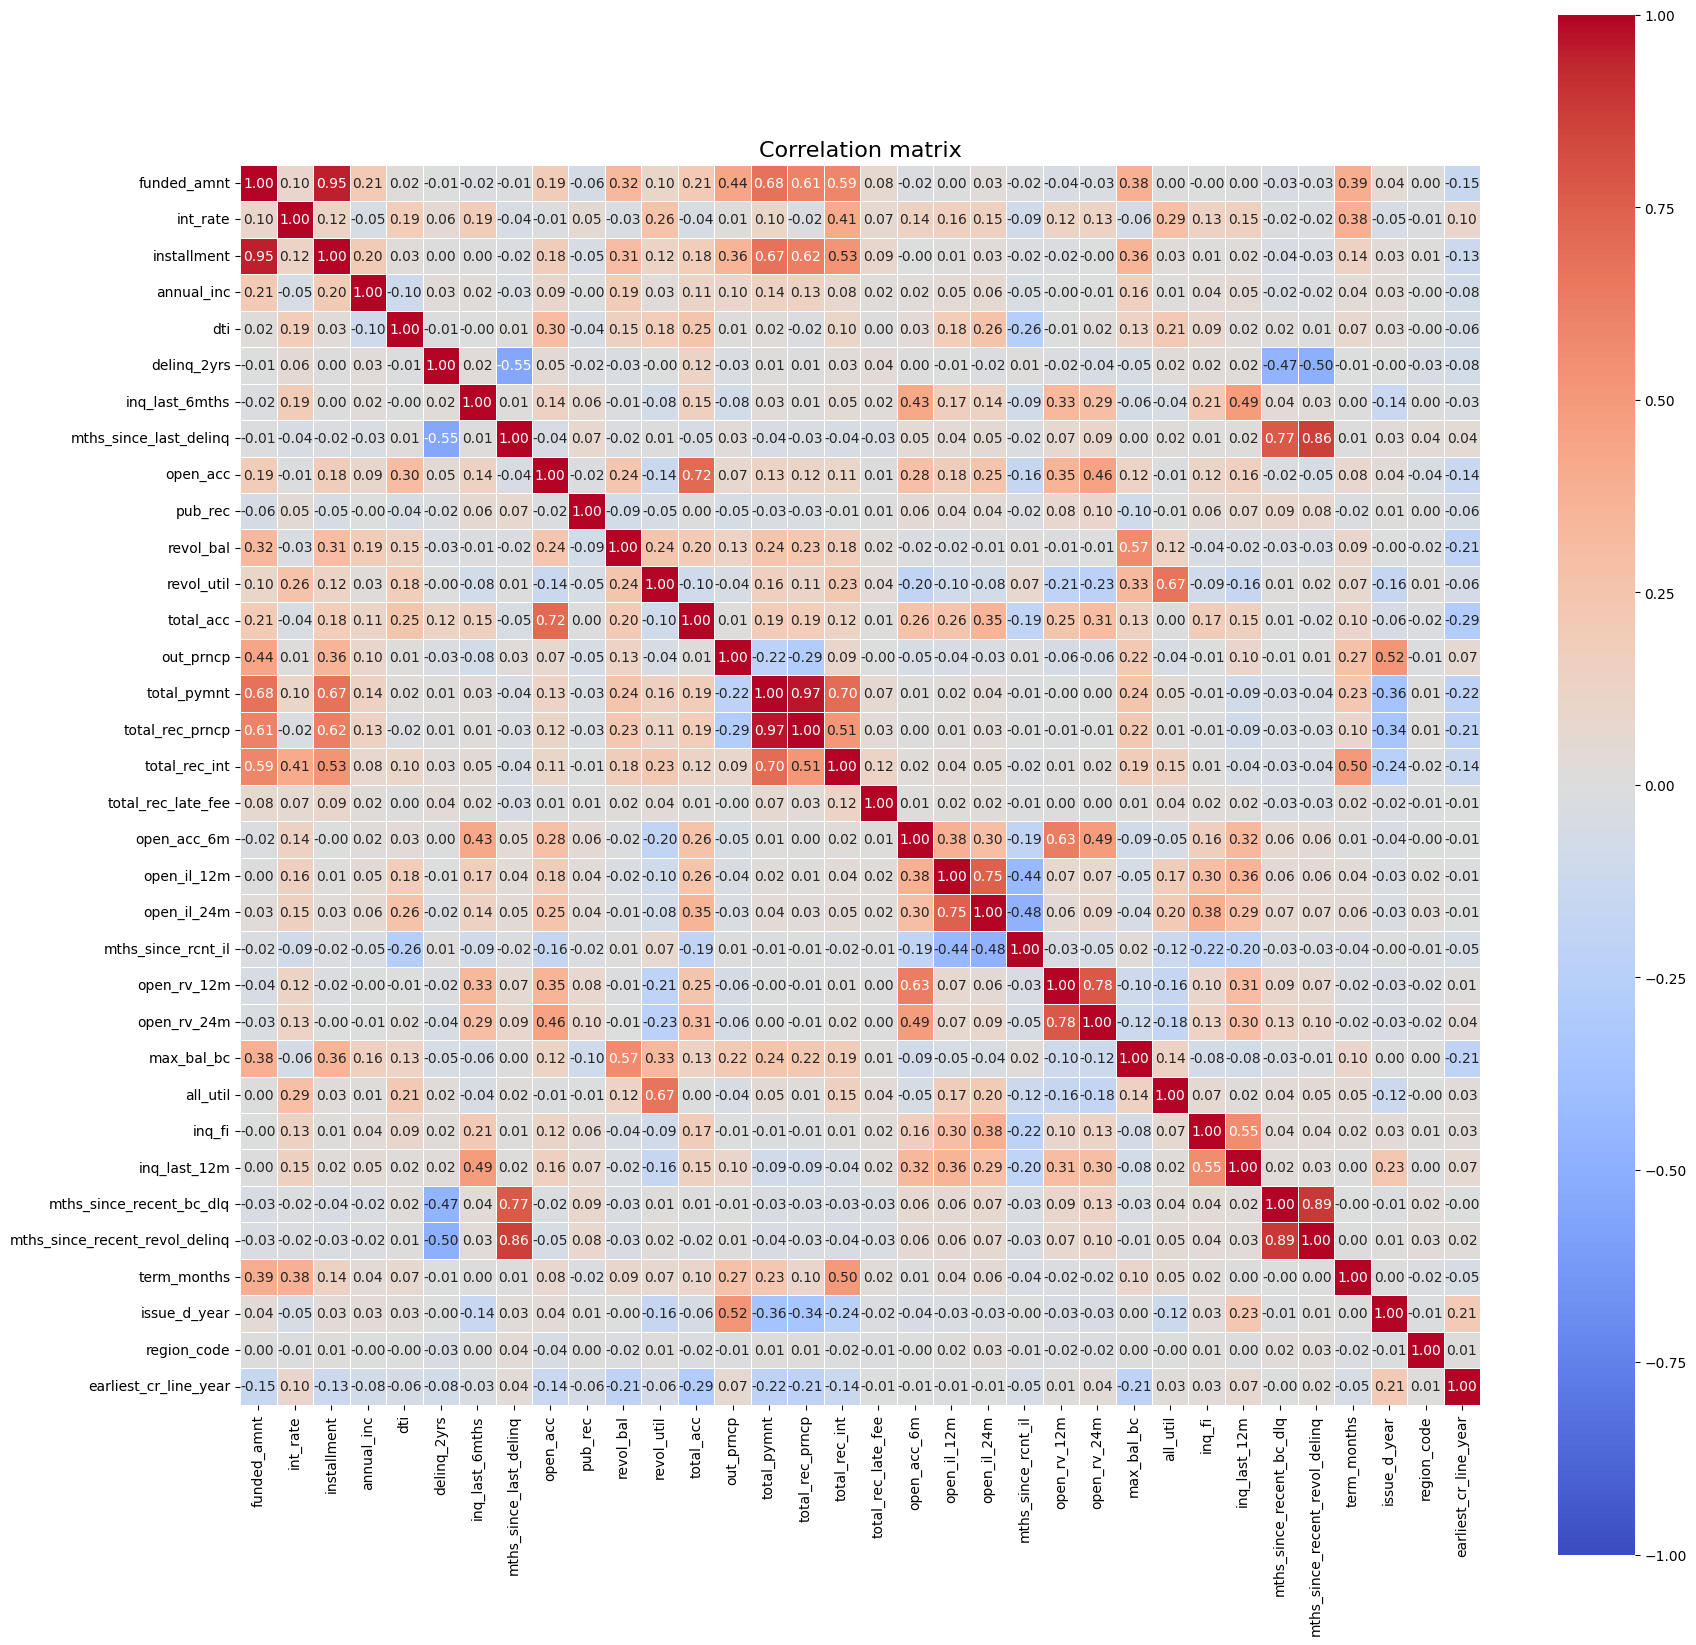

In [332]:
numeric_data = df.select(pl.selectors.numeric())

column_names = numeric_data.columns

corr_matrix = numeric_data.to_pandas().corr()

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f",  
    cmap="coolwarm", 
    vmin=-1, vmax=1, 
    linewidths=0.5,  
    square=True,  
    xticklabels=column_names,  
    yticklabels=column_names   
)

plt.title("Correlation matrix", fontsize=16);

## ```total_pymnt``` and ```total_rec_prncp```

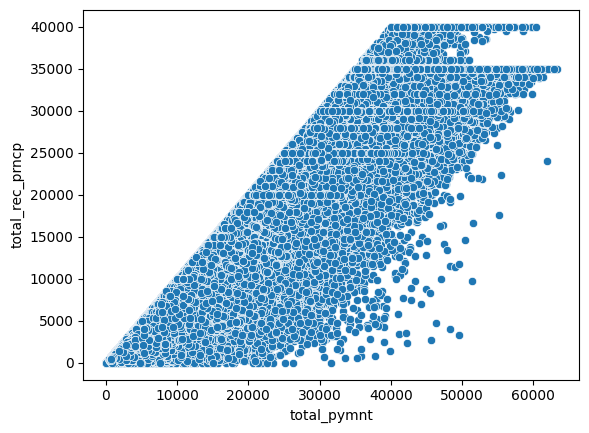

In [333]:
sns.scatterplot(
    x=df["total_pymnt"],
    y=df["total_rec_prncp"]
);

As we can see, none of these features need to be removed

## ```installment``` and ```funded_amnt```

We will not remove any of these features since they are responsible for loan size and payment, and the correlation only emphasizes the relationship between loan size and loan payment 

## ```mths_since_recent_bc_dlq``` and ```mths_since_recent_revol_delinq```

These features are responsible for 

- Months since the last delinquency on bank card debt
- Months since the last delinquency on revolving loans.

Accordingly, these types of delinquency have a logical connection with each other, so let's keep both attributes

# Final 

In [334]:
df.columns

['funded_amnt',
 'int_rate',
 'installment',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'total_pymnt',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'open_acc_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'inq_last_12m',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'disbursement_method',
 'term_months',
 'issue_d_month',
 'issue_d_year',
 'region_code',
 'earliest_cr_line_month',
 'earliest_cr_line_year']

In [335]:
conv_dict = {
    'funded_amnt': "funded_amnt",
    'int_rate': "interest_rate",
    'installment': "monthly_payment",
    'sub_grade': "grade",
    'emp_title': "emp_title",
    'emp_length': "emp_length",
    'home_ownership': "home_ownership_status",
    'annual_inc': "annual_income",
    'verification_status': "verification_status",
    'purpose': "loan_purpose",
    'addr_state': "addr_state",
    'dti': "dept_paym_income_ratio",
    'delinq_2yrs': "num_30+_delinq_in_2yrs",
    'inq_last_6mths': "num_inq_in_6mths",
    'mths_since_last_delinq': "mths_since_last_delinq",
    'open_acc': "num_open_credit_lines",
    'pub_rec': "num_derogatory_pub_rec",
    'revol_bal': "total_credit_revolving_bal",
    'revol_util': "used_credit_share",
    'total_acc': "tot_num_credit_lines",
    'initial_list_status': "initial_list_status",
    'out_prncp': "remaining_princ_for_tot_amnt_fund",
    'total_pymnt': "paym_rec_for_tot_amnt_fund",
    'total_rec_prncp': "princ_rec",
    'total_rec_int': "interest_rec",
    'total_rec_late_fee': "late_fees_rec",
    'open_acc_6m': "num_open_trades_in_6mths",
    'open_il_12m': "num_installment_acc_op_in_12mths",
    'open_il_24m': "num_installment_acc_op_in_24mths",
    'mths_since_rcnt_il': "mths_since_last_installment_acc_op",
    'open_rv_12m': "num_rev_trades_op_in_12mths",
    'open_rv_24m': "num_rev_trades_op_in_24mths",
    'max_bal_bc': "max_bal_owed",
    'all_util': "bal_to_cred_lim",
    'inq_fi': "num_inq",
    'inq_last_12m': "num_inq_in_12mths",
    'mths_since_recent_bc_dlq': "mths_since_recent_bankcard_delinq",
    'mths_since_recent_revol_delinq': "mths_since_recent_revol_delinq",
    'disbursement_method': "disbursement_method",
    'term_months': "loan_term_months",
    'issue_d_month': "issue_date_month",
    'issue_d_year': "issue_date_year",
    'region_code': "region_code",
    "earliest_cr_line_month": "earliest_cr_line_month",
    "earliest_cr_line_year": "earliest_cr_line_year",

}

In [336]:
df.columns = [conv_dict[el] for el in df.columns]

In [337]:
df

funded_amnt,interest_rate,monthly_payment,grade,emp_title,emp_length,home_ownership_status,annual_income,verification_status,loan_purpose,addr_state,dept_paym_income_ratio,num_30+_delinq_in_2yrs,num_inq_in_6mths,mths_since_last_delinq,num_open_credit_lines,num_derogatory_pub_rec,total_credit_revolving_bal,used_credit_share,tot_num_credit_lines,initial_list_status,remaining_princ_for_tot_amnt_fund,paym_rec_for_tot_amnt_fund,princ_rec,interest_rec,late_fees_rec,num_open_trades_in_6mths,num_installment_acc_op_in_12mths,num_installment_acc_op_in_24mths,mths_since_last_installment_acc_op,num_rev_trades_op_in_12mths,num_rev_trades_op_in_24mths,max_bal_owed,bal_to_cred_lim,num_inq,num_inq_in_12mths,mths_since_recent_bankcard_delinq,mths_since_recent_revol_delinq,disbursement_method,loan_term_months,issue_date_month,issue_date_year,region_code,earliest_cr_line_month,earliest_cr_line_year
i64,f64,f64,str,str,str,str,f64,str,str,str,f64,i64,i64,i64,i64,i64,i64,f64,i64,str,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,i8,str,i64
2500,13.56,84.92,"""C1""","""Chef""","""10+ years""","""RENT""",55000.0,"""Not Verified""","""debt_consolidation""","""NY""",18.24,0,1,null,9,1,4341,10.3,34,"""w""",2386.02,167.02,113.98,53.04,0.0,2,1,2,2,2,7,2137,28,1,2,null,null,"""Cash""",36,"""Dec""",2018,1,"""Apr""",2001
30000,18.94,777.23,"""D2""","""Postmaster ""","""10+ years""","""MORTGAGE""",90000.0,"""Source Verified""","""debt_consolidation""","""LA""",26.52,0,0,71,13,1,12315,24.2,44,"""w""",29387.75,1507.11,612.25,894.86,0.0,4,2,3,3,4,5,998,57,2,2,null,null,"""Cash""",60,"""Dec""",2018,7,"""Jun""",1987
5000,17.97,180.69,"""D1""","""Administrative""","""6 years""","""MORTGAGE""",59280.0,"""Source Verified""","""debt_consolidation""","""MI""",10.51,0,0,null,8,0,4599,19.1,13,"""w""",4787.21,353.89,212.79,141.1,0.0,0,0,2,14,0,2,0,35,1,0,null,null,"""Cash""",36,"""Dec""",2018,4,"""Apr""",2011
4000,18.94,146.51,"""D2""","""IT Supervisor""","""10+ years""","""MORTGAGE""",92000.0,"""Source Verified""","""debt_consolidation""","""WA""",16.74,0,0,null,10,0,5468,78.1,13,"""w""",3831.93,286.71,168.07,118.64,0.0,1,3,5,5,0,0,3761,70,2,3,null,null,"""Cash""",36,"""Dec""",2018,9,"""Feb""",2006
30000,16.14,731.78,"""C4""","""Mechanic""","""10+ years""","""MORTGAGE""",57250.0,"""Not Verified""","""debt_consolidation""","""MD""",26.35,0,0,null,12,0,829,3.6,26,"""w""",29339.02,1423.21,660.98,762.23,0.0,3,3,5,4,2,4,516,54,1,0,null,null,"""Cash""",60,"""Dec""",2018,2,"""Dec""",2000
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
30000,30.75,984.47,"""F5""","""Sales""","""6 years""","""MORTGAGE""",100000.0,"""Verified""","""debt_consolidation""","""FL""",22.13,0,2,null,9,0,19206,66.9,14,"""f""",25798.78,15623.4,4201.22,11422.18,0.0,2,1,3,3,1,3,9558,74,3,3,null,null,"""Cash""",60,"""Oct""",2017,3,"""Aug""",1996
12000,14.08,279.72,"""C3""","""house keeper""","""10+ years""","""MORTGAGE""",58000.0,"""Not Verified""","""debt_consolidation""","""VT""",20.88,0,0,null,12,0,9592,39.2,34,"""w""",8687.2,5360.96,3312.8,2048.16,0.0,2,0,1,24,3,4,4052,38,2,1,null,null,"""Cash""",60,"""Oct""",2017,0,"""Jan""",2004
10000,11.99,332.1,"""B5""","""Teacher""","""10+ years""","""OWN""",64000.0,"""Source Verified""","""debt_consolidation""","""IL""",12.96,0,0,null,6,0,7094,70.9,13,"""w""",5993.27,5306.94,4006.73,1300.21,0.0,1,1,2,3,0,1,1864,93,0,3,null,null,"""Cash""",36,"""Oct""",2017,6,"""Feb""",1995


In [338]:
df.write_csv(
    "X.csv",
    separator=",",  
)

pl.DataFrame(y.alias("y")).write_csv("target.csv")